<a href="https://colab.research.google.com/github/justdepie/MSc-Thesis-From-Tables-to-Natural-Language-Summaries/blob/main/Modeling_Current_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
userdata.get('token') #get the hf token

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


##Loading the data

In [ ]:
%%capture
!wget -O /content/input_val.pkl https://www.dropbox.com/scl/fi/wc9d5gszqvn7cksxs88l8/input_val.pkl?rlkey=0m5xxsd3efc4lgbuh6h4fg3sz&dl=0
!wget -O /content/input_train.pkl https://www.dropbox.com/scl/fi/wngubb47bht4vpm1ggwn9/input_train.pkl?rlkey=8nrlojc2pq3zvf8g5qlqu0tw5&dl=0
!wget -O /content/input_test.pkl https://www.dropbox.com/scl/fi/tadz6falhrl8k8stx3ytk/input_test.pkl?rlkey=1gcz9c0dvdtq0zpcnst8ve8fr&dl=0

In [ ]:
import pickle

file_path = ['/content/input_train.pkl','/content/input_val.pkl','/content/input_test.pkl']

sets={}
for item in range(len(file_path)):
  with open(file_path[item], 'rb') as file:
      sets[item] = pickle.load(file)

In [ ]:
df_train=sets[0]
df_val=sets[1]
df_test=sets[2]

In [ ]:
df_test['Table to Text'].iloc[2]

'Table page title: A. J. Hawk, Table section title: Career statistics, Table section text: Key GP: games played COMB: combined tackles TOTAL: total tackles AST: assisted tackles SACK: sacks FF: forced fumbles FR: fumble recoveries FR YDS: fumble return yards INT: interceptions IR YDS: interception return yards AVG IR: average interception return LNG: longest interception return TD: interceptions returned for touchdown PD: passes defensed, Table converted to text: Year is 2006, Team is GB, GP is 16, TOTAL is 119, COMB is 82, AST is 37, SACK is 3.5, FF is 1, FR is 2, FR YDS is 0, INT is 2, IR YDS is 31, AVG IR is 14, LNG is 25, TD is 0, PD is 8. Year is 2007, Team is GB, GP is 16, TOTAL is 105, COMB is 78, AST is 27, SACK is 1.0, FF is 1, FR is 1, FR YDS is 0, INT is 1, IR YDS is 1, AVG IR is 10, LNG is 10, TD is 0, PD is 4. Year is 2008, Team is GB, GP is 16, TOTAL is 86, COMB is 67, AST is 19, SACK is 3.0, FF is 0, FR is 0, FR YDS is 0, INT is 0, IR YDS is 0, AVG IR is 0, LNG is 0, TD 

In [ ]:
%%capture
!pip install peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 accelerate==0.21.0

#**Models**


In [ ]:
!nvidia-smi

Thu Feb  1 10:22:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##**T5-small**
--------------------------------------------------------------------------------
[Hugging Face Page](https://huggingface.co/t5-small)

In [ ]:
df_train

Table to Text  \
0      Table page title: List of Commanders of the Tu...   
1      Table page title: List of Presidents of the Ch...   
2      Table page title: List of districts of Istanbu...   
3      Table page title: List of largest California c...   
4      Table page title: List of Irish state funerals...   
...                                                  ...   
23645  Table page title: List of kings of Connacht, T...   
23646  Table page title: List of Belgrade neighbourho...   
23647  Table page title: List of Belgrade neighbourho...   
23648  Table page title: Yelena Isinbayeva, Table sec...   
23649  Table page title: Yelena Isinbayeva, Table sec...   

                                               Anotation  \
0      Doğan Güreş was a Commander of the Turkish Arm...   
1      In February 1985, Antonio Marchesano was Presi...   
2                Büyükçekmece is a district of Istanbul.   
3      Bakersfield's population makes it the 9th-most...   
4      President Erskine Childers died in office in 1...   
...                                                  ...   
23645  Fedlim Geancach Ó Conchobair was the son of To...   
23646    Čukarička padina is a neighborhood of Belgrade.   
23647      Careva Ćuprija is a neighborhood of Belgrade.   
23648  Yelena Isinbayeva appeared in 1998 World Junio...   
23649  Isinbayeva won gold at the 2003 European Under...   

                 table_section_title  
0                                     
1                                     
2                                     
3                                     
4                                     
...                              ...  
23645  Ó Conchubhair Donn, 1368–1474  
23646                       Čukarica  
23647                       Čukarica  
23648                   Αchievements  
23649                   Αchievements  

[23650 rows x 3 columns]

In [ ]:
df_train['Table to Text'].iloc[9008]

'Table page title: Mark Patton, Table section title: Film, Table section text: , Table converted to text: Year is 1982, Title is Come Back to the Five and Dime, Jimmy Dean, Jimmy Dean, Role is Joe Qualley, Notes is Feature film. Year is 1982, Title is Anna to the Infinite Power, Role is Rowan Hart, Notes is Feature film. Year is 1985, Title is A Nightmare on Elm Street 2: Freddys Revenge, Role is Jesse Walsh, Notes is Feature film. Year is 2003, Title is Freddy vs. Jason, Role is Jesse Walsh, Notes is Archive footage, special thanks. Year is 2010, Title is Never Sleep Again: The Elm Street Legacy, Role is Himself, Notes is Documentary. Year is 2016, Title is Family Possessions, Role is Tyson, Notes is Feature film. Year is 2017, Title is Amityville: Evil Never Dies, Role is James, Notes is Feature film, Focus on: 1985 A Nightmare on Elm Street 2: Freddys Revenge Jesse Walsh, Table Structure: 8 rows, 4 columns.'

### Preprocess

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The preprocessing function below:


1.   Prepends the string "summarize: " to each document in the 'text' field of the input examples to instruct the T5 model on the task it needs to perform.
2.   Tokenizes the prepended input texts to convert them into a format that can be fed into the model. Then, sets a maximum token length of 1024, and truncates any text longer than this limit.
3. Tokenizes the 'summary' field of the input examples to prepare the target labels for the summarization task. Next, a maximum token length of 128 is being set, and any text longer than this limit gets truncated.
4. The tokenized labels are assigned to the 'labels' field of model_inputs which is used during training to calculate the loss and guide model learning.


In [ ]:
def preprocess_function(ex):

    inputs = ["summarize: " + doc for doc in ex["Table to Text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=ex["Anotation"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
#Turning dataframes into HF objects
!pip install torch datasets -q
from datasets import Dataset

train = Dataset.from_pandas(df_train)
valid = Dataset.from_pandas(df_val)
test = Dataset.from_pandas(df_test)

In [ ]:
#applying the preprocessing function to each subset
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)
tokenized_test = test.map(preprocess_function, batched=True)

Map:   0%|          | 0/23650 [00:00<?, ? examples/s]

Map:   0%|          | 0/12076 [00:00<?, ? examples/s]

Map:   0%|          | 0/7700 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

### Evaluation Metrics for Training

We will use the [ROUGE](https://huggingface.co/spaces/evaluate-metric/rouge) metric for training. We will load the evaluation method from the Huggingface [Evaluate](https://huggingface.co/docs/evaluate/index) library.

In [ ]:
! pip install -q evaluate rouge_score

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

Next we build a function that passes the predictions and labels to calculate the ROUGE metric.

In [ ]:
# source: https://www.kaggle.com/code/rizdelhi/fine-tuning-t5-on-text-summarization-task
import numpy as np

def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    # Decode the tokenized predictions back to text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace any -100 values in labels with the tokenizer's pad_token_id.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode the tokenized labels back to text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute the ROUGE metric using stemming
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculate the length of each prediction
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]

    # Compute the mean length of the predictions and add it to the result dictionary under the key "gen_len".
    result["gen_len"] = np.mean(prediction_lens)

    # Round each value in the result dictionary to 4 decimal places
    return {k: round(v, 4) for k, v in result.items()}


In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

Load the t5-small model:

In [ ]:
#creates an instance of t5-small
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

###Hyperparameter-tuning

In [ ]:
#defining the optuna hyperparameter space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-5, 2e-6,2e-4]) ,
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4,8,16]),
    }

In [ ]:
def model_init(trial):
    return  AutoModelForSeq2SeqLM.from_pretrained("t5-small")


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_fine_tuned_t5_small_model",
    evaluation_strategy="epoch",
    save_strategy= "epoch",
    learning_rate=2e-5,
    metric_for_best_model = 'eval_loss',
    weight_decay=0.01,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    auto_find_batch_size=True

)

In [ ]:
trainer = Seq2SeqTrainer(
    model=None,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator

)

In [ ]:
!pip install optuna -q

In [ ]:
#defining the objective function
#the goal is to minimize the evaluation loss.

def my_objective(metrics):
    eval_loss = metrics["eval_loss"]
    return eval_loss

In [ ]:
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

best_trial = trainer.hyperparameter_search(
    direction="minimize",
    sampler=TPESampler(),
    pruner=HyperbandPruner(),
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=3,
    compute_objective=my_objective,
)

In [ ]:
best_params=best_trial.hyperparameters

In [ ]:
print(best_trial)

import pickle
# Save to a pickle file
with open('best_params.pkl', 'wb') as pickle_file:
    pickle.dump(best_params, pickle_file)

### Train

Now we define the training hyperparameters in Seq2SeqTrainingArguments. Hyperparameter tuning resulted in a learning rate of 2e-5 and a batch size of 4. We choose a weight decay of 0.01 to prevent our model from being way more complex than we need. The small T5 will be trained for 4 epochs while performing evaluation at the end of each.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_fine_tuned_t5_small_model",
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
)

Now we pass the arguments as well as the compute_metrics function, the specified tokenizer, the tokenized data, etc to the trainer.

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)

And finally we train the model.

In [ ]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=5916, training_loss=2.1053080426590762, metrics={'train_runtime': 7847.9647, 'train_samples_per_second': 12.054, 'train_steps_per_second': 0.754, 'total_flos': 2.5604148626128896e+16, 'train_loss': 2.1053080426590762, 'epoch': 4.0})

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

loss={'Epoch':[1,2,3,4],"Training Loss":[2.254600	,2.081300,2.006700,1.981700],'Validation Loss':[1.951396,1.873669,1.843817,1.834649]}
df_loss=pd.DataFrame(loss)
df_loss

Epoch  Training Loss  Validation Loss
0      1         2.2546         1.951396
1      2         2.0813         1.873669
2      3         2.0067         1.843817
3      4         1.9817         1.834649

There are no signs of overfitting or underfitting. It would possibly be beneficial to train the model for more epochs since the validation loss is
 still decreasing.

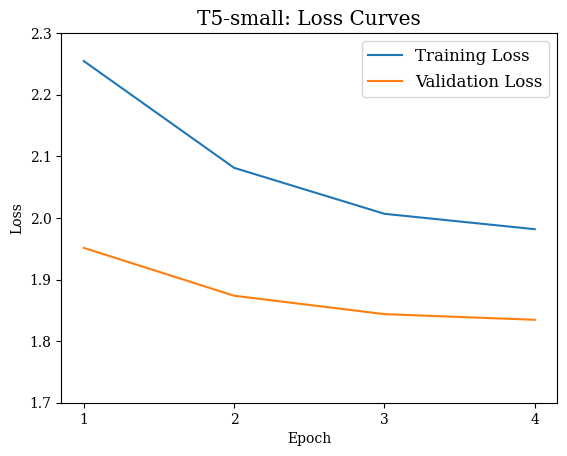

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

df_loss['Training Loss'].plot(kind='line', label='Training Loss')
df_loss['Validation Loss'].plot(kind='line', label='Validation Loss')
plt.xticks(range(len(df_loss)), [1, 2, 3, 4])
plt.ylim(bottom=1.7,top=2.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('T5-small: Loss Curves')
plt.legend(loc='upper right')

###Saving the model

In [ ]:
trainer.save_model("fine_tuned_t5_on_ToTTo")

Let's now push it to hub.



In [ ]:
fine_tuned_model = trainer.model

fine_tuned_model.push_to_hub("fine_tuned_t5_on_ToTTo")
tokenizer.push_to_hub("fine_tuned_t5_on_ToTTo")

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Depie/fine_tuned_t5_on_ToTTo/commit/d0600638ac016e0fb3ac7f8ecd6c1155e7672678', commit_message='Upload tokenizer', commit_description='', oid='d0600638ac016e0fb3ac7f8ecd6c1155e7672678', pr_url=None, pr_revision=None, pr_num=None)

### Evaluation


In order to evaluate the model we will use the f-measures of ROUGE, SacreBleu and Meteor.


In [ ]:
! pip install -q evaluate  rouge_score sacrebleu meteor

In [ ]:
import evaluate, rouge_score

rouge = evaluate.load("rouge")
bleu =evaluate.load("sacrebleu")
meteor=evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Depie/fine_tuned_t5_on_ToTTo",device=0)

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

####All

Let's print the generated summaries and the corresponding anotation of the first 3 tables of the test set.

In [ ]:
summaries = {}
for i, text in enumerate(df_test['Table to Text'].head(3)):
        text = "summarize: " + text
        summaries[i] = summarizer(text,min_length=5,max_length=30)
        print(f"Table {i}\nGenerated Summary: {summaries[i][0]['summary_text']}\nAnotation: {df_test['Anotation'].iloc[i]}\n")


Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors


Table 0
Generated Summary: Daniel Henry Chamberlain served as the Governor of South Carolina from December 1, 1874.
Anotation: Daniel Henry Chamberlain was the 76th Governor of South Carolina from 1874.

Table 1
Generated Summary: In 2016, Jodorowsky played Evelyn in Kids in Love.
Anotation: Alma Jodorowsky had the role of Evelyn in 2016 film Kids in Love.

Table 2
Generated Summary: In 2006, A. J. Hawk scored 119 touchdowns in 119 games.
Anotation: In his rookie season, Hawk led with 119 total tackles.



**Experiment**

What if we are intrested in another piece of information? We will change the focal point in Table 1 (above) to make an experiment. If we are intrested only in the short films that Alma Jodorowsky participated, the pre-existing "Focus on:2016 Kids in Love Evelyn" part of the template changes to "Focus on: short film". Let's see how the model does. At the same time we will check if the model is case-sensitive.

In [ ]:
df_test['Table to Text'].iloc[1]

'Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: 2016 Kids in Love Evelyn, Table Structure: 11 rows,

It seems that the model generates varied outputs based on whether uppercase or lowercase letters are used. The provided outputs of all uppercase or all lowercase do not produce acurate summaries in this example.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

inputs=["SHORT FILM","Short Film","Short film","short film"]

for input in inputs:
  text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
  print(f"{input}: {summarizer(text,min_length=3,max_length=50)[0]['summary_text']}")

SHORT FILM: Alma Jodorowsky starred in the film SHORT FILM.
Short Film: In 2011, Alma Jodorowsky appeared in the Short film "Awake to Emptiness" in a short film.
Short film: Alma Jodorowsky appeared in Short film, Awake to Emptiness, in 2012, Sea, No Sex and Sun.
short film: Alma Jodorowsky starred in the short film "The Starry Sky Above Me" in TBA.


Let's take this a step further and add to the "focus on" part the word "year". The model seems to ignore the extra information.

In [ ]:
input="Short Film, year"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=100)[0]['summary_text']

'Alma Jodorowsky starred in the Short film, Awake to Emptiness.'

What is going to happen if the focus on part includes words that are not part of the table? Let's say we are intrested in finding out which was the first movie that Alma appeared. In this case we will add in the "focus on" part the bigram "first film" along with the name of the actress.

We observe that the model does not convey the requested information.

In [ ]:
input="Alma Jodorowsky, first film"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=200)[0]['summary_text']

'Alma Jodorowsky appeared in the first film, "Awake to Emptiness".'

**Getting all summaries**

Now we will generate the summaries for the test set. We choose to truncate the texts to avoid ram issues and make the whole procedure faster.  


In [ ]:
import numpy as np

# Split the DataFrame into 5 subsets
df_subsets = np.array_split(df_test,5)

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
import gc
import torch

max_sequence_length = 30000
gc.collect()
torch.cuda.empty_cache()

summaries_T5 = {}
for j in range(1,len(df_subsets)):
  torch.cuda.empty_cache()
  with tqdm(total=len(df_subsets[j]), desc=f"Processing subset {j}") as pbar:
      for i, text in enumerate(df_subsets[j]['Table to Text']):
          text = "summarize: " + text
          text = text[:max_sequence_length] #truncating the text to avoid ram issues
          summaries_T5[i] = summarizer(text,max_length=30,min_length=5)
          pbar.update(1)



  # Save the dictionary as a pickle file
  with open(f'summaries_T5_{j+1}.pkl', 'wb') as file:
    pickle.dump(summaries_T5 , file)



Processing subset 4: 100%|██████████| 1540/1540 [06:57<00:00,  3.69it/s]


To continue, we load the subsets and then put everything into a single dictionary.

In [ ]:
sum_paths=['/content/summaries_T5_1.pkl','/content/summaries_T5_2.pkl','/content/summaries_T5_3.pkl'
            ,'/content/summaries_T5_4.pkl','/content/summaries_T5_5.pkl']


import pickle
summaries={}
for path in range(len(sum_paths)):
  with open(sum_paths[path], 'rb') as file:
      summaries[path] = pickle.load(file)

In [ ]:
#adjusting the keys and putting everything into a dictionary
new_starting_key = 1540

summaries_T5={}
for i in summaries.keys():
    summaries[i] = {key + new_starting_key * i: value for key, value in summaries[i].items()}
    summaries_T5.update(summaries[i])


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with the METEOR and SacreBleu scores and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_bleu={}
T5_rouge={}
T5_meteor={}

for s in tqdm(summaries_T5.keys()):
  preds = [summaries_T5[s][0]['summary_text']]
  labels = [df_test['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_rouge[s]=score_r
  T5_bleu[s]=score_b
  T5_meteor[s]=score_m

100%|██████████| 7700/7700 [20:45<00:00,  6.18it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_rouge.keys():
  sum_r1+=T5_rouge[key]['rouge1']
  sum_r2+=T5_rouge[key]['rouge2']
  sum_rL+=T5_rouge[key]['rougeL']
  sum_rLsum+=T5_rouge[key]['rougeLsum']
  sumbleu+=T5_bleu[key]['score']
  sum_meteor+=T5_meteor[key]['meteor']

  r1_list.append(T5_rouge[key]['rouge1'])
  r2_list.append(T5_rouge[key]['rouge2'])
  rL_list.append(T5_rouge[key]['rougeL'])
  rLsum_list.append(T5_rouge[key]['rougeLsum'])
  bleu_list.append(T5_bleu[key]['score'])
  meteor_list.append(T5_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_rouge.keys())
avg_r2=sum_r2/len(T5_rouge.keys())
avg_rL=sum_rL/len(T5_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_rouge.keys())
avg_bleu=sumbleu/len(T5_bleu.keys())
avg_meteor=sum_meteor/len(T5_meteor.keys())

print(f"""---------T5-small---------\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {min(r1_list)} | Max: {max(r1_list)}
Rouge-2 | Min: {min(r2_list)} | Max: {max(r2_list)}
Rouge-L | Min: {min(rL_list)} | Max: {max(rL_list)}
Rouge-Lsum | Min: {min(rLsum_list)} | Max: {max(rLsum_list)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---------T5-small---------

        Average
Rouge-1: 0.57
Rouge-2: 0.34
Rouge-L: 0.48
Rouge-Lsum: 0.48
SacreBleu: 21.0
Meteor: 0.49

        Median
Rouge-1: 0.57
Rouge-2: 0.31
Rouge-L: 0.45
Rouge-Lsum: 0.45
SacreBleu: 14.29
Meteor: 0.48

    Standard Deviation
Rouge-1: 0.2
Rouge-2: 0.23
Rouge-L: 0.21
Rouge-Lsum: 0.21
SacreBleu: 19.56
Meteor: 0.22

  Minimum/Maximum
Rouge-1 | Min: 0.0 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.0 | Max: 1.0
Rouge-Lsum | Min: 0.0 | Max: 1.0
SacreBleu | Min: 0.0 | Max: 100.0
Meteor| Min: 0.0 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_All_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_All_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_All_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_All=[T5_All_avg_all, T5_All_median_all, T5_All_sd_all]
for metric, metric_name in zip(metrics_T5_All, ['T5_All_avg_all', 'T5_All_median_all', 'T5_All_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_T5=pd.DataFrame(T5_metrics)
df_T5

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0     0.769231  0.500000  0.769231    0.769231  34.460734  0.807183
1     0.636364  0.400000  0.545455    0.545455  22.825471  0.547445
2     0.285714  0.000000  0.285714    0.285714   3.929719  0.206612
3     0.322581  0.137931  0.193548    0.193548   9.917721  0.157895
4     0.689655  0.592593  0.689655    0.689655  53.016463  0.712949
...        ...       ...       ...         ...        ...       ...
7695  0.636364  0.200000  0.454545    0.454545   6.917184  0.551255
7696  0.466667  0.285714  0.466667    0.466667  16.560385  0.380056
7697  0.809524  0.500000  0.476190    0.476190  31.824852  0.736900
7698  0.636364  0.400000  0.636364    0.636364  19.487234  0.466687
7699  0.512821  0.324324  0.410256    0.410256  16.276175  0.279601

[7700 rows x 6 columns]

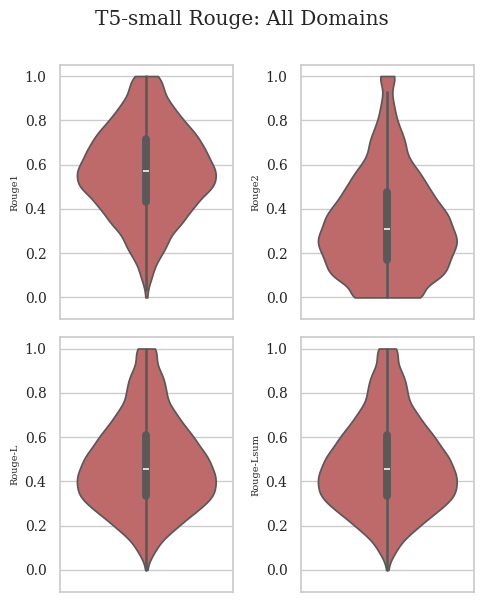

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-small Rouge: All Domains",  y=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

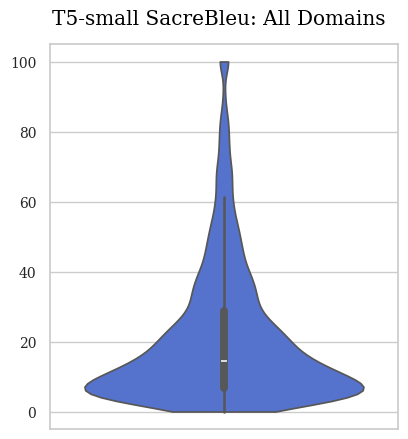

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_T5, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small SacreBleu: All Domains", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

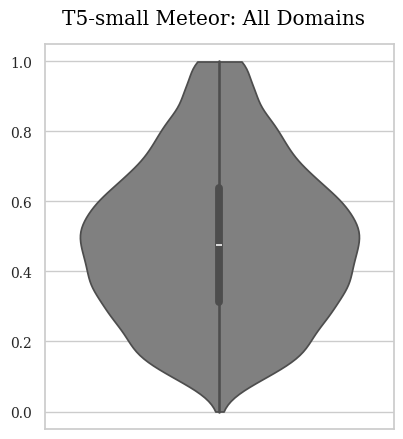

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_T5, y="Meteor", color="gray", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: All Domains", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Top 5 Domains
In this section, we will assess the model's performance on tables originating from the 5 most prevalent domains found in the dataset. A separate evaluation by category will take place.

In [ ]:
#Replacing "Film","Filmography" & "Television" with "Film/TV "
df_test['table_section_title'] = df_test['table_section_title'].replace(['Filmography','Film','Television'], 'Film/TV')

In [ ]:
df_test.table_section_title.value_counts().head(5)

Film/TV                      600
Demographics                 417
                             336
Mixed martial arts record    158
Career statistics            152
Name: table_section_title, dtype: int64

#####**Domain:** Film/Tv

In [ ]:
FilmTv = df_test[df_test['table_section_title'].isin(['Film/TV'])]
FilmTv

Table to Text  \
1     Table page title: Alma Jodorowsky, Table secti...   
6     Table page title: Julian Sands, Table section ...   
35    Table page title: Jennie Garth, Table section ...   
70    Table page title: Melissa George, Table sectio...   
94    Table page title: Marcia Strassman, Table sect...   
...                                                 ...   
7659  Table page title: Ruth Gemmell, Table section ...   
7660  Table page title: Keiynan Lonsdale, Table sect...   
7661  Table page title: Péter Scherer, Table section...   
7690  Table page title: Aidan McArdle, Table section...   
7691  Table page title: Karl Malden, Table section t...   

                                              Anotation table_section_title  
1     Alma Jodorowsky had the role of Evelyn in 2016...             Film/TV  
6     In 2012, Julian Sands played as Alistair Wesle...             Film/TV  
35    In 2008, Garth starred as Kelly Taylor in "902...             Film/TV  
70    Melissa George starred in Charmed and, in 2003...             Film/TV  
94    Marcia Strassman played Nancy Sterngood on the...             Film/TV  
...                                                 ...                 ...  
7659  In 1996, Gemmell appeared as Kerry Cox in the ...             Film/TV  
7660  Keiynan Lonsdale played Uriah Pedrad in The Di...             Film/TV  
7661  Péter Scherer appeared in Miklós Jancsó’s movi...             Film/TV  
7690  In 2004, Aidan McArdle played Slannen in the f...             Film/TV  
7691  Malden portrayed Leon Klinghoffer in the 1989 ...             Film/TV  

[600 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
import gc

FilmTv_summaries_T5 = {}
for i, text in tqdm(enumerate(FilmTv['Table to Text']),total=len(FilmTv['Table to Text'])):
    text = "summarize: " + text
    FilmTv_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)


100%|██████████| 600/600 [02:30<00:00,  3.99it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along withe METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_FilmTv_bleu={}
T5_FilmTv_rouge={}
T5_FilmTv_meteor={}

for s in tqdm(FilmTv_summaries_T5.keys()):
  preds = [FilmTv_summaries_T5[s][0]['summary_text']]
  labels = [FilmTv['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_FilmTv_rouge[s]=score_r
  T5_FilmTv_bleu[s]=score_b
  T5_FilmTv_meteor[s]=score_m

100%|██████████| 600/600 [01:38<00:00,  6.11it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_FilmTv_rouge.keys():
  sum_r1+=T5_FilmTv_rouge[key]['rouge1']
  sum_r2+=T5_FilmTv_rouge[key]['rouge2']
  sum_rL+=T5_FilmTv_rouge[key]['rougeL']
  sum_rLsum+=T5_FilmTv_rouge[key]['rougeLsum']
  sumbleu+=T5_FilmTv_bleu[key]['score']
  sum_meteor+=T5_FilmTv_meteor[key]['meteor']

  r1_list.append(T5_FilmTv_rouge[key]['rouge1'])
  r2_list.append(T5_FilmTv_rouge[key]['rouge2'])
  rL_list.append(T5_FilmTv_rouge[key]['rougeL'])
  rLsum_list.append(T5_FilmTv_rouge[key]['rougeLsum'])
  bleu_list.append(T5_FilmTv_bleu[key]['score'])
  meteor_list.append(T5_FilmTv_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_FilmTv_rouge.keys())
avg_r2=sum_r2/len(T5_FilmTv_rouge.keys())
avg_rL=sum_rL/len(T5_FilmTv_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_FilmTv_rouge.keys())
avg_bleu=sumbleu/len(T5_FilmTv_bleu.keys())
avg_meteor=sum_meteor/len(T5_FilmTv_meteor.keys())

print(f"""---T5-small-Film/Tv-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-small-Film/Tv-Domain---

        Average
Rouge-1: 0.72
Rouge-2: 0.46
Rouge-L: 0.62
Rouge-Lsum: 0.62
SacreBleu: 29.81
Meteor: 0.62

        Median
Rouge-1: 0.74
Rouge-2: 0.45
Rouge-L: 0.61
Rouge-Lsum: 0.61
SacreBleu: 25.37
Meteor: 0.62

    Standard Deviation
Rouge-1: 0.14
Rouge-2: 0.19
Rouge-L: 0.17
Rouge-Lsum: 0.17
SacreBleu: 19.83
Meteor: 0.19

  Minimum/Maximum
Rouge-1 | Min: 0.21 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.21 | Max: 1.0
Rouge-Lsum | Min: 0.21 | Max: 1.0
SacreBleu | Min: 1.44 | Max: 100.0
Meteor| Min: 0.12 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_FilmTv_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_FilmTv_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_FilmTv_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_FilmTv=[T5_FilmTv_avg_all, T5_FilmTv_median_all, T5_FilmTv_sd_all]
for metric, metric_name in zip(metrics_T5_FilmTv, ['T5_FilmTv_avg_all', 'T5_FilmTv_median_all', 'T5_FilmTv_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_FilmTv_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_FilmTv_T5=pd.DataFrame(T5_FilmTv_metrics)


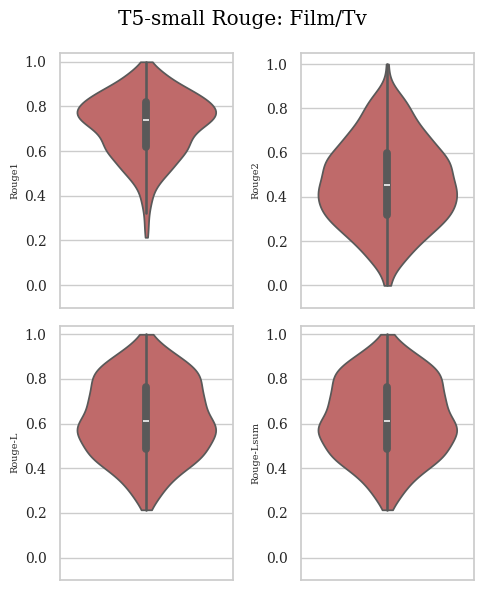

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_FilmTv_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_FilmTv_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_FilmTv_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_FilmTv_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-small Rouge: Film/Tv", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

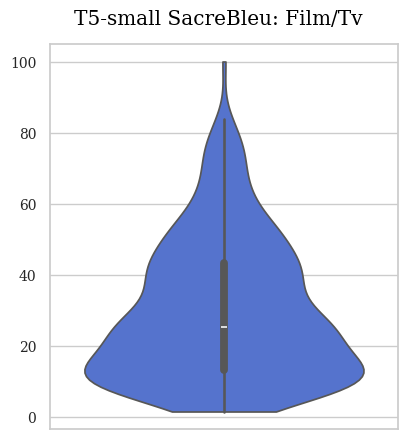

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_T5, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-small SacreBleu: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

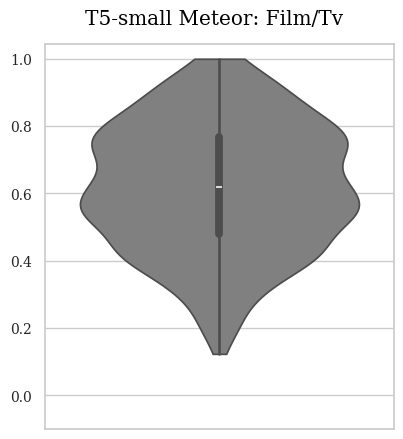

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_T5, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Demographics

In [ ]:
demographics = df_test[df_test['table_section_title'].isin(['Demographics'])]
demographics

Table to Text  \
26    Table page title: Arrow Point, Missouri, Table...   
42    Table page title: Calais, Table section title:...   
46    Table page title: Monument, Oregon, Table sect...   
52    Table page title: Seffner, Florida, Table sect...   
53    Table page title: Velda City, Missouri, Table ...   
...                                                 ...   
7673  Table page title: Cortland County, New York, T...   
7675  Table page title: Tarlac City, Table section t...   
7687  Table page title: Stinesville, Indiana, Table ...   
7688  Table page title: Wilson, St. Croix County, Wi...   
7695  Table page title: Hobart, Oklahoma, Table sect...   

                                              Anotation table_section_title  
26    As of the census of 2000, there were 133 peopl...        Demographics  
42    There was a massive growth in population of Ca...        Demographics  
46    As of the census of 2010, there were 128 peopl...        Demographics  
52    The population of Seffner was 7,579 at the 201...        Demographics  
53    As of the census of 2010, there were 1,420 peo...        Demographics  
...                                                 ...                 ...  
7673  As of the 2010 census, the population of Cortl...        Demographics  
7675  According to the 2015 census, Tarlac City has ...        Demographics  
7687  According to 2010 census, the population was 1...        Demographics  
7688  As of the census of 2010, there were 184 peopl...        Demographics  
7695       Hobart became the residence of 2,936 people.        Demographics  

[417 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

demographics_summaries_T5 = {}
for i, text in tqdm(enumerate(demographics['Table to Text']),total=len(demographics['Table to Text'])):
    text = "summarize: " + text
    demographics_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 417/417 [01:32<00:00,  4.53it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_demographics_bleu={}
T5_demographics_rouge={}
T5_demographics_meteor={}

for s in tqdm(demographics_summaries_T5.keys()):
  preds = [demographics_summaries_T5[s][0]['summary_text']]
  labels = [demographics['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_demographics_rouge[s]=score_r
  T5_demographics_bleu[s]=score_b
  T5_demographics_meteor[s]=score_m

100%|██████████| 417/417 [01:07<00:00,  6.14it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_demographics_rouge.keys():
  sum_r1+=T5_demographics_rouge[key]['rouge1']
  sum_r2+=T5_demographics_rouge[key]['rouge2']
  sum_rL+=T5_demographics_rouge[key]['rougeL']
  sum_rLsum+=T5_demographics_rouge[key]['rougeLsum']
  sumbleu+=T5_demographics_bleu[key]['score']
  sum_meteor+=T5_demographics_meteor[key]['meteor']

  r1_list.append(T5_demographics_rouge[key]['rouge1'])
  r2_list.append(T5_demographics_rouge[key]['rouge2'])
  rL_list.append(T5_demographics_rouge[key]['rougeL'])
  rLsum_list.append(T5_demographics_rouge[key]['rougeLsum'])
  bleu_list.append(T5_demographics_bleu[key]['score'])
  meteor_list.append(T5_demographics_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_demographics_rouge.keys())
avg_r2=sum_r2/len(T5_demographics_rouge.keys())
avg_rL=sum_rL/len(T5_demographics_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_demographics_rouge.keys())
avg_bleu=sumbleu/len(T5_demographics_bleu.keys())
avg_meteor=sum_meteor/len(T5_demographics_meteor.keys())

print(f"""---T5-small-Demographics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-small-Demographics-Domain---

        Average
Rouge-1: 0.7
Rouge-2: 0.49
Rouge-L: 0.59
Rouge-Lsum: 0.59
SacreBleu: 37.25
Meteor: 0.63

        Median
Rouge-1: 0.64
Rouge-2: 0.42
Rouge-L: 0.48
Rouge-Lsum: 0.48
SacreBleu: 21.34
Meteor: 0.61

    Standard Deviation
Rouge-1: 0.22
Rouge-2: 0.3
Rouge-L: 0.28
Rouge-Lsum: 0.28
SacreBleu: 30.96
Meteor: 0.25

  Minimum/Maximum
Rouge-1 | Min: 0.21 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.14 | Max: 1.0
Rouge-Lsum | Min: 0.14 | Max: 1.0
SacreBleu | Min: 0.25 | Max: 100.0
Meteor| Min: 0.11 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_dem_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_dem_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_dem_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_dem=[T5_dem_avg_all, T5_dem_median_all, T5_dem_sd_all]
for metric, metric_name in zip(metrics_T5_dem, ['T5_dem_avg_all', 'T5_dem_median_all', 'T5_dem_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_demographics_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_demographics_T5=pd.DataFrame(T5_demographics_metrics)
df_demographics_T5

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.962963  0.720000  0.888889    0.888889  70.212944  0.913208
1    0.421053  0.055556  0.210526    0.210526   2.425576  0.216450
2    0.916667  0.545455  0.833333    0.833333  45.613879  0.856086
3    0.350000  0.157895  0.300000    0.300000   9.560409  0.277100
4    0.933333  0.714286  0.866667    0.866667  56.058085  0.783176
..        ...       ...       ...         ...        ...       ...
412  0.666667  0.480000  0.518519    0.518519  38.503229  0.587589
413  0.666667  0.272727  0.416667    0.416667   9.024831  0.471419
414  0.521739  0.190476  0.434783    0.434783  14.949752  0.450893
415  0.960000  0.695652  0.880000    0.880000  67.711113  0.902616
416  0.636364  0.200000  0.454545    0.454545   6.917184  0.551255

[417 rows x 6 columns]

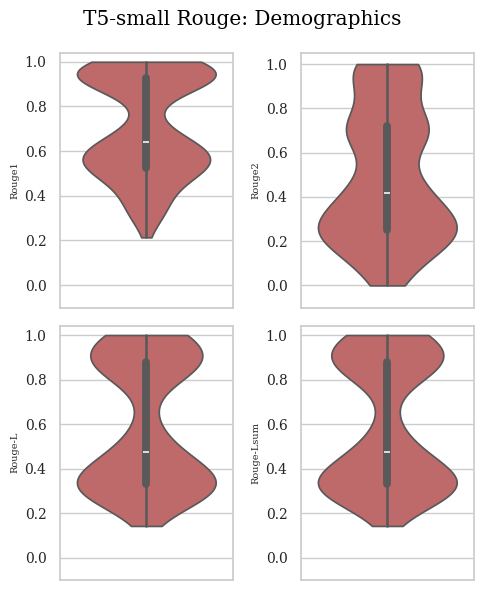

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_demographics_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_demographics_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_demographics_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_demographics_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-small Rouge: Demographics", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

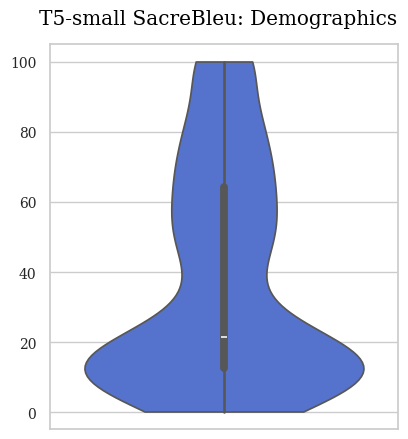

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_T5, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-small SacreBleu: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

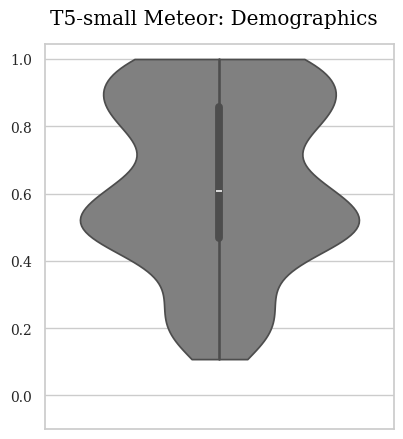

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_T5, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Blank

In [ ]:
Blank = df_test[df_test['table_section_title'].isin([''])]
Blank

Table to Text  \
10    Table page title: List of Argentine films of 1...   
23    Table page title: SEAT 1200 Sport, Table secti...   
50    Table page title: List of Deputy Speakers of t...   
125   Table page title: List of dance companies, Tab...   
137   Table page title: List of Malayalam films of 1...   
...                                                 ...   
7515  Table page title: List of flag bearers for Spa...   
7585  Table page title: Philadelphia Phillies all-ti...   
7596  Table page title: List of Malayalam films of 1...   
7625  Table page title: List of Indian states and un...   
7628  Table page title: List of presidents of the Co...   

                                              Anotation table_section_title  
10          "Don Fulgencio" is a 1950 Argentinian film.                      
23    4-cylinder-inline engine through a four-speed ...                      
50    Tobias Billström served as First Deputy Speake...                      
125   The Totem Dance group is one of Ukraine's cont...                      
137   Anuraagakkodathi is a 1982 Malayalam film dire...                      
...                                                 ...                 ...  
7515  Gasol was Spain's flag bearer at the 2012 Summ...                      
7585  George McQuillan recorded a 1.79 earned run av...                      
7596  Chandrakantham is a 1974 Malayalam film, direc...                      
7625  Goa ranks with least poverty of 5.09% while al...                      
7628  John Edwin Pomfret was the twentieth president...                      

[336 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

Blank_summaries_T5 = {}
for i, text in tqdm(enumerate(Blank['Table to Text']),total=len(Blank['Table to Text'])):
    text = "summarize: " + text[:10000]
    Blank_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 336/336 [01:32<00:00,  3.64it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_Blank_bleu={}
T5_Blank_rouge={}
T5_Blank_meteor={}

for s in tqdm(Blank_summaries_T5.keys()):
  preds = [Blank_summaries_T5[s][0]['summary_text']]
  labels = [Blank['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_Blank_rouge[s]=score_r
  T5_Blank_bleu[s]=score_b
  T5_Blank_meteor[s]=score_m

100%|██████████| 336/336 [00:55<00:00,  6.11it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_Blank_rouge.keys():
  sum_r1+=T5_Blank_rouge[key]['rouge1']
  sum_r2+=T5_Blank_rouge[key]['rouge2']
  sum_rL+=T5_Blank_rouge[key]['rougeL']
  sum_rLsum+=T5_Blank_rouge[key]['rougeLsum']
  sumbleu+=T5_Blank_bleu[key]['score']
  sum_meteor+=T5_Blank_meteor[key]['meteor']

  r1_list.append(T5_Blank_rouge[key]['rouge1'])
  r2_list.append(T5_Blank_rouge[key]['rouge2'])
  rL_list.append(T5_Blank_rouge[key]['rougeL'])
  rLsum_list.append(T5_Blank_rouge[key]['rougeLsum'])
  bleu_list.append(T5_Blank_bleu[key]['score'])
  meteor_list.append(T5_Blank_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_Blank_rouge.keys())
avg_r2=sum_r2/len(T5_Blank_rouge.keys())
avg_rL=sum_rL/len(T5_Blank_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_Blank_rouge.keys())
avg_bleu=sumbleu/len(T5_Blank_bleu.keys())
avg_meteor=sum_meteor/len(T5_Blank_meteor.keys())

print(f"""---T5-small-Blank-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-small-Blank-Domain---

        Average
Rouge-1: 0.56
Rouge-2: 0.37
Rouge-L: 0.51
Rouge-Lsum: 0.51
SacreBleu: 24.62
Meteor: 0.51

        Median
Rouge-1: 0.56
Rouge-2: 0.33
Rouge-L: 0.48
Rouge-Lsum: 0.48
SacreBleu: 16.59
Meteor: 0.51

    Standard Deviation
Rouge-1: 0.22
Rouge-2: 0.26
Rouge-L: 0.23
Rouge-Lsum: 0.23
SacreBleu: 22.72
Meteor: 0.24

  Minimum/Maximum
Rouge-1 | Min: 0.0 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.0 | Max: 1.0
Rouge-Lsum | Min: 0.0 | Max: 1.0
SacreBleu | Min: 0.29 | Max: 100.0
Meteor| Min: 0.05 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_blank_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_blank_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_blank_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_blank=[T5_blank_avg_all, T5_blank_median_all, T5_blank_sd_all]
for metric, metric_name in zip(metrics_T5_blank, ['T5_blank_avg_all', 'T5_blank_median_all', 'T5_blank_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_blank_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_blank_T5=pd.DataFrame(T5_blank_metrics)
df_blank_T5

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.714286  0.333333  0.714286    0.714286  14.898574  0.573980
1    0.500000  0.263158  0.300000    0.300000  13.630754  0.331294
2    0.500000  0.444444  0.500000    0.500000  46.777665  0.549185
3    0.428571  0.153846  0.357143    0.357143  10.123735  0.427201
4    0.736842  0.705882  0.736842    0.736842  59.004687  0.785891
..        ...       ...       ...         ...        ...       ...
331  0.666667  0.210526  0.380952    0.380952  11.016798  0.526042
332  0.210526  0.000000  0.105263    0.105263   2.207512  0.144033
333  0.636364  0.600000  0.636364    0.636364  29.256127  0.643724
334  0.538462  0.166667  0.538462    0.538462   6.507499  0.258065
335  0.888889  0.800000  0.888889    0.888889  68.650651  0.922591

[336 rows x 6 columns]

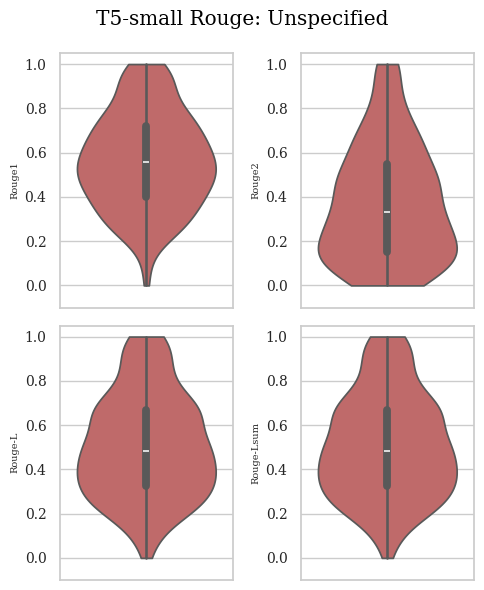

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_blank_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_blank_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_blank_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_blank_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-small Rouge: Unspecified", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

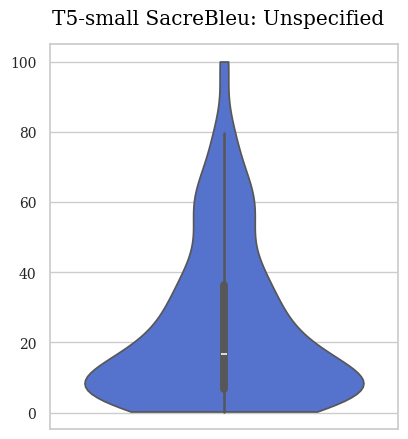

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_T5, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-small SacreBleu: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

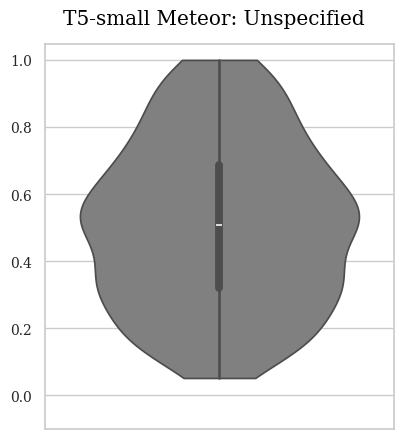

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_T5, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: MMA Record

In [ ]:
MMA = df_test[df_test['table_section_title'].isin(['Mixed martial arts record'])]
MMA

Table to Text  \
61    Table page title: Liz Carmouche, Table section...   
65    Table page title: Sam Sicilia, Table section t...   
133   Table page title: Hakeem Dawodu, Table section...   
165   Table page title: Neiman Gracie, Table section...   
292   Table page title: John Howard (fighter), Table...   
...                                                 ...   
7379  Table page title: Alexa Conners, Table section...   
7415  Table page title: Brandon Girtz, Table section...   
7422  Table page title: Efrain Escudero, Table secti...   
7474  Table page title: Martin Kampmann, Table secti...   
7605  Table page title: Jake Butler, Table section t...   

                                              Anotation  \
61    On July 22, 2011, Carmouche faced Sarah Kaufma...   
65    Sicilia of the featherweight division, faced R...   
133   On December 18, 2015, Dawodu faced Marat Magom...   
165   Gracie faced Roger Carroll at Bellator 151 on ...   
292   Howard faced Thiago Alves on December 11, 2010...   
...                                                 ...   
7379  Conners faced Katharina Lehner on August 31, 2...   
7415  Girtz faced Derek Campos at Bellator 146 on No...   
7422  Efrain fought against Akhmet Aliev at Fight Ni...   
7474  Kampmann faced Jake Shields on October 23, 201...   
7605  Butler faced Sylvain Potard at ONE FC: Warrior...   

            table_section_title  
61    Mixed martial arts record  
65    Mixed martial arts record  
133   Mixed martial arts record  
165   Mixed martial arts record  
292   Mixed martial arts record  
...                         ...  
7379  Mixed martial arts record  
7415  Mixed martial arts record  
7422  Mixed martial arts record  
7474  Mixed martial arts record  
7605  Mixed martial arts record  

[158 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

MMA_summaries_T5 = {}
for i, text in tqdm(enumerate(MMA['Table to Text']),total=len(MMA['Table to Text'])):
    text = "summarize: " + text
    MMA_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 158/158 [00:44<00:00,  3.59it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_MMA_bleu={}
T5_MMA_rouge={}
T5_MMA_meteor={}

for s in tqdm(MMA_summaries_T5.keys()):
  preds = [MMA_summaries_T5[s][0]['summary_text']]
  labels = [MMA['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_MMA_rouge[s]=score_r
  T5_MMA_bleu[s]=score_b
  T5_MMA_meteor[s]=score_m

100%|██████████| 158/158 [00:25<00:00,  6.13it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_MMA_rouge.keys():
  sum_r1+=T5_MMA_rouge[key]['rouge1']
  sum_r2+=T5_MMA_rouge[key]['rouge2']
  sum_rL+=T5_MMA_rouge[key]['rougeL']
  sum_rLsum+=T5_MMA_rouge[key]['rougeLsum']
  sumbleu+=T5_MMA_bleu[key]['score']
  sum_meteor+=T5_MMA_meteor[key]['meteor']

  r1_list.append(T5_MMA_rouge[key]['rouge1'])
  r2_list.append(T5_MMA_rouge[key]['rouge2'])
  rL_list.append(T5_MMA_rouge[key]['rougeL'])
  rLsum_list.append(T5_MMA_rouge[key]['rougeLsum'])
  bleu_list.append(T5_MMA_bleu[key]['score'])
  meteor_list.append(T5_MMA_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_MMA_rouge.keys())
avg_r2=sum_r2/len(T5_MMA_rouge.keys())
avg_rL=sum_rL/len(T5_MMA_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_MMA_rouge.keys())
avg_bleu=sumbleu/len(T5_MMA_bleu.keys())
avg_meteor=sum_meteor/len(T5_MMA_meteor.keys())

print(f"""---T5-small-MMA Record-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-small-MMA Record-Domain---

        Average
Rouge-1: 0.84
Rouge-2: 0.7
Rouge-L: 0.71
Rouge-Lsum: 0.71
SacreBleu: 54.75
Meteor: 0.78

        Median
Rouge-1: 0.86
Rouge-2: 0.73
Rouge-L: 0.7
Rouge-Lsum: 0.7
SacreBleu: 52.71
Meteor: 0.8

    Standard Deviation
Rouge-1: 0.15
Rouge-2: 0.22
Rouge-L: 0.21
Rouge-Lsum: 0.21
SacreBleu: 24.99
Meteor: 0.18

  Minimum/Maximum
Rouge-1 | Min: 0.51 | Max: 1.0
Rouge-2 | Min: 0.14 | Max: 1.0
Rouge-L | Min: 0.26 | Max: 1.0
Rouge-Lsum | Min: 0.26 | Max: 1.0
SacreBleu | Min: 6.82 | Max: 100.0
Meteor| Min: 0.34 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_mma_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_mma_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_mma_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_mma=[T5_mma_avg_all, T5_mma_median_all, T5_mma_sd_all]
for metric, metric_name in zip(metrics_T5_mma, ['T5_mma_avg_all', 'T5_mma_median_all', 'T5_mma_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_mma_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_mma_T5=pd.DataFrame(T5_mma_metrics)
df_mma_T5

Rouge1    Rouge2   Rouge-L  Rouge-Lsum   SacreBleu    Meteor
0    0.848485  0.709677  0.606061    0.606061   44.383283  0.677958
1    0.769231  0.500000  0.769231    0.769231   47.393029  0.673016
2    0.956522  0.761905  0.608696    0.608696   53.335054  0.902156
3    0.956522  0.761905  0.695652    0.695652   54.413074  0.977912
4    1.000000  1.000000  1.000000    1.000000   78.819297  0.921630
..        ...       ...       ...         ...         ...       ...
153  0.740741  0.640000  0.740741    0.740741   47.976956  0.630284
154  1.000000  0.800000  0.727273    0.727273   59.188219  0.985435
155  0.551724  0.444444  0.551724    0.551724   28.384916  0.411269
156  1.000000  1.000000  1.000000    1.000000  100.000000  0.999772
157  0.962963  0.720000  0.666667    0.666667   55.685441  0.932299

[158 rows x 6 columns]

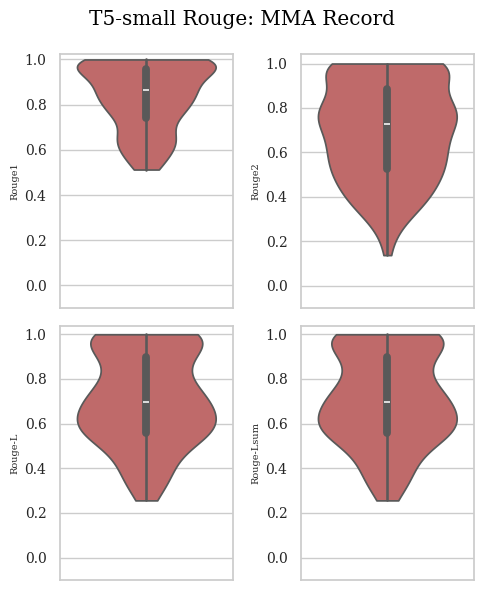

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_mma_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_mma_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_mma_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_mma_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.suptitle("T5-small Rouge: MMA Record", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

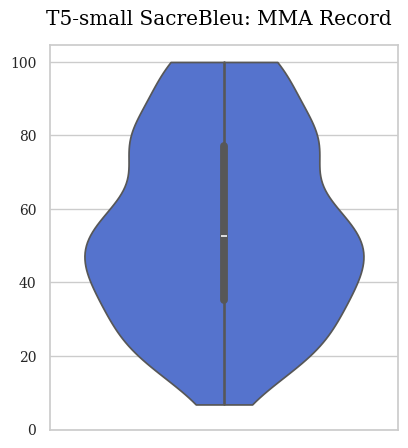

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_T5, y="SacreBleu", color="royalblue", cut=0)
ax.set_ylim(bottom=-0.1)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-small SacreBleu: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

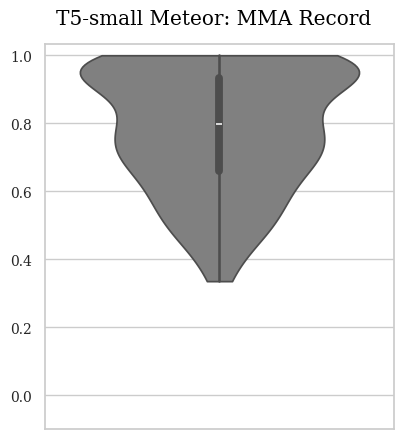

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_T5, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Career Statistics

In [ ]:
cs = df_test[df_test['table_section_title'].isin(['Career statistics'])]
cs

Table to Text  \
2     Table page title: A. J. Hawk, Table section ti...   
98    Table page title: Scott Campbell (ice hockey, ...   
146   Table page title: Ryan Mathews (American footb...   
158   Table page title: Reggie Bush, Table section t...   
171   Table page title: Dwayne Zinger, Table section...   
...                                                 ...   
7323  Table page title: Mark Greaves, Table section ...   
7336  Table page title: Chad Costello, Table section...   
7471  Table page title: Nils-Eric Johansson, Table s...   
7539  Table page title: Barry Salvage, Table section...   
7615  Table page title: Yohan Betsch, Table section ...   

                                              Anotation table_section_title  
2     In his rookie season, Hawk led with 119 total ...   Career statistics  
98    Campbell played 149 WHA games for the Aeros an...   Career statistics  
146   Mathews of Philadelphia Eagles finished the 20...   Career statistics  
158   Reggie Bush finished with 297 rushing yards an...   Career statistics  
171   Zinger moved to the Cincinnati Cyclones of the...   Career statistics  
...                                                 ...                 ...  
7323  Mark Greaves made 175 appearances and scored f...   Career statistics  
7336  Chad Costello scored 125 points in 72 games in...   Career statistics  
7471  In 1999–00, Nils-Eric Johansson participated i...   Career statistics  
7539  In 1977, Salvage moved to North American Socce...   Career statistics  
7615  Betsch was at Metz in the 2011–12 season, then...   Career statistics  

[152 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

cs_summaries_T5 = {}
for i, text in tqdm(enumerate(cs['Table to Text']),total=len(cs['Table to Text'])):
    text = "summarize: " + text
    cs_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 152/152 [00:37<00:00,  4.06it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_cs_bleu={}
T5_cs_rouge={}
T5_cs_meteor={}

for s in tqdm(cs_summaries_T5.keys()):
  preds = [cs_summaries_T5[s][0]['summary_text']]
  labels = [cs['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_cs_rouge[s]=score_r
  T5_cs_bleu[s]=score_b
  T5_cs_meteor[s]=score_m

100%|██████████| 152/152 [00:24<00:00,  6.18it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_cs_rouge.keys():
  sum_r1+=T5_cs_rouge[key]['rouge1']
  sum_r2+=T5_cs_rouge[key]['rouge2']
  sum_rL+=T5_cs_rouge[key]['rougeL']
  sum_rLsum+=T5_cs_rouge[key]['rougeLsum']
  sumbleu+=T5_cs_bleu[key]['score']
  sum_meteor+=T5_cs_meteor[key]['meteor']

  r1_list.append(T5_cs_rouge[key]['rouge1'])
  r2_list.append(T5_cs_rouge[key]['rouge2'])
  rL_list.append(T5_cs_rouge[key]['rougeL'])
  rLsum_list.append(T5_cs_rouge[key]['rougeLsum'])
  bleu_list.append(T5_cs_bleu[key]['score'])
  meteor_list.append(T5_cs_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_cs_rouge.keys())
avg_r2=sum_r2/len(T5_cs_rouge.keys())
avg_rL=sum_rL/len(T5_cs_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_cs_rouge.keys())
avg_bleu=sumbleu/len(T5_cs_bleu.keys())
avg_meteor=sum_meteor/len(T5_cs_meteor.keys())

print(f"""---T5-small-Career Statistics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-small-Career Statistics-Domain---

        Average
Rouge-1: 0.58
Rouge-2: 0.29
Rouge-L: 0.44
Rouge-Lsum: 0.44
SacreBleu: 14.89
Meteor: 0.45

        Median
Rouge-1: 0.62
Rouge-2: 0.3
Rouge-L: 0.44
Rouge-Lsum: 0.44
SacreBleu: 11.57
Meteor: 0.46

    Standard Deviation
Rouge-1: 0.18
Rouge-2: 0.18
Rouge-L: 0.15
Rouge-Lsum: 0.15
SacreBleu: 11.5
Meteor: 0.19

  Minimum/Maximum
Rouge-1 | Min: 0.16 | Max: 0.9
Rouge-2 | Min: 0.0 | Max: 0.9
Rouge-L | Min: 0.11 | Max: 0.9
Rouge-Lsum | Min: 0.11 | Max: 0.9
SacreBleu | Min: 0.88 | Max: 68.87
Meteor| Min: 0.09 | Max: 0.84




In [ ]:
#put all averages in a dictionary
T5_cs_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_cs_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_cs_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_cs=[T5_cs_avg_all, T5_cs_median_all, T5_cs_sd_all]
for metric, metric_name in zip(metrics_T5_cs, ['T5_cs_avg_all', 'T5_cs_median_all', 'T5_cs_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_cs_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_cs_T5=pd.DataFrame(T5_cs_metrics)
df_cs_T5

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.285714  0.000000  0.285714    0.285714   3.929719  0.206612
1    0.769231  0.416667  0.615385    0.615385  15.840268  0.667992
2    0.410256  0.054054  0.256410    0.256410   1.635877  0.181818
3    0.476190  0.105263  0.476190    0.476190   9.007468  0.481050
4    0.640000  0.347826  0.480000    0.480000  16.180555  0.382756
..        ...       ...       ...         ...        ...       ...
147  0.428571  0.300000  0.333333    0.333333  11.944410  0.243206
148  0.470588  0.133333  0.470588    0.470588  11.351147  0.416822
149  0.720000  0.347826  0.560000    0.560000  20.200107  0.731148
150  0.714286  0.384615  0.428571    0.428571  31.007120  0.669367
151  0.562500  0.200000  0.312500    0.312500   9.128198  0.501124

[152 rows x 6 columns]

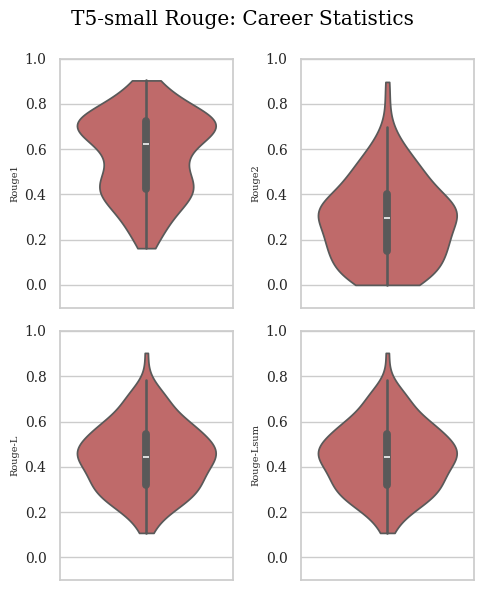

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_cs_T5, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_cs_T5, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_cs_T5, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_cs_T5, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1, top=1)


plt.suptitle("T5-small Rouge: Career Statistics", fontdict=title_font, y=0.98)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

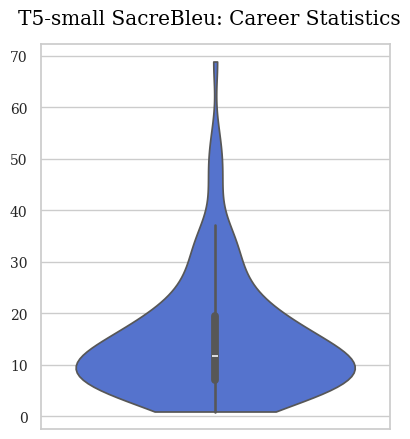

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_cs_T5, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-small SacreBleu: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

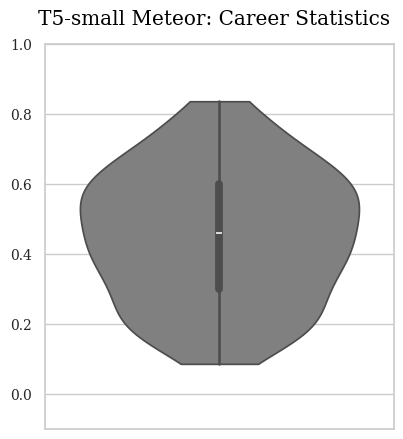

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_cs_T5, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1,top=1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-small Meteor: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Results - Plots Combo

In [ ]:
files=['/content/T5_All_avg_all.pkl','/content/T5_All_median_all.pkl','/content/T5_All_sd_all.pkl',
       '/content/T5_FilmTv_avg_all.pkl','/content/T5_FilmTv_median_all.pkl','/content/T5_FilmTv_sd_all.pkl',
       '/content/T5_blank_avg_all.pkl','/content/T5_blank_median_all.pkl','/content/T5_blank_sd_all.pkl',
       '/content/T5_cs_avg_all.pkl','/content/T5_cs_median_all.pkl','/content/T5_cs_sd_all.pkl',
       '/content/T5_dem_avg_all.pkl','/content/T5_dem_median_all.pkl','/content/T5_dem_sd_all.pkl',
       '/content/T5_mma_avg_all.pkl','/content/T5_mma_median_all.pkl','/content/T5_mma_sd_all.pkl']

metrics={}
for i in range(len(files)):
  with open(files[i], 'rb') as file:
      metrics[i] = pickle.load(file)

In [ ]:
avg_all=metrics[0]
median_all=metrics[1]
sd_all=metrics[2]
avg_FilmTv=metrics[3]
median_FilmTv=metrics[4]
sd_FilmTv=metrics[5]
avg_blank=metrics[6]
median_blank=metrics[7]
sd_blank=metrics[8]
avg_cs=metrics[9]
median_cs=metrics[10]
sd_cs=metrics[11]
avg_dem=metrics[12]
median_dem=metrics[13]
sd_dem=metrics[14]
avg_mma=metrics[15]
median_mma=metrics[16]
sd_mma=metrics[17]

In [ ]:
print('-----------------------------------------T5-Average-------------------------------------------')
avg_dataframe=pd.DataFrame(avg_all.keys(),index=range(len(avg_all.keys())),columns=['Metric'])
avg_dataframe['All Domains']=avg_all.values()
avg_dataframe['Career Statistics']=avg_cs.values()
avg_dataframe['Demographics']=avg_dem.values()
avg_dataframe['Film/Tv']=avg_FilmTv.values()
avg_dataframe['MMA Record']=avg_mma.values()
avg_dataframe['Unspecified']=avg_blank.values()
avg_dataframe

-----------------------------------------T5-Average-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.57               0.58          0.70     0.72   
1      Rouge2         0.34               0.29          0.49     0.46   
2     Rouge-L         0.48               0.44          0.59     0.62   
3  Rouge-Lsum         0.48               0.44          0.59     0.62   
4   SacreBleu        21.00              14.89         37.25    29.81   
5      Meteor         0.49               0.45          0.63     0.62   

   MMA Record  Unspecified  
0        0.84         0.56  
1        0.70         0.37  
2        0.71         0.51  
3        0.71         0.51  
4       54.75        24.62  
5        0.78         0.51

In [ ]:
print('----------------------------------------T5-Median-------------------------------------------')
median_dataframe=pd.DataFrame(median_all.keys(),index=range(len(median_all.keys())),columns=['Metric'])
median_dataframe['All Domains']=median_all.values()
median_dataframe['Career Statistics']=median_cs.values()
median_dataframe['Demographics']=median_dem.values()
median_dataframe['Film/Tv']=median_FilmTv.values()
median_dataframe['MMA Record']=median_mma.values()
median_dataframe['Unspecified']=median_blank.values()
median_dataframe

----------------------------------------T5-Median-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.57               0.62          0.64     0.74   
1      Rouge2         0.31               0.30          0.42     0.45   
2     Rouge-L         0.45               0.44          0.48     0.61   
3  Rouge-Lsum         0.45               0.44          0.48     0.61   
4   SacreBleu        14.29              11.57         21.34    25.37   
5      Meteor         0.48               0.46          0.61     0.62   

   MMA Record  Unspecified  
0        0.86         0.56  
1        0.73         0.33  
2        0.70         0.48  
3        0.70         0.48  
4       52.71        16.59  
5        0.80         0.51

In [ ]:
print('-----------------------------------T5-Standard Deviation------------------------------------')
sd_dataframe=pd.DataFrame(sd_all.values(),index=sd_all.keys(),columns=['All Domains'])
sd_dataframe['Career Statistics']=sd_cs.values()
sd_dataframe['Demographics']=sd_dem.values()
sd_dataframe['Film/Tv']=sd_FilmTv.values()
sd_dataframe['MMA Record']=sd_mma.values()
sd_dataframe['Unspecified']=sd_blank.values()
sd_dataframe

-----------------------------------T5-Standard Deviation------------------------------------


All Domains  Career Statistics  Demographics  Film/Tv  MMA Record  \
Rouge1             0.20               0.18          0.22     0.14        0.15   
Rouge2             0.23               0.18          0.30     0.19        0.22   
Rouge-L            0.21               0.15          0.28     0.17        0.21   
Rouge-Lsum         0.21               0.15          0.28     0.17        0.21   
SacreBleu         19.56              11.50         30.96    19.83       24.99   
Meteor             0.22               0.19          0.25     0.19        0.18   

            Unspecified  
Rouge1             0.22  
Rouge2             0.26  
Rouge-L            0.23  
Rouge-Lsum         0.23  
SacreBleu         22.72  
Meteor             0.24

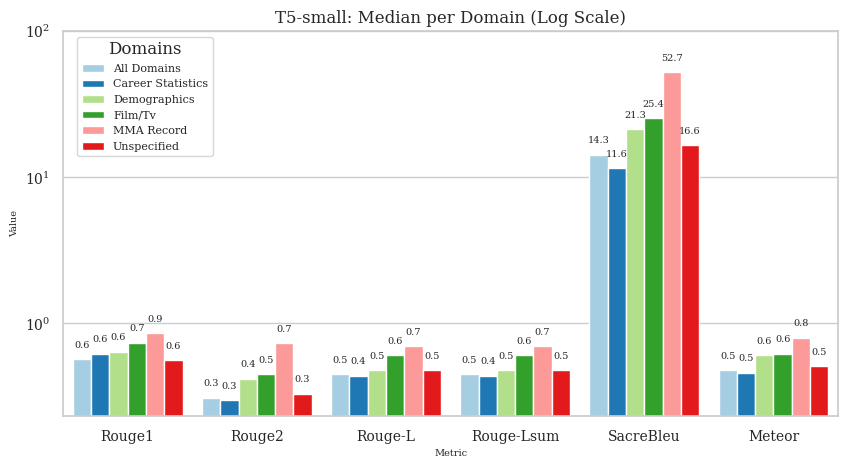

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(median_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=1,width=0.85)

plt.title("T5-small: Median per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10



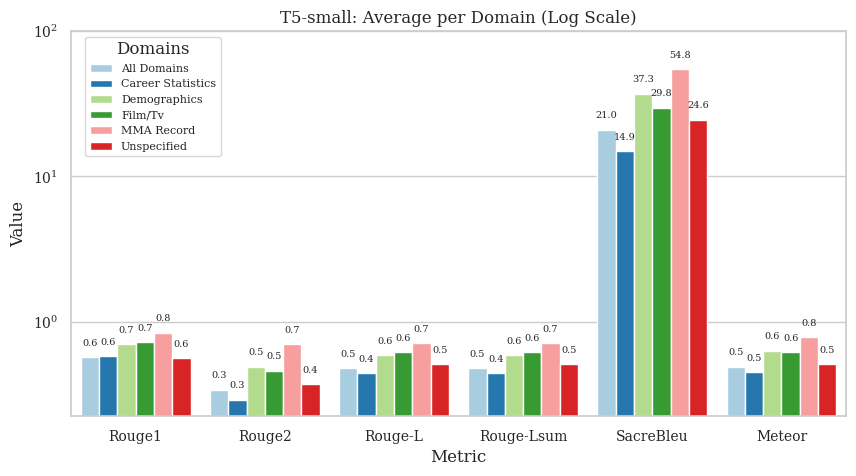

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(avg_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)

plt.title("T5-small: Average per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10



In [ ]:
df_T5['Domain'] = 'All'
df_FilmTv_T5['Domain'] = 'Film/Tv'
df_demographics_T5['Domain'] = 'Demographics'
df_blank_T5['Domain'] = 'Unspecified'
df_mma_T5['Domain'] = 'MMA Record'
df_cs_T5['Domain'] = 'Career Statistics'

combined_df = pd.concat([df_T5, df_FilmTv_T5,df_demographics_T5,df_blank_T5,df_mma_T5,df_cs_T5])
combined_df['Domain'] = pd.Categorical(combined_df['Domain'], ordered=True)
combined_df

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor  \
0    0.769231  0.500000  0.769231    0.769231  34.460734  0.807183   
1    0.636364  0.400000  0.545455    0.545455  22.825471  0.547445   
2    0.285714  0.000000  0.285714    0.285714   3.929719  0.206612   
3    0.322581  0.137931  0.193548    0.193548   9.917721  0.157895   
4    0.689655  0.592593  0.689655    0.689655  53.016463  0.712949   
..        ...       ...       ...         ...        ...       ...   
147  0.428571  0.300000  0.333333    0.333333  11.944410  0.243206   
148  0.470588  0.133333  0.470588    0.470588  11.351147  0.416822   
149  0.720000  0.347826  0.560000    0.560000  20.200107  0.731148   
150  0.714286  0.384615  0.428571    0.428571  31.007120  0.669367   
151  0.562500  0.200000  0.312500    0.312500   9.128198  0.501124   

                Domain  
0                  All  
1                  All  
2                  All  
3                  All  
4                  All  
..                 ...  
147  Career Statistics  
148  Career Statistics  
149  Career Statistics  
150  Career Statistics  
151  Career Statistics  

[9363 rows x 7 columns]

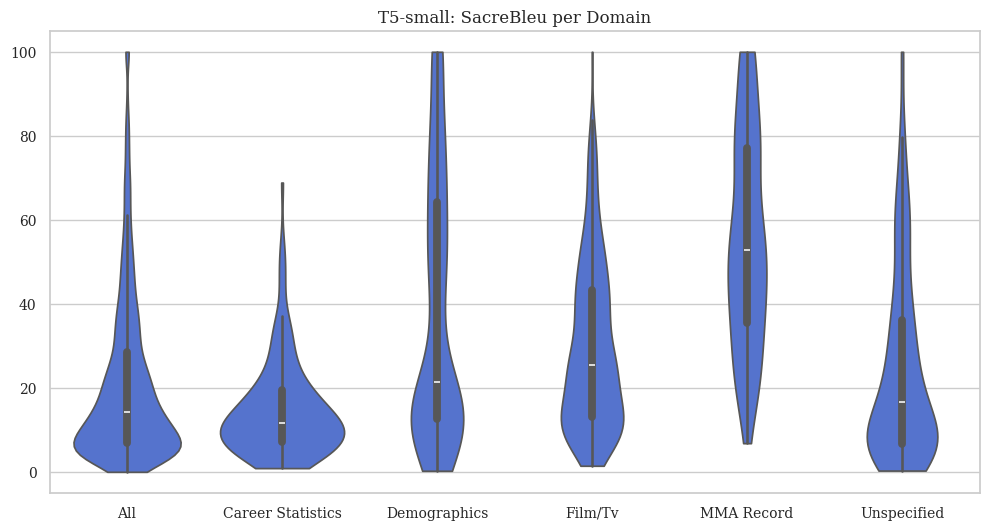

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="SacreBleu", data=combined_df, color="royalblue",cut=0)
plt.title("T5-small: SacreBleu per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

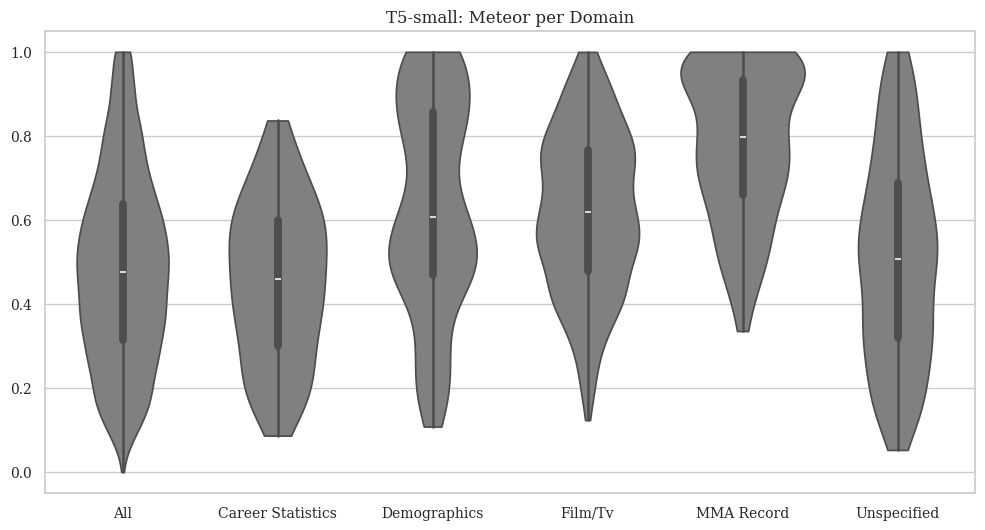

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="Meteor", data=combined_df, color="gray",cut=0)
plt.title("T5-small: Meteor per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

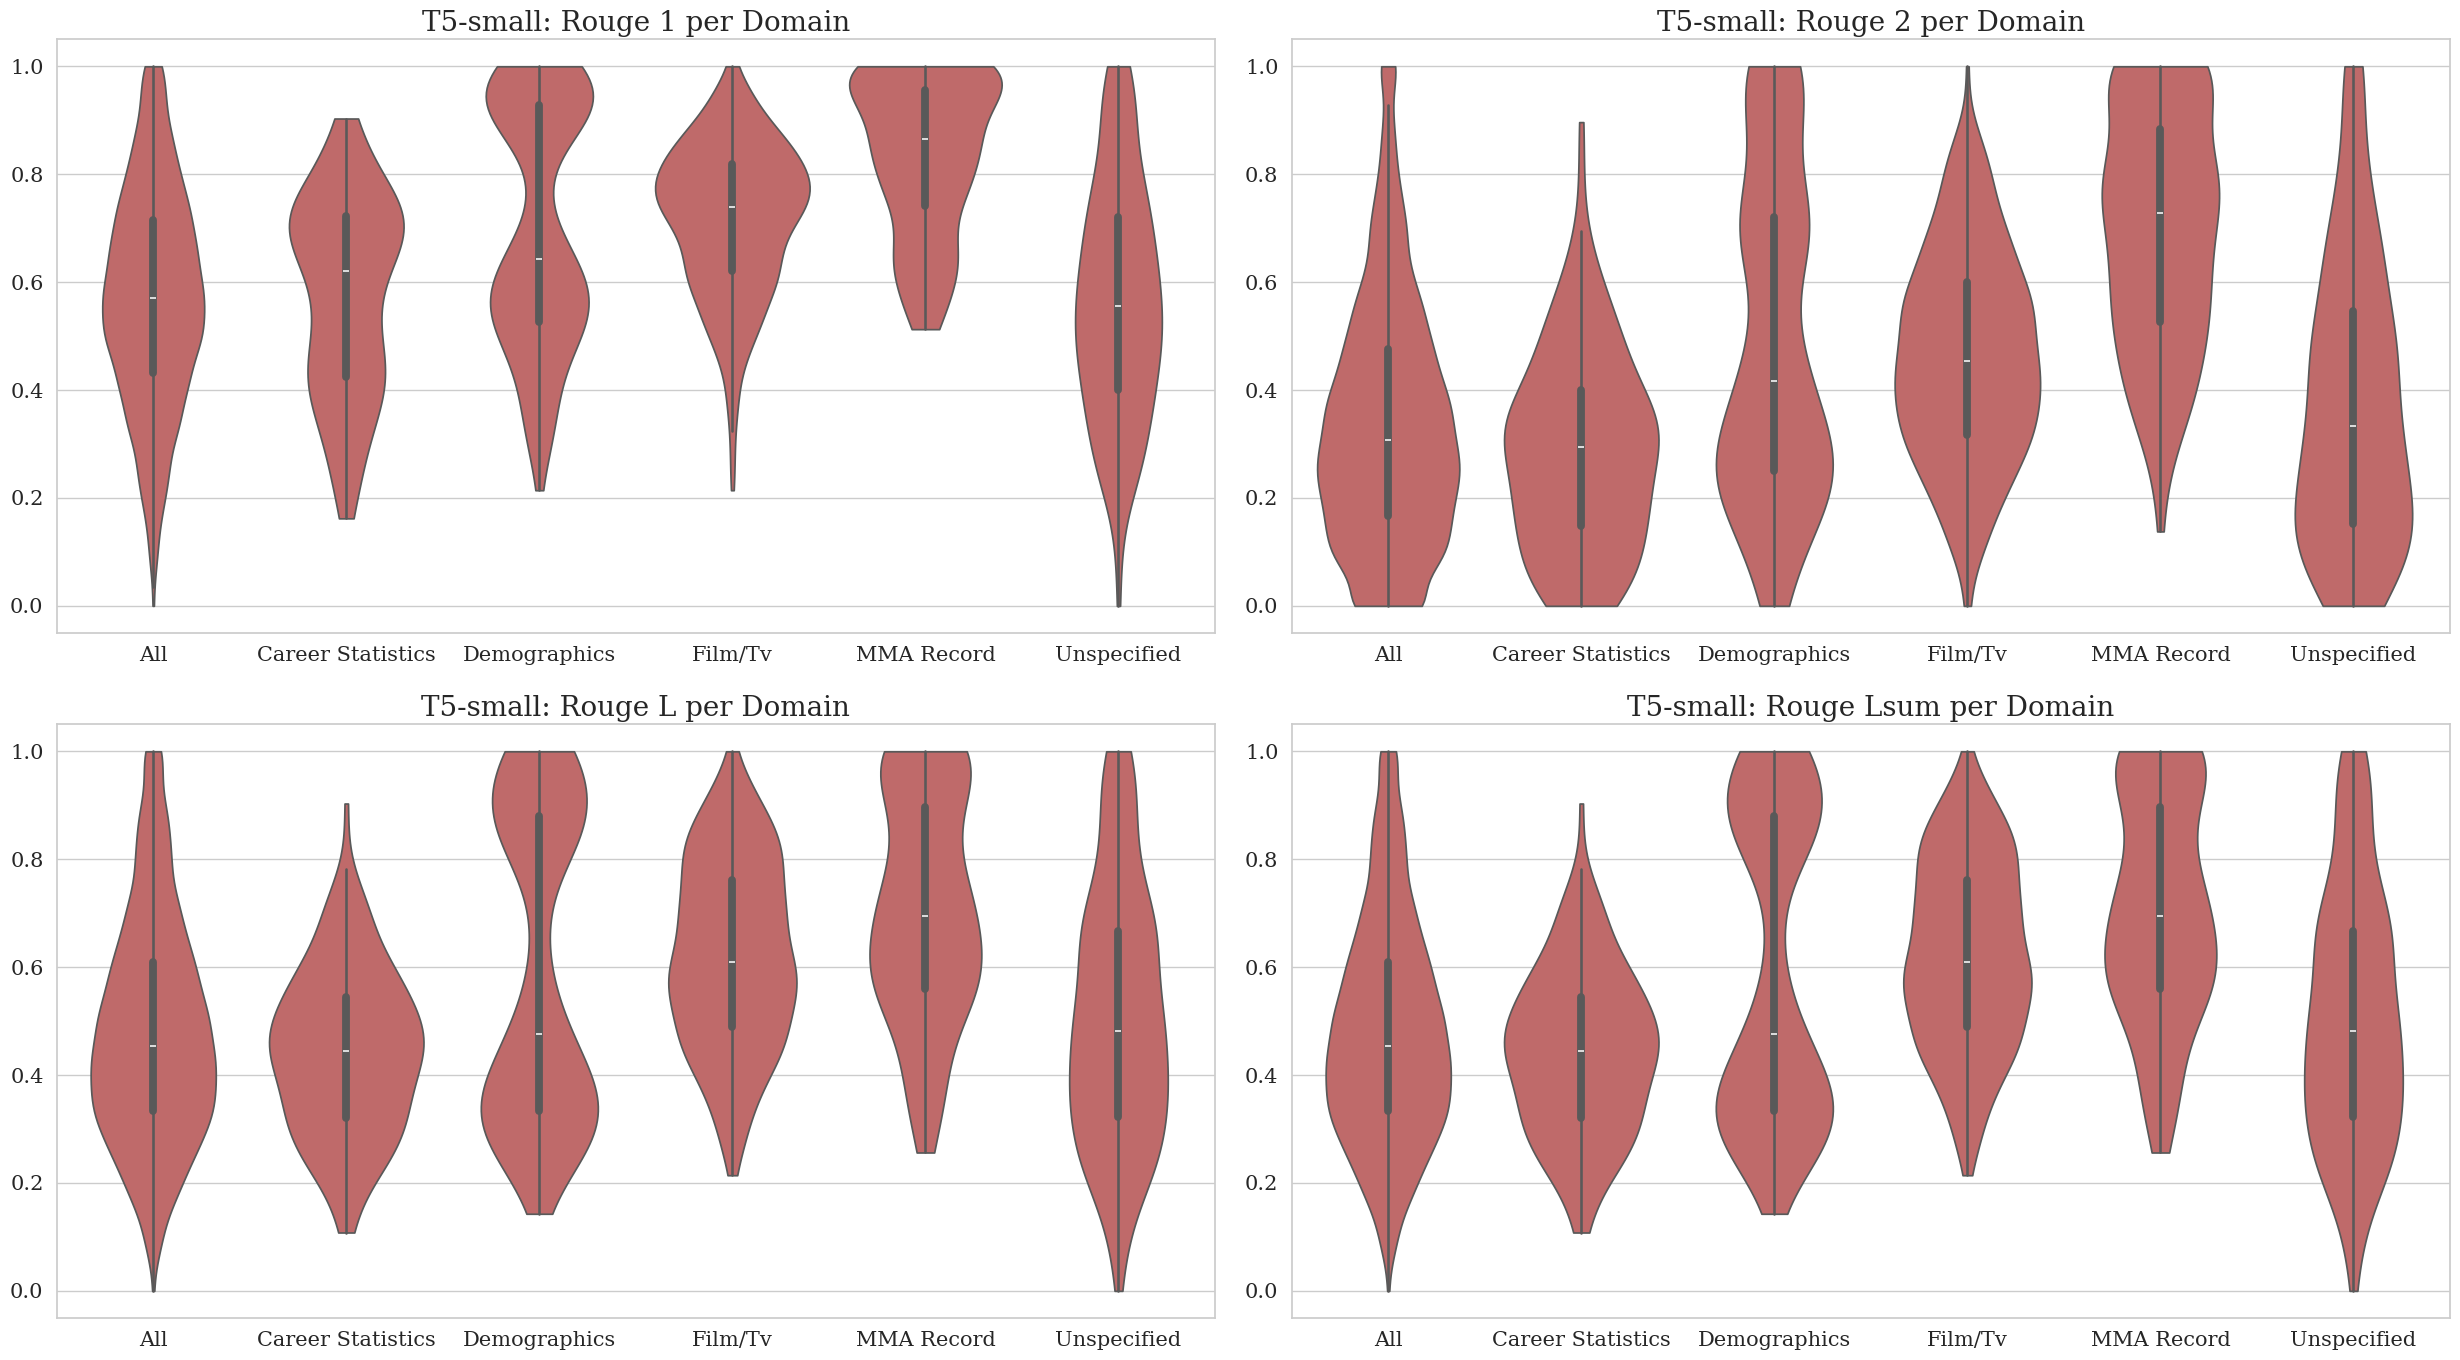

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the global style for the plots
sns.set(style="whitegrid")

# Set the font properties
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

# Create a trellis plot with two violinplots
plt.figure(figsize=(25, 14))

# Plot for Rouge1
plt.subplot(2, 2, 1)
sns.violinplot(x="Domain", y="Rouge1", data=combined_df, color="indianred",cut=0)
plt.title("T5-small: Rouge 1 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for Rouge2
plt.subplot(2, 2, 2)
sns.violinplot(x="Domain", y="Rouge2", data=combined_df, color="indianred",cut=0)
plt.title("T5-small: Rouge 2 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeL
plt.subplot(2, 2, 3)
sns.violinplot(x="Domain", y="Rouge-L", data=combined_df, color="indianred",cut=0)
plt.title("T5-small: Rouge L per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeLsum
plt.subplot(2, 2, 4)
sns.violinplot(x="Domain", y="Rouge-Lsum", data=combined_df, color="indianred",cut=0)
plt.title("T5-small: Rouge Lsum per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


##**T5-base**
--------------------------------------------------------------------------------


In [ ]:
del df_train['table_section_title'], df_test['table_section_title'],df_val['table_section_title']

In [ ]:
df_train

Table to Text  \
0      Table page title: List of Commanders of the Tu...   
1      Table page title: List of Presidents of the Ch...   
2      Table page title: List of districts of Istanbu...   
3      Table page title: List of largest California c...   
4      Table page title: List of Irish state funerals...   
...                                                  ...   
23645  Table page title: List of kings of Connacht, T...   
23646  Table page title: List of Belgrade neighbourho...   
23647  Table page title: List of Belgrade neighbourho...   
23648  Table page title: Yelena Isinbayeva, Table sec...   
23649  Table page title: Yelena Isinbayeva, Table sec...   

                                               Anotation  
0      Doğan Güreş was a Commander of the Turkish Arm...  
1      In February 1985, Antonio Marchesano was Presi...  
2                Büyükçekmece is a district of Istanbul.  
3      Bakersfield's population makes it the 9th-most...  
4      President Erskine Childers died in office in 1...  
...                                                  ...  
23645  Fedlim Geancach Ó Conchobair was the son of To...  
23646    Čukarička padina is a neighborhood of Belgrade.  
23647      Careva Ćuprija is a neighborhood of Belgrade.  
23648  Yelena Isinbayeva appeared in 1998 World Junio...  
23649  Isinbayeva won gold at the 2003 European Under...  

[23650 rows x 2 columns]

In [ ]:
df_train['Table to Text'].iloc[9008]

'Table page title: Mark Patton, Table section title: Film, Table section text: , Table converted to text: Year is 1982, Title is Come Back to the Five and Dime, Jimmy Dean, Jimmy Dean, Role is Joe Qualley, Notes is Feature film. Year is 1982, Title is Anna to the Infinite Power, Role is Rowan Hart, Notes is Feature film. Year is 1985, Title is A Nightmare on Elm Street 2: Freddys Revenge, Role is Jesse Walsh, Notes is Feature film. Year is 2003, Title is Freddy vs. Jason, Role is Jesse Walsh, Notes is Archive footage, special thanks. Year is 2010, Title is Never Sleep Again: The Elm Street Legacy, Role is Himself, Notes is Documentary. Year is 2016, Title is Family Possessions, Role is Tyson, Notes is Feature film. Year is 2017, Title is Amityville: Evil Never Dies, Role is James, Notes is Feature film, Focus on: 1985 A Nightmare on Elm Street 2: Freddys Revenge Jesse Walsh, Table Structure: 8 rows, 4 columns.'

### Preprocess

In [ ]:
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens hav

The preprocessing function below:


1.   Prepends the string "summarize: " to each document in the 'text' field of the input examples to instruct the T5 model on the task it needs to perform.
2.   Tokenizes the prepended input texts to convert them into a format that can be fed into the model. Then, sets a maximum token length of 1024, and truncates any text longer than this limit.
3. Tokenizes the 'summary' field of the input examples to prepare the target labels for the summarization task. Next, a maximum token length of 128 is being set, and any text longer than this limit gets truncated.
4. The tokenized labels are assigned to the 'labels' field of model_inputs which is used during training to calculate the loss and guide model learning.


In [ ]:
def preprocess_function(ex):
    inputs = ["summarize: " + doc for doc in ex["Table to Text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=ex["Anotation"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
#Turning dataframes into HF objects
#!pip install torch datasets -q
from datasets import Dataset

train = Dataset.from_pandas(df_train)
valid = Dataset.from_pandas(df_val)
test = Dataset.from_pandas(df_test)

In [ ]:
#applying the preprocessing function to each subset
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)
#tokenized_test = test.map(preprocess_function, batched=True)

Map:   0%|          | 0/23650 [00:00<?, ? examples/s]

Map:   0%|          | 0/12076 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-base")

### Train

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

Load the t5-base model:

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

Now we define the training hyperparameters in Seq2SeqTrainingArguments. We chose a learning rate of 2e-5 , a batch size of 4 and a weight decay of 0.1. The T5-base will be trained for 1 epoch.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_base_ToTTo",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.1,
    save_total_limit=2,
    num_train_epochs=1,
    #predict_with_generate=True,
    fp16=False,
)

Now we pass the arguments as well as the compute_metrics function, the specified tokenizer, the tokenized data, etc to the trainer.

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)

And finally we train the model.

In [ ]:
#works with training subset of 2000 and a validation subset of 1500 but not for all data
# 0 training loss nan validation loss issue
# RuntimeError: Function 'LogSoftmaxBackward0' returned nan values in its 0th output.
torch.autograd.set_detect_anomaly(True)
trainer.train()

TrainOutput(global_step=5913, training_loss=1.653672433637351, metrics={'train_runtime': 13210.0597, 'train_samples_per_second': 1.79, 'train_steps_per_second': 0.448, 'total_flos': 2.764553692041216e+16, 'train_loss': 1.653672433637351, 'epoch': 1.0})

###Saving the finetuned model

In [ ]:
trainer.save_model("T5-base_on_ToTTo")

Let's now push it to hub.

In [ ]:
fine_tuned_model = trainer.model

fine_tuned_model.push_to_hub("T5-base_on_ToTTo")
tokenizer.push_to_hub("T5-base_on_ToTTo")

### Evaluation


In order to evaluate the model we will use the f-measures of ROUGE, SacreBleu and Meteor.


In [ ]:
! pip install -q evaluate  rouge_score sacrebleu meteor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
import evaluate, rouge_score

rouge = evaluate.load("rouge")
bleu =evaluate.load("sacrebleu")
meteor=evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Depie/T5-base_on_ToTTo",device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


####All

Let's print the generated summaries and the corresponding anotation of the first 3 tables of the test set.

In [ ]:
summaries = {}
for i, text in enumerate(df_test['Table to Text'].head(3)):
        text = "summarize: " + text
        summaries[i] = summarizer(text,min_length=5,max_length=30)
        print(f"Table {i}\nGenerated Summary: {summaries[i][0]['summary_text']}\nAnotation: {df_test['Anotation'].iloc[i]}\n")


Table 0
Generated Summary: Daniel Henry Chamberlain was the 76th Governor of South Carolina from December 1, 1874.
Anotation: Daniel Henry Chamberlain was the 76th Governor of South Carolina from 1874.

Table 1
Generated Summary: In 2016, Alma Jodorowsky played the role of Evelyn in the film Kids in Love.
Anotation: Alma Jodorowsky had the role of Evelyn in 2016 film Kids in Love.

Table 2
Generated Summary: A. J. Hawk had 119 tackles.
Anotation: In his rookie season, Hawk led with 119 total tackles.



**Experiment**

What if we are intrested in another piece of information? We will change the focal point in Table 1 (above) to make an experiment. If we are intrested only in the short films that Alma Jodorowsky participated, the pre-existing "Focus on:2016 Kids in Love Evelyn" part of the template changes to "Focus on: sort film". Let's see how the model does. At the same time we will check if the model is case-sensitive.

In [ ]:
df_test['Table to Text'].iloc[1]

'Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: 2016 Kids in Love Evelyn, Table Structure: 11 rows,

It seems that the model generates varied outputs based on whether uppercase or lowercase letters are used. The provided outputs of all uppercase or all lowercase do not produce acurate summaries in this example.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

inputs=["SHORT FILM","Short Film","Short film","short film"]

for input in inputs:
  text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
  print(f"{input}: {summarizer(text,min_length=3,max_length=30)[0]['summary_text']}")

SHORT FILM: In 2011, Alma Jodorowsky appeared in the short film Awake to Emptiness.
Short Film: Alma Jodorowsky appeared in a short film, Awake to Emptiness, in 2011 and in Sea, No Sex and Sun in 2012.
Short film: Alma Jodorowsky appeared in a short film, Awake to Emptiness, in 2011 and in Sea, No Sex and Sun in 2012.
short film: Alma Jodorowsky appeared in the short film Awake to Emptiness in 2011.


Let's take this a step further and add to the "focus on" part the word "year". The model seems to ignore the extra information.

In [ ]:
input="Short Film, year"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=30)[0]['summary_text']

'Alma Jodorowsky appeared in the short film, Awake to Emptiness, in 2011 and in the Police TV series Section de recherche in 2012.'

What is going to happen if the focus on part includes words that are not part of the table? Let's say we are intrested in finding out which was the first movie that Alma appeared. In this case we will add in the "focus on" part the bigram "first film" along with the name of the actress.

We observe that the model does not convey the requested information.

In [ ]:
input="Alma Jodorowsky, first film"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=30)[0]['summary_text']

'Alma Jodorowsky played the role of Solana in the TV series La Vie devant elles fr.'

**Getting all summaries**

Now we will generate the summaries for the test set. We break down the test set into subsets as it is very time consuming to do everything at once. We choose to truncate the texts to avoid ram issues and make the whole procedure faster.  


In [ ]:
import numpy as np

# Split the DataFrame into 5 subsets
df_subsets = np.array_split(df_test,5)

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
import gc
import torch

max_sequence_length = 10000
gc.collect()
torch.cuda.empty_cache()

summaries_T5 = {}
for j in range(0,len(df_subsets)):
  with tqdm(total=len(df_subsets[j]), desc=f"Processing subset {j}") as pbar:
      for i, text in enumerate(df_subsets[j]['Table to Text']):
          torch.cuda.empty_cache()
          text = "summarize: " + text
          text = text[:max_sequence_length] #truncating the text to avoid ram issues
          summaries_T5[i] = summarizer(text,max_length=30,min_length=5)
          pbar.update(1)



  # Save the dictionary as a pickle file
  with open(f'summaries_T5_base{j+1}.pkl', 'wb') as file:
    pickle.dump(summaries_T5 , file)



Processing subset 4: 100%|██████████| 1540/1540 [12:16<00:00,  2.09it/s]


To continue, we load the subsets and then put everything into a single dictionary.

In [ ]:
sum_paths=['/content/summaries_T5_base1.pkl','/content/summaries_T5_base2.pkl','/content/summaries_T5_base3.pkl'
            ,'/content/summaries_T5_base4.pkl','/content/summaries_T5_base5.pkl']


import pickle
summaries={}
for path in range(len(sum_paths)):
  with open(sum_paths[path], 'rb') as file:
      summaries[path] = pickle.load(file)

In [ ]:
#adjusting the keys and putting everything into a dictionary
new_starting_key = 1540

summaries_T5={}
for i in summaries.keys():
    summaries[i] = {key + new_starting_key * i: value for key, value in summaries[i].items()}
    summaries_T5.update(summaries[i])


Next, we compute the f1 rouge scores for each generated summary - anotation pair and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_bleu={}
T5_rouge={}
T5_meteor={}

for s in tqdm(summaries_T5.keys()):
  preds = [summaries_T5[s][0]['summary_text']]
  labels = [df_test['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_rouge[s]=score_r
  T5_bleu[s]=score_b
  T5_meteor[s]=score_m

100%|██████████| 7700/7700 [21:15<00:00,  6.04it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_rouge.keys():
  sum_r1+=T5_rouge[key]['rouge1']
  sum_r2+=T5_rouge[key]['rouge2']
  sum_rL+=T5_rouge[key]['rougeL']
  sum_rLsum+=T5_rouge[key]['rougeLsum']
  sumbleu+=T5_bleu[key]['score']
  sum_meteor+=T5_meteor[key]['meteor']

  r1_list.append(T5_rouge[key]['rouge1'])
  r2_list.append(T5_rouge[key]['rouge2'])
  rL_list.append(T5_rouge[key]['rougeL'])
  rLsum_list.append(T5_rouge[key]['rougeLsum'])
  bleu_list.append(T5_bleu[key]['score'])
  meteor_list.append(T5_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_rouge.keys())
avg_r2=sum_r2/len(T5_rouge.keys())
avg_rL=sum_rL/len(T5_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_rouge.keys())
avg_bleu=sumbleu/len(T5_bleu.keys())
avg_meteor=sum_meteor/len(T5_meteor.keys())

print(f"""---------T5-base---------\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {min(r1_list)} | Max: {max(r1_list)}
Rouge-2 | Min: {min(r2_list)} | Max: {max(r2_list)}
Rouge-L | Min: {min(rL_list)} | Max: {max(rL_list)}
Rouge-Lsum | Min: {min(rLsum_list)} | Max: {max(rLsum_list)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---------T5-base---------

        Average
Rouge-1: 0.58
Rouge-2: 0.35
Rouge-L: 0.49
Rouge-Lsum: 0.49
SacreBleu: 22.05
Meteor: 0.5

        Median
Rouge-1: 0.59
Rouge-2: 0.32
Rouge-L: 0.47
Rouge-Lsum: 0.47
SacreBleu: 15.01
Meteor: 0.5

    Standard Deviation
Rouge-1: 0.21
Rouge-2: 0.23
Rouge-L: 0.21
Rouge-Lsum: 0.21
SacreBleu: 20.19
Meteor: 0.23

  Minimum/Maximum
Rouge-1 | Min: 0.0 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.0 | Max: 1.0
Rouge-Lsum | Min: 0.0 | Max: 1.0
SacreBleu | Min: 0.0 | Max: 100.0
Meteor| Min: 0.0 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_base_All_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_All_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_All_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_All=[T5_base_All_avg_all, T5_base_All_median_all, T5_base_All_sd_all]
for metric, metric_name in zip(metrics_T5_All, ['T5_base_All_avg_all', 'T5_base_All_median_all', 'T5_base_All_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_T5_base=pd.DataFrame(T5_base_metrics)
df_T5_base

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0     0.923077  0.833333  0.923077    0.923077  69.678128  0.975664
1     0.857143  0.692308  0.785714    0.785714  47.087131  0.883229
2     0.375000  0.000000  0.375000    0.375000   8.125166  0.274457
3     0.312500  0.133333  0.187500    0.187500   6.359342  0.225603
4     0.500000  0.400000  0.500000    0.500000  35.752972  0.519608
...        ...       ...       ...         ...        ...       ...
7695  0.636364  0.200000  0.454545    0.454545   6.917184  0.551255
7696  0.387097  0.137931  0.387097    0.387097   5.328642  0.179641
7697  0.909091  0.666667  0.727273    0.727273  51.020025  0.847240
7698  0.666667  0.454545  0.583333    0.583333  14.043459  0.623546
7699  0.333333  0.000000  0.190476    0.190476   1.947453  0.128205

[7700 rows x 6 columns]

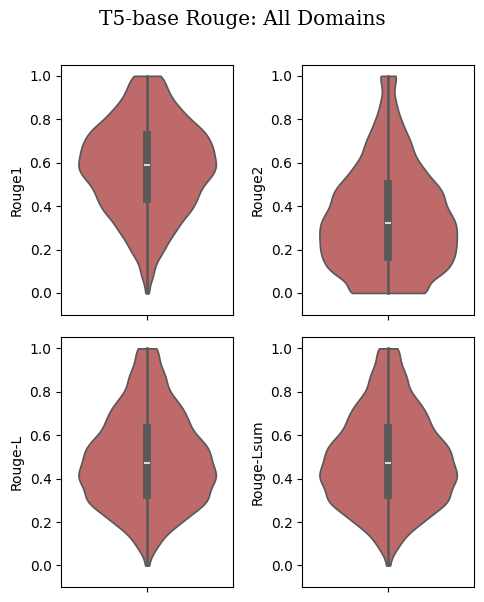

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-base Rouge: All Domains",  y=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

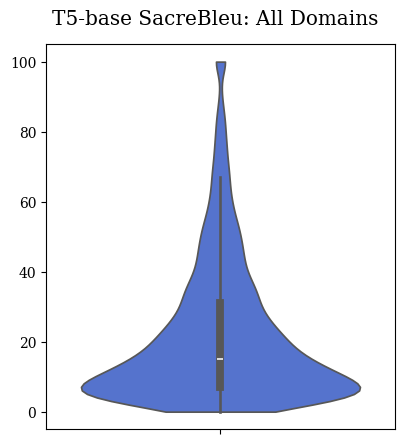

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_T5_base, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base SacreBleu: All Domains", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

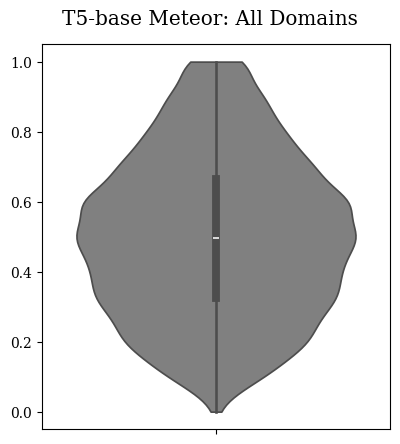

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_T5_base, y="Meteor", color="gray", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: All Domains", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Top 5 Domains
In this section, we will assess the model's performance on tables originating from the 5 most prevalent domains found in the dataset. A separate evaluation by category will take place.

In [ ]:
#Replacing "Film","Filmography" & "Television" with "Film/TV "
df_test['table_section_title'] = df_test['table_section_title'].replace(['Filmography','Film','Television'], 'Film/TV')

In [ ]:
df_test.table_section_title.value_counts().head(5)

Film/TV                      600
Demographics                 417
                             336
Mixed martial arts record    158
Career statistics            152
Name: table_section_title, dtype: int64

#####**Domain:** Film/Tv

In [ ]:
FilmTv = df_test[df_test['table_section_title'].isin(['Film/TV'])]
FilmTv

Table to Text  \
1     Table page title: Alma Jodorowsky, Table secti...   
6     Table page title: Julian Sands, Table section ...   
35    Table page title: Jennie Garth, Table section ...   
70    Table page title: Melissa George, Table sectio...   
94    Table page title: Marcia Strassman, Table sect...   
...                                                 ...   
7659  Table page title: Ruth Gemmell, Table section ...   
7660  Table page title: Keiynan Lonsdale, Table sect...   
7661  Table page title: Péter Scherer, Table section...   
7690  Table page title: Aidan McArdle, Table section...   
7691  Table page title: Karl Malden, Table section t...   

                                              Anotation table_section_title  
1     Alma Jodorowsky had the role of Evelyn in 2016...             Film/TV  
6     In 2012, Julian Sands played as Alistair Wesle...             Film/TV  
35    In 2008, Garth starred as Kelly Taylor in "902...             Film/TV  
70    Melissa George starred in Charmed and, in 2003...             Film/TV  
94    Marcia Strassman played Nancy Sterngood on the...             Film/TV  
...                                                 ...                 ...  
7659  In 1996, Gemmell appeared as Kerry Cox in the ...             Film/TV  
7660  Keiynan Lonsdale played Uriah Pedrad in The Di...             Film/TV  
7661  Péter Scherer appeared in Miklós Jancsó’s movi...             Film/TV  
7690  In 2004, Aidan McArdle played Slannen in the f...             Film/TV  
7691  Malden portrayed Leon Klinghoffer in the 1989 ...             Film/TV  

[600 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
import gc

FilmTv_summaries_T5_base = {}
for i, text in tqdm(enumerate(FilmTv['Table to Text']),total=len(FilmTv['Table to Text'])):
    text = "summarize: " + text
    FilmTv_summaries_T5_base[i] = summarizer(text,max_length=30,min_length=5)


100%|██████████| 600/600 [04:43<00:00,  2.12it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_base_FilmTv_bleu={}
T5_base_FilmTv_rouge={}
T5_base_FilmTv_meteor={}

for s in tqdm(FilmTv_summaries_T5_base.keys()):
  preds = [FilmTv_summaries_T5_base[s][0]['summary_text']]
  labels = [FilmTv['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_base_FilmTv_rouge[s]=score_r
  T5_base_FilmTv_bleu[s]=score_b
  T5_base_FilmTv_meteor[s]=score_m

100%|██████████| 600/600 [01:37<00:00,  6.14it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_base_FilmTv_rouge.keys():
  sum_r1+=T5_base_FilmTv_rouge[key]['rouge1']
  sum_r2+=T5_base_FilmTv_rouge[key]['rouge2']
  sum_rL+=T5_base_FilmTv_rouge[key]['rougeL']
  sum_rLsum+=T5_base_FilmTv_rouge[key]['rougeLsum']
  sumbleu+=T5_base_FilmTv_bleu[key]['score']
  sum_meteor+=T5_base_FilmTv_meteor[key]['meteor']

  r1_list.append(T5_base_FilmTv_rouge[key]['rouge1'])
  r2_list.append(T5_base_FilmTv_rouge[key]['rouge2'])
  rL_list.append(T5_base_FilmTv_rouge[key]['rougeL'])
  rLsum_list.append(T5_base_FilmTv_rouge[key]['rougeLsum'])
  bleu_list.append(T5_base_FilmTv_bleu[key]['score'])
  meteor_list.append(T5_base_FilmTv_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_base_FilmTv_rouge.keys())
avg_r2=sum_r2/len(T5_base_FilmTv_rouge.keys())
avg_rL=sum_rL/len(T5_base_FilmTv_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_base_FilmTv_rouge.keys())
avg_bleu=sumbleu/len(T5_base_FilmTv_bleu.keys())
avg_meteor=sum_meteor/len(T5_base_FilmTv_meteor.keys())

print(f"""---T5-base-Film/Tv-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-base-Film/Tv-Domain---

        Average
Rouge-1: 0.72
Rouge-2: 0.46
Rouge-L: 0.62
Rouge-Lsum: 0.62
SacreBleu: 30.69
Meteor: 0.64

        Median
Rouge-1: 0.74
Rouge-2: 0.45
Rouge-L: 0.63
Rouge-Lsum: 0.63
SacreBleu: 26.6
Meteor: 0.64

    Standard Deviation
Rouge-1: 0.13
Rouge-2: 0.19
Rouge-L: 0.16
Rouge-Lsum: 0.16
SacreBleu: 19.43
Meteor: 0.18

  Minimum/Maximum
Rouge-1 | Min: 0.27 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.15 | Max: 1.0
Rouge-Lsum | Min: 0.15 | Max: 1.0
SacreBleu | Min: 1.82 | Max: 100.0
Meteor| Min: 0.11 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_base_FilmTv_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_FilmTv_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_FilmTv_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_base_FilmTv=[T5_base_FilmTv_avg_all, T5_base_FilmTv_median_all, T5_base_FilmTv_sd_all]
for metric, metric_name in zip(metrics_T5_base_FilmTv, ['T5_base_FilmTv_avg_all', 'T5_base_FilmTv_median_all', 'T5_base_FilmTv_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_FilmTv_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_FilmTv_T5_base=pd.DataFrame(T5_base_FilmTv_metrics)


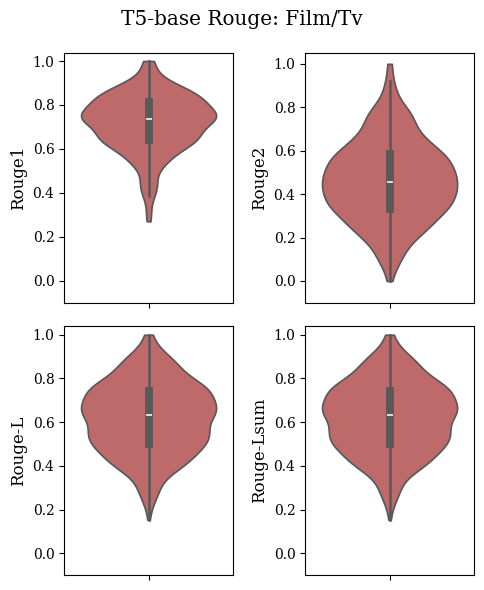

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_FilmTv_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_FilmTv_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_FilmTv_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_FilmTv_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-base Rouge: Film/Tv", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

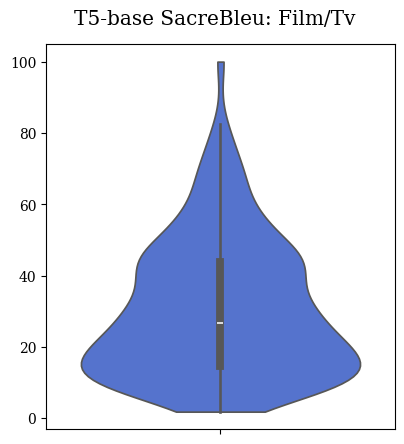

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_T5_base, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-base SacreBleu: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

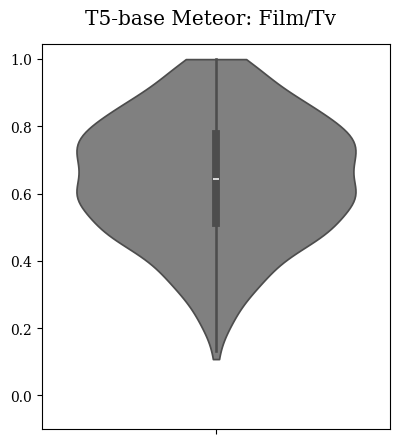

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_T5_base, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Demographics

In [ ]:
demographics = df_test[df_test['table_section_title'].isin(['Demographics'])]
demographics

Table to Text  \
26    Table page title: Arrow Point, Missouri, Table...   
42    Table page title: Calais, Table section title:...   
46    Table page title: Monument, Oregon, Table sect...   
52    Table page title: Seffner, Florida, Table sect...   
53    Table page title: Velda City, Missouri, Table ...   
...                                                 ...   
7673  Table page title: Cortland County, New York, T...   
7675  Table page title: Tarlac City, Table section t...   
7687  Table page title: Stinesville, Indiana, Table ...   
7688  Table page title: Wilson, St. Croix County, Wi...   
7695  Table page title: Hobart, Oklahoma, Table sect...   

                                              Anotation table_section_title  
26    As of the census of 2000, there were 133 peopl...        Demographics  
42    There was a massive growth in population of Ca...        Demographics  
46    As of the census of 2010, there were 128 peopl...        Demographics  
52    The population of Seffner was 7,579 at the 201...        Demographics  
53    As of the census of 2010, there were 1,420 peo...        Demographics  
...                                                 ...                 ...  
7673  As of the 2010 census, the population of Cortl...        Demographics  
7675  According to the 2015 census, Tarlac City has ...        Demographics  
7687  According to 2010 census, the population was 1...        Demographics  
7688  As of the census of 2010, there were 184 peopl...        Demographics  
7695       Hobart became the residence of 2,936 people.        Demographics  

[417 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

demographics_summaries_T5_base = {}
for i, text in tqdm(enumerate(demographics['Table to Text']),total=len(demographics['Table to Text'])):
    text = "summarize: " + text
    demographics_summaries_T5_base[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 417/417 [02:44<00:00,  2.54it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_base_demographics_bleu={}
T5_base_demographics_rouge={}
T5_base_demographics_meteor={}

for s in tqdm(demographics_summaries_T5_base.keys()):
  preds = [demographics_summaries_T5_base[s][0]['summary_text']]
  labels = [demographics['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_base_demographics_rouge[s]=score_r
  T5_base_demographics_bleu[s]=score_b
  T5_base_demographics_meteor[s]=score_m

100%|██████████| 417/417 [01:09<00:00,  5.98it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_base_demographics_rouge.keys():
  sum_r1+=T5_base_demographics_rouge[key]['rouge1']
  sum_r2+=T5_base_demographics_rouge[key]['rouge2']
  sum_rL+=T5_base_demographics_rouge[key]['rougeL']
  sum_rLsum+=T5_base_demographics_rouge[key]['rougeLsum']
  sumbleu+=T5_base_demographics_bleu[key]['score']
  sum_meteor+=T5_base_demographics_meteor[key]['meteor']

  r1_list.append(T5_base_demographics_rouge[key]['rouge1'])
  r2_list.append(T5_base_demographics_rouge[key]['rouge2'])
  rL_list.append(T5_base_demographics_rouge[key]['rougeL'])
  rLsum_list.append(T5_base_demographics_rouge[key]['rougeLsum'])
  bleu_list.append(T5_base_demographics_bleu[key]['score'])
  meteor_list.append(T5_base_demographics_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_base_demographics_rouge.keys())
avg_r2=sum_r2/len(T5_base_demographics_rouge.keys())
avg_rL=sum_rL/len(T5_base_demographics_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_base_demographics_rouge.keys())
avg_bleu=sumbleu/len(T5_base_demographics_bleu.keys())
avg_meteor=sum_meteor/len(T5_base_demographics_meteor.keys())

print(f"""---T5-base-Demographics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-base-Demographics-Domain---

        Average
Rouge-1: 0.7
Rouge-2: 0.49
Rouge-L: 0.59
Rouge-Lsum: 0.59
SacreBleu: 37.66
Meteor: 0.62

        Median
Rouge-1: 0.64
Rouge-2: 0.42
Rouge-L: 0.48
Rouge-Lsum: 0.48
SacreBleu: 21.99
Meteor: 0.6

    Standard Deviation
Rouge-1: 0.22
Rouge-2: 0.3
Rouge-L: 0.29
Rouge-Lsum: 0.29
SacreBleu: 31.28
Meteor: 0.26

  Minimum/Maximum
Rouge-1 | Min: 0.19 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.13 | Max: 1.0
Rouge-Lsum | Min: 0.13 | Max: 1.0
SacreBleu | Min: 0.3 | Max: 100.0
Meteor| Min: 0.07 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_base_dem_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_dem_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_dem_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_base_dem=[T5_base_dem_avg_all, T5_base_dem_median_all, T5_base_dem_sd_all]
for metric, metric_name in zip(metrics_T5_base_dem, ['T5_base_dem_avg_all', 'T5_base_dem_median_all', 'T5_base_dem_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_demographics_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_demographics_T5_base=pd.DataFrame(T5_base_demographics_metrics)
df_demographics_T5_base

Rouge1    Rouge2   Rouge-L  Rouge-Lsum   SacreBleu    Meteor
0    1.000000  1.000000  1.000000    1.000000  100.000000  0.999878
1    0.631579  0.444444  0.578947    0.578947   11.824956  0.418456
2    0.880000  0.521739  0.800000    0.800000   35.930411  0.763605
3    0.437500  0.200000  0.250000    0.250000   14.792576  0.216216
4    0.933333  0.714286  0.866667    0.866667   56.058085  0.783176
..        ...       ...       ...         ...         ...       ...
412  0.666667  0.480000  0.518519    0.518519   38.503229  0.587589
413  0.692308  0.416667  0.384615    0.384615   15.365277  0.559755
414  0.521739  0.190476  0.434783    0.434783   14.949752  0.450893
415  0.857143  0.615385  0.785714    0.785714   46.661736  0.829665
416  0.636364  0.200000  0.454545    0.454545    6.917184  0.551255

[417 rows x 6 columns]

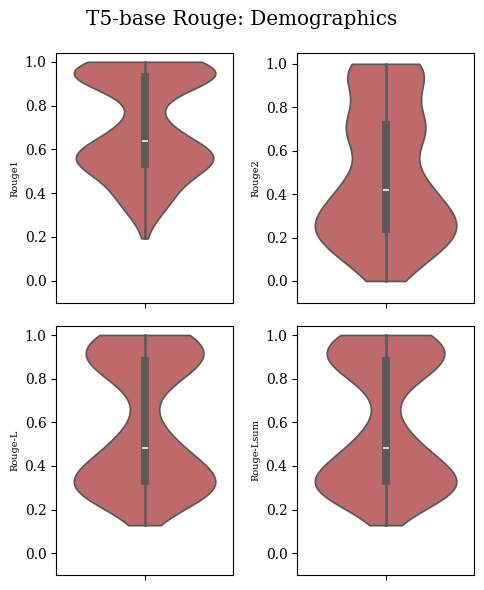

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_demographics_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_demographics_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_demographics_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_demographics_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-base Rouge: Demographics", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

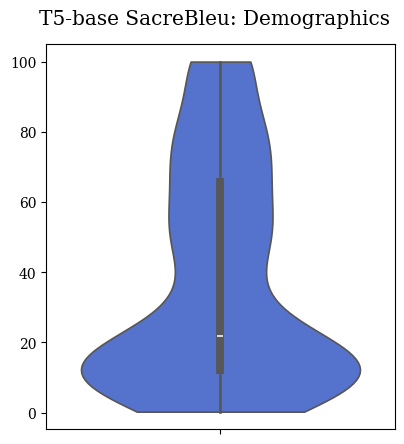

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_T5_base, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-base SacreBleu: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

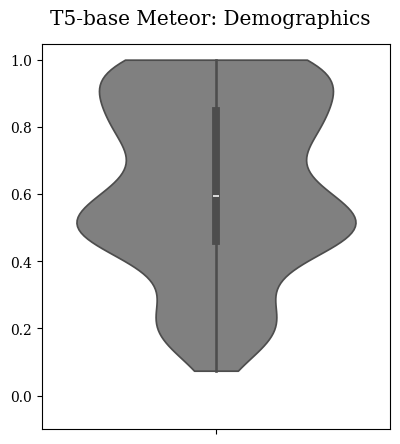

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_T5_base, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Blank

In [ ]:
Blank = df_test[df_test['table_section_title'].isin([''])]
Blank

Table to Text  \
10    Table page title: List of Argentine films of 1...   
23    Table page title: SEAT 1200 Sport, Table secti...   
50    Table page title: List of Deputy Speakers of t...   
125   Table page title: List of dance companies, Tab...   
137   Table page title: List of Malayalam films of 1...   
...                                                 ...   
7515  Table page title: List of flag bearers for Spa...   
7585  Table page title: Philadelphia Phillies all-ti...   
7596  Table page title: List of Malayalam films of 1...   
7625  Table page title: List of Indian states and un...   
7628  Table page title: List of presidents of the Co...   

                                              Anotation table_section_title  
10          "Don Fulgencio" is a 1950 Argentinian film.                      
23    4-cylinder-inline engine through a four-speed ...                      
50    Tobias Billström served as First Deputy Speake...                      
125   The Totem Dance group is one of Ukraine's cont...                      
137   Anuraagakkodathi is a 1982 Malayalam film dire...                      
...                                                 ...                 ...  
7515  Gasol was Spain's flag bearer at the 2012 Summ...                      
7585  George McQuillan recorded a 1.79 earned run av...                      
7596  Chandrakantham is a 1974 Malayalam film, direc...                      
7625  Goa ranks with least poverty of 5.09% while al...                      
7628  John Edwin Pomfret was the twentieth president...                      

[336 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

Blank_summaries_T5_base = {}
for i, text in tqdm(enumerate(Blank['Table to Text']),total=len(Blank['Table to Text'])):
    torch.cuda.empty_cache()
    text = "summarize: " + text[:10000]
    Blank_summaries_T5_base[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 336/336 [03:00<00:00,  1.86it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_base_Blank_bleu={}
T5_base_Blank_rouge={}
T5_base_Blank_meteor={}

for s in tqdm(Blank_summaries_T5_base.keys()):
  preds = [Blank_summaries_T5_base[s][0]['summary_text']]
  labels = [Blank['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_base_Blank_rouge[s]=score_r
  T5_base_Blank_bleu[s]=score_b
  T5_base_Blank_meteor[s]=score_m

100%|██████████| 336/336 [00:54<00:00,  6.15it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_base_Blank_rouge.keys():
  sum_r1+=T5_base_Blank_rouge[key]['rouge1']
  sum_r2+=T5_base_Blank_rouge[key]['rouge2']
  sum_rL+=T5_base_Blank_rouge[key]['rougeL']
  sum_rLsum+=T5_base_Blank_rouge[key]['rougeLsum']
  sumbleu+=T5_base_Blank_bleu[key]['score']
  sum_meteor+=T5_base_Blank_meteor[key]['meteor']

  r1_list.append(T5_base_Blank_rouge[key]['rouge1'])
  r2_list.append(T5_base_Blank_rouge[key]['rouge2'])
  rL_list.append(T5_base_Blank_rouge[key]['rougeL'])
  rLsum_list.append(T5_base_Blank_rouge[key]['rougeLsum'])
  bleu_list.append(T5_base_Blank_bleu[key]['score'])
  meteor_list.append(T5_base_Blank_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_base_Blank_rouge.keys())
avg_r2=sum_r2/len(T5_base_Blank_rouge.keys())
avg_rL=sum_rL/len(T5_base_Blank_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_base_Blank_rouge.keys())
avg_bleu=sumbleu/len(T5_base_Blank_bleu.keys())
avg_meteor=sum_meteor/len(T5_base_Blank_meteor.keys())

print(f"""---T5-base-Blank-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-base-Blank-Domain---

        Average
Rouge-1: 0.58
Rouge-2: 0.4
Rouge-L: 0.53
Rouge-Lsum: 0.53
SacreBleu: 26.13
Meteor: 0.53

        Median
Rouge-1: 0.57
Rouge-2: 0.36
Rouge-L: 0.5
Rouge-Lsum: 0.5
SacreBleu: 18.14
Meteor: 0.54

    Standard Deviation
Rouge-1: 0.23
Rouge-2: 0.26
Rouge-L: 0.24
Rouge-Lsum: 0.24
SacreBleu: 22.83
Meteor: 0.25

  Minimum/Maximum
Rouge-1 | Min: 0.0 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.0 | Max: 1.0
Rouge-Lsum | Min: 0.0 | Max: 1.0
SacreBleu | Min: 0.0 | Max: 100.0
Meteor| Min: 0.0 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_base_blank_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_blank_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_blank_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_base_blank=[T5_base_blank_avg_all, T5_base_blank_median_all, T5_base_blank_sd_all]
for metric, metric_name in zip(metrics_T5_base_blank, ['T5_base_blank_avg_all', 'T5_base_blank_median_all', 'T5_base_blank_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_blank_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_blank_T5_base=pd.DataFrame(T5_base_blank_metrics)
df_blank_T5_base

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.714286  0.333333  0.714286    0.714286  14.898574  0.573980
1    0.450000  0.263158  0.250000    0.250000  12.891171  0.265330
2    0.500000  0.444444  0.500000    0.500000  46.777665  0.549185
3    0.400000  0.173913  0.400000    0.400000   7.141816  0.390161
4    0.736842  0.705882  0.736842    0.736842  53.316754  0.785891
..        ...       ...       ...         ...        ...       ...
331  0.833333  0.545455  0.750000    0.750000  43.242271  0.879962
332  0.216216  0.000000  0.162162    0.162162   2.278334  0.123967
333  0.727273  0.700000  0.727273    0.727273  39.832872  0.730028
334  0.628571  0.242424  0.571429    0.571429   5.725999  0.490037
335  0.923077  0.833333  0.923077    0.923077  80.032032  0.999852

[336 rows x 6 columns]

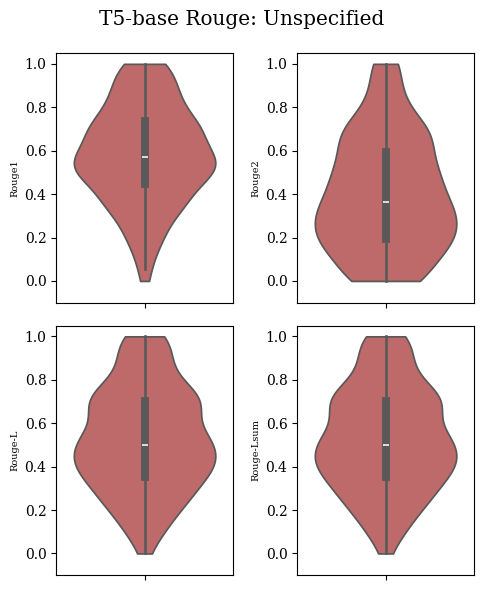

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_blank_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_blank_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_blank_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_blank_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("T5-base Rouge: Unspecified", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

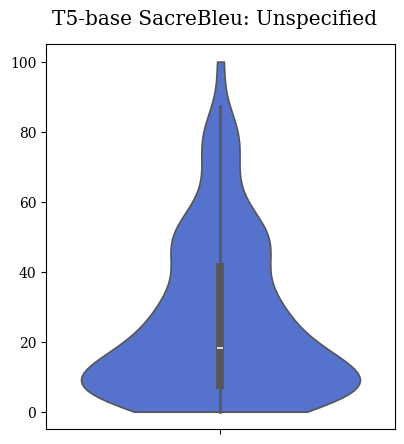

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_T5_base, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-base SacreBleu: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

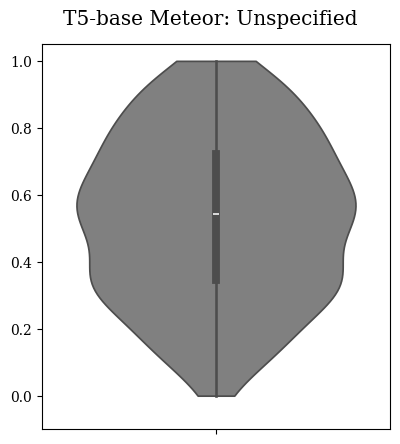

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_T5_base, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: MMA Record

In [ ]:
MMA = df_test[df_test['table_section_title'].isin(['Mixed martial arts record'])]
MMA

Table to Text  \
61    Table page title: Liz Carmouche, Table section...   
65    Table page title: Sam Sicilia, Table section t...   
133   Table page title: Hakeem Dawodu, Table section...   
165   Table page title: Neiman Gracie, Table section...   
292   Table page title: John Howard (fighter), Table...   
...                                                 ...   
7379  Table page title: Alexa Conners, Table section...   
7415  Table page title: Brandon Girtz, Table section...   
7422  Table page title: Efrain Escudero, Table secti...   
7474  Table page title: Martin Kampmann, Table secti...   
7605  Table page title: Jake Butler, Table section t...   

                                              Anotation  \
61    On July 22, 2011, Carmouche faced Sarah Kaufma...   
65    Sicilia of the featherweight division, faced R...   
133   On December 18, 2015, Dawodu faced Marat Magom...   
165   Gracie faced Roger Carroll at Bellator 151 on ...   
292   Howard faced Thiago Alves on December 11, 2010...   
...                                                 ...   
7379  Conners faced Katharina Lehner on August 31, 2...   
7415  Girtz faced Derek Campos at Bellator 146 on No...   
7422  Efrain fought against Akhmet Aliev at Fight Ni...   
7474  Kampmann faced Jake Shields on October 23, 201...   
7605  Butler faced Sylvain Potard at ONE FC: Warrior...   

            table_section_title  
61    Mixed martial arts record  
65    Mixed martial arts record  
133   Mixed martial arts record  
165   Mixed martial arts record  
292   Mixed martial arts record  
...                         ...  
7379  Mixed martial arts record  
7415  Mixed martial arts record  
7422  Mixed martial arts record  
7474  Mixed martial arts record  
7605  Mixed martial arts record  

[158 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

MMA_summaries_T5_base = {}
for i, text in tqdm(enumerate(MMA['Table to Text']),total=len(MMA['Table to Text'])):
    text = "summarize: " + text
    MMA_summaries_T5_base[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 158/158 [01:21<00:00,  1.94it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_base_MMA_bleu={}
T5_base_MMA_rouge={}
T5_base_MMA_meteor={}

for s in tqdm(MMA_summaries_T5_base.keys()):
  preds = [MMA_summaries_T5_base[s][0]['summary_text']]
  labels = [MMA['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_base_MMA_rouge[s]=score_r
  T5_base_MMA_bleu[s]=score_b
  T5_base_MMA_meteor[s]=score_m

100%|██████████| 158/158 [00:25<00:00,  6.14it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_base_MMA_rouge.keys():
  sum_r1+=T5_base_MMA_rouge[key]['rouge1']
  sum_r2+=T5_base_MMA_rouge[key]['rouge2']
  sum_rL+=T5_base_MMA_rouge[key]['rougeL']
  sum_rLsum+=T5_base_MMA_rouge[key]['rougeLsum']
  sumbleu+=T5_base_MMA_bleu[key]['score']
  sum_meteor+=T5_base_MMA_meteor[key]['meteor']

  r1_list.append(T5_base_MMA_rouge[key]['rouge1'])
  r2_list.append(T5_base_MMA_rouge[key]['rouge2'])
  rL_list.append(T5_base_MMA_rouge[key]['rougeL'])
  rLsum_list.append(T5_base_MMA_rouge[key]['rougeLsum'])
  bleu_list.append(T5_base_MMA_bleu[key]['score'])
  meteor_list.append(T5_base_MMA_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_base_MMA_rouge.keys())
avg_r2=sum_r2/len(T5_base_MMA_rouge.keys())
avg_rL=sum_rL/len(T5_base_MMA_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_base_MMA_rouge.keys())
avg_bleu=sumbleu/len(T5_base_MMA_bleu.keys())
avg_meteor=sum_meteor/len(T5_base_MMA_meteor.keys())

print(f"""---T5-base-MMA Record-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-base-MMA Record-Domain---

        Average
Rouge-1: 0.83
Rouge-2: 0.67
Rouge-L: 0.67
Rouge-Lsum: 0.67
SacreBleu: 51.43
Meteor: 0.77

        Median
Rouge-1: 0.87
Rouge-2: 0.73
Rouge-L: 0.7
Rouge-Lsum: 0.7
SacreBleu: 53.75
Meteor: 0.82

    Standard Deviation
Rouge-1: 0.17
Rouge-2: 0.22
Rouge-L: 0.2
Rouge-Lsum: 0.2
SacreBleu: 24.13
Meteor: 0.2

  Minimum/Maximum
Rouge-1 | Min: 0.1 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.1 | Max: 1.0
Rouge-Lsum | Min: 0.1 | Max: 1.0
SacreBleu | Min: 2.23 | Max: 100.0
Meteor| Min: 0.1 | Max: 1.0




In [ ]:
#put all averages in a dictionary
T5_base_mma_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_mma_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_mma_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_base_mma=[T5_base_mma_avg_all, T5_base_mma_median_all, T5_base_mma_sd_all]
for metric, metric_name in zip(metrics_T5_base_mma, ['T5_base_mma_avg_all', 'T5_base_mma_median_all', 'T5_base_mma_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_mma_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_mma_T5_base=pd.DataFrame(T5_base_mma_metrics)
df_mma_T5_base

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.848485  0.774194  0.666667    0.666667  51.735231  0.693543
1    0.846154  0.750000  0.846154    0.846154  63.347427  0.741505
2    1.000000  0.900000  0.636364    0.636364  63.436083  0.908646
3    0.956522  0.952381  0.956522    0.956522  91.932272  0.992141
4    1.000000  0.800000  0.727273    0.727273  54.805987  0.889277
..        ...       ...       ...         ...        ...       ...
153  0.866667  0.857143  0.866667    0.866667  77.149853  0.842572
154  1.000000  0.800000  0.727273    0.727273  59.188219  0.985435
155  0.482759  0.444444  0.482759    0.482759  29.125962  0.362166
156  1.000000  0.800000  0.727273    0.727273  59.188219  0.985435
157  0.962963  0.880000  0.962963    0.962963  81.535510  0.945821

[158 rows x 6 columns]

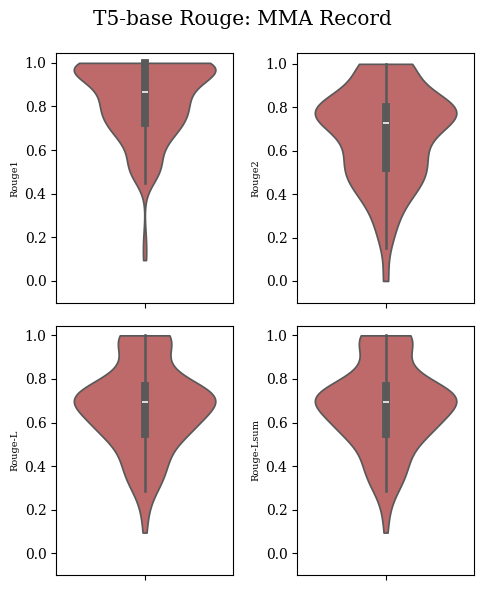

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_mma_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_mma_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_mma_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_mma_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.suptitle("T5-base Rouge: MMA Record", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

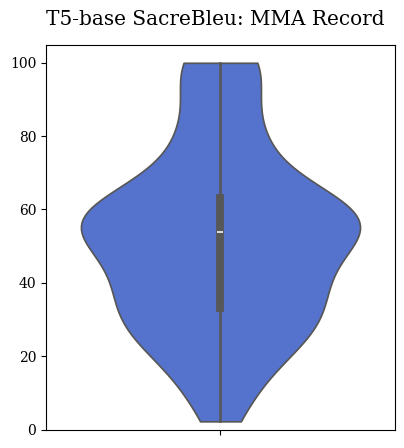

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_T5_base, y="SacreBleu", color="royalblue", cut=0)
ax.set_ylim(bottom=-0.1)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-base SacreBleu: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

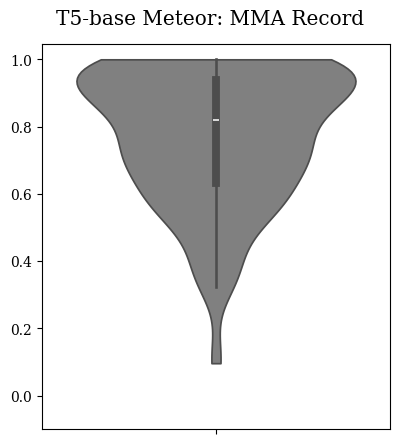

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_T5_base, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Career Statistics

In [ ]:
cs = df_test[df_test['table_section_title'].isin(['Career statistics'])]
cs

Table to Text  \
2     Table page title: A. J. Hawk, Table section ti...   
98    Table page title: Scott Campbell (ice hockey, ...   
146   Table page title: Ryan Mathews (American footb...   
158   Table page title: Reggie Bush, Table section t...   
171   Table page title: Dwayne Zinger, Table section...   
...                                                 ...   
7323  Table page title: Mark Greaves, Table section ...   
7336  Table page title: Chad Costello, Table section...   
7471  Table page title: Nils-Eric Johansson, Table s...   
7539  Table page title: Barry Salvage, Table section...   
7615  Table page title: Yohan Betsch, Table section ...   

                                              Anotation table_section_title  
2     In his rookie season, Hawk led with 119 total ...   Career statistics  
98    Campbell played 149 WHA games for the Aeros an...   Career statistics  
146   Mathews of Philadelphia Eagles finished the 20...   Career statistics  
158   Reggie Bush finished with 297 rushing yards an...   Career statistics  
171   Zinger moved to the Cincinnati Cyclones of the...   Career statistics  
...                                                 ...                 ...  
7323  Mark Greaves made 175 appearances and scored f...   Career statistics  
7336  Chad Costello scored 125 points in 72 games in...   Career statistics  
7471  In 1999–00, Nils-Eric Johansson participated i...   Career statistics  
7539  In 1977, Salvage moved to North American Socce...   Career statistics  
7615  Betsch was at Metz in the 2011–12 season, then...   Career statistics  

[152 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

cs_summaries_T5_base = {}
for i, text in tqdm(enumerate(cs['Table to Text']),total=len(cs['Table to Text'])):
    text = "summarize: " + text
    cs_summaries_T5_base[i] = summarizer(text,max_length=30,min_length=5)



100%|██████████| 152/152 [01:09<00:00,  2.20it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

T5_base_cs_bleu={}
T5_base_cs_rouge={}
T5_base_cs_meteor={}

for s in tqdm(cs_summaries_T5_base.keys()):
  preds = [cs_summaries_T5_base[s][0]['summary_text']]
  labels = [cs['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  T5_base_cs_rouge[s]=score_r
  T5_base_cs_bleu[s]=score_b
  T5_base_cs_meteor[s]=score_m

100%|██████████| 152/152 [00:24<00:00,  6.09it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in T5_base_cs_rouge.keys():
  sum_r1+=T5_base_cs_rouge[key]['rouge1']
  sum_r2+=T5_base_cs_rouge[key]['rouge2']
  sum_rL+=T5_base_cs_rouge[key]['rougeL']
  sum_rLsum+=T5_base_cs_rouge[key]['rougeLsum']
  sumbleu+=T5_base_cs_bleu[key]['score']
  sum_meteor+=T5_base_cs_meteor[key]['meteor']

  r1_list.append(T5_base_cs_rouge[key]['rouge1'])
  r2_list.append(T5_base_cs_rouge[key]['rouge2'])
  rL_list.append(T5_base_cs_rouge[key]['rougeL'])
  rLsum_list.append(T5_base_cs_rouge[key]['rougeLsum'])
  bleu_list.append(T5_base_cs_bleu[key]['score'])
  meteor_list.append(T5_base_cs_meteor[key]['meteor'])

avg_r1=sum_r1/len(T5_base_cs_rouge.keys())
avg_r2=sum_r2/len(T5_base_cs_rouge.keys())
avg_rL=sum_rL/len(T5_base_cs_rouge.keys())
avg_rLsum=sum_rLsum/len(T5_base_cs_rouge.keys())
avg_bleu=sumbleu/len(T5_base_cs_bleu.keys())
avg_meteor=sum_meteor/len(T5_base_cs_meteor.keys())

print(f"""---T5-base-Career Statistics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---T5-base-Career Statistics-Domain---

        Average
Rouge-1: 0.6
Rouge-2: 0.32
Rouge-L: 0.47
Rouge-Lsum: 0.47
SacreBleu: 16.81
Meteor: 0.5

        Median
Rouge-1: 0.63
Rouge-2: 0.31
Rouge-L: 0.45
Rouge-Lsum: 0.45
SacreBleu: 12.82
Meteor: 0.5

    Standard Deviation
Rouge-1: 0.17
Rouge-2: 0.19
Rouge-L: 0.16
Rouge-Lsum: 0.16
SacreBleu: 13.46
Meteor: 0.19

  Minimum/Maximum
Rouge-1 | Min: 0.21 | Max: 0.92
Rouge-2 | Min: 0.0 | Max: 0.83
Rouge-L | Min: 0.13 | Max: 0.92
Rouge-Lsum | Min: 0.13 | Max: 0.92
SacreBleu | Min: 1.72 | Max: 60.77
Meteor| Min: 0.1 | Max: 0.92




In [ ]:
#put all averages in a dictionary
T5_base_cs_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
T5_base_cs_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
T5_base_cs_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_T5_base_cs=[T5_base_cs_avg_all, T5_base_cs_median_all, T5_base_cs_sd_all]
for metric, metric_name in zip(metrics_T5_base_cs, ['T5_base_cs_avg_all', 'T5_base_cs_median_all', 'T5_base_cs_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
T5_base_cs_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_cs_T5_base=pd.DataFrame(T5_base_cs_metrics)
df_cs_T5_base

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.375000  0.000000  0.375000    0.375000   8.125166  0.274457
1    0.689655  0.296296  0.620690    0.620690  13.155959  0.658096
2    0.439024  0.051282  0.195122    0.195122   3.161209  0.266371
3    0.636364  0.300000  0.636364    0.636364  17.827531  0.585286
4    0.692308  0.416667  0.461538    0.461538  16.664088  0.420108
..        ...       ...       ...         ...        ...       ...
147  0.454545  0.333333  0.363636    0.363636  15.141037  0.311730
148  0.555556  0.250000  0.555556    0.555556  13.224836  0.520833
149  0.727273  0.400000  0.545455    0.545455  18.085428  0.595207
150  0.714286  0.384615  0.428571    0.428571  31.007120  0.669367
151  0.529412  0.125000  0.411765    0.411765   6.104394  0.298894

[152 rows x 6 columns]

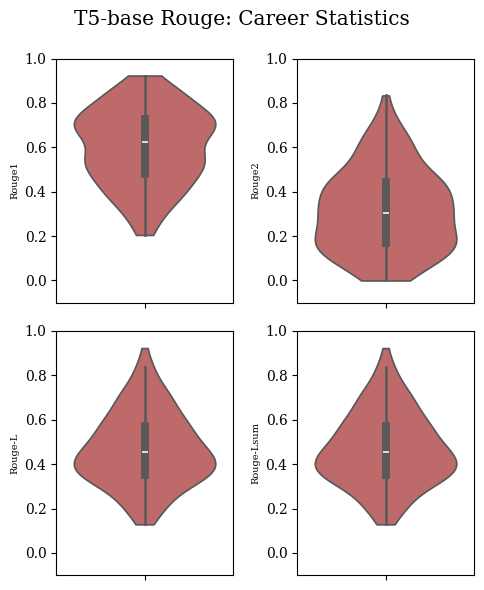

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_cs_T5_base, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_cs_T5_base, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_cs_T5_base, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_cs_T5_base, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1, top=1)


plt.suptitle("T5-base Rouge: Career Statistics", fontdict=title_font, y=0.98)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

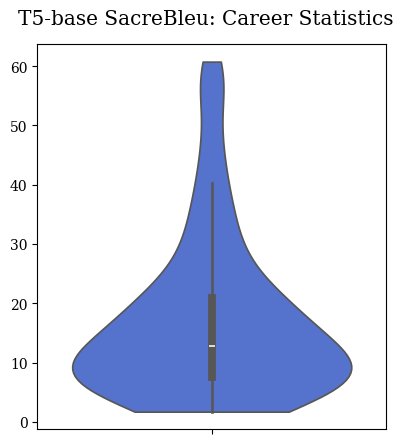

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_cs_T5_base, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("T5-base SacreBleu: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

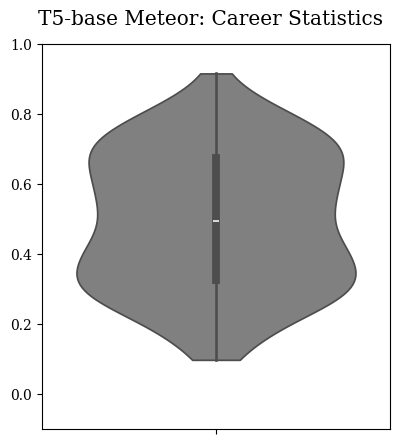

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_cs_T5_base, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1,top=1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("T5-base Meteor: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Results - Plots Combo

In [ ]:
files=['/content/T5_base_All_avg_all.pkl','/content/T5_base_All_median_all.pkl','/content/T5_base_All_sd_all.pkl',
       '/content/T5_base_FilmTv_avg_all.pkl','/content/T5_base_FilmTv_median_all.pkl','/content/T5_base_FilmTv_sd_all.pkl',
       '/content/T5_base_blank_avg_all.pkl','/content/T5_base_blank_median_all.pkl','/content/T5_base_blank_sd_all.pkl',
       '/content/T5_base_cs_avg_all.pkl','/content/T5_base_cs_median_all.pkl','/content/T5_base_cs_sd_all.pkl',
       '/content/T5_base_dem_avg_all.pkl','/content/T5_base_dem_median_all.pkl','/content/T5_base_dem_sd_all.pkl',
       '/content/T5_base_mma_avg_all.pkl','/content/T5_base_mma_median_all.pkl','/content/T5_base_mma_sd_all.pkl']

metrics={}
for i in range(len(files)):
  with open(files[i], 'rb') as file:
      metrics[i] = pickle.load(file)

In [ ]:
avg_all=metrics[0]
median_all=metrics[1]
sd_all=metrics[2]
avg_FilmTv=metrics[3]
median_FilmTv=metrics[4]
sd_FilmTv=metrics[5]
avg_blank=metrics[6]
median_blank=metrics[7]
sd_blank=metrics[8]
avg_cs=metrics[9]
median_cs=metrics[10]
sd_cs=metrics[11]
avg_dem=metrics[12]
median_dem=metrics[13]
sd_dem=metrics[14]
avg_mma=metrics[15]
median_mma=metrics[16]
sd_mma=metrics[17]

In [ ]:
print('-----------------------------------------T5-base-Average-------------------------------------------')
avg_dataframe=pd.DataFrame(avg_all.keys(),index=range(len(avg_all.keys())),columns=['Metric'])
avg_dataframe['All Domains']=avg_all.values()
avg_dataframe['Career Statistics']=avg_cs.values()
avg_dataframe['Demographics']=avg_dem.values()
avg_dataframe['Film/Tv']=avg_FilmTv.values()
avg_dataframe['MMA Record']=avg_mma.values()
avg_dataframe['Unspecified']=avg_blank.values()
avg_dataframe

-----------------------------------------T5-base-Average-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.58               0.60          0.70     0.72   
1      Rouge2         0.35               0.32          0.49     0.46   
2     Rouge-L         0.49               0.47          0.59     0.62   
3  Rouge-Lsum         0.49               0.47          0.59     0.62   
4   SacreBleu        22.05              16.81         37.66    30.69   
5      Meteor         0.50               0.50          0.62     0.64   

   MMA Record  Unspecified  
0        0.83         0.58  
1        0.67         0.40  
2        0.67         0.53  
3        0.67         0.53  
4       51.43        26.13  
5        0.77         0.53

In [ ]:
print('----------------------------------------T5-base-Median-------------------------------------------')
median_dataframe=pd.DataFrame(median_all.keys(),index=range(len(median_all.keys())),columns=['Metric'])
median_dataframe['All Domains']=median_all.values()
median_dataframe['Career Statistics']=median_cs.values()
median_dataframe['Demographics']=median_dem.values()
median_dataframe['Film/Tv']=median_FilmTv.values()
median_dataframe['MMA Record']=median_mma.values()
median_dataframe['Unspecified']=median_blank.values()
median_dataframe

----------------------------------------T5-base-Median-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.59               0.63          0.64     0.74   
1      Rouge2         0.32               0.31          0.42     0.45   
2     Rouge-L         0.47               0.45          0.48     0.63   
3  Rouge-Lsum         0.47               0.45          0.48     0.63   
4   SacreBleu        15.01              12.82         21.99    26.60   
5      Meteor         0.50               0.50          0.60     0.64   

   MMA Record  Unspecified  
0        0.87         0.57  
1        0.73         0.36  
2        0.70         0.50  
3        0.70         0.50  
4       53.75        18.14  
5        0.82         0.54

In [ ]:
print('-----------------------------------T5-base-Standard Deviation------------------------------------')
sd_dataframe=pd.DataFrame(sd_all.values(),index=sd_all.keys(),columns=['All Domains'])
sd_dataframe['Career Statistics']=sd_cs.values()
sd_dataframe['Demographics']=sd_dem.values()
sd_dataframe['Film/Tv']=sd_FilmTv.values()
sd_dataframe['MMA Record']=sd_mma.values()
sd_dataframe['Unspecified']=sd_blank.values()
sd_dataframe

-----------------------------------T5-base-Standard Deviation------------------------------------


All Domains  Career Statistics  Demographics  Film/Tv  MMA Record  \
Rouge1             0.21               0.17          0.22     0.13        0.17   
Rouge2             0.23               0.19          0.30     0.19        0.22   
Rouge-L            0.21               0.16          0.29     0.16        0.20   
Rouge-Lsum         0.21               0.16          0.29     0.16        0.20   
SacreBleu         20.19              13.46         31.28    19.43       24.13   
Meteor             0.23               0.19          0.26     0.18        0.20   

            Unspecified  
Rouge1             0.23  
Rouge2             0.26  
Rouge-L            0.24  
Rouge-Lsum         0.24  
SacreBleu         22.83  
Meteor             0.25

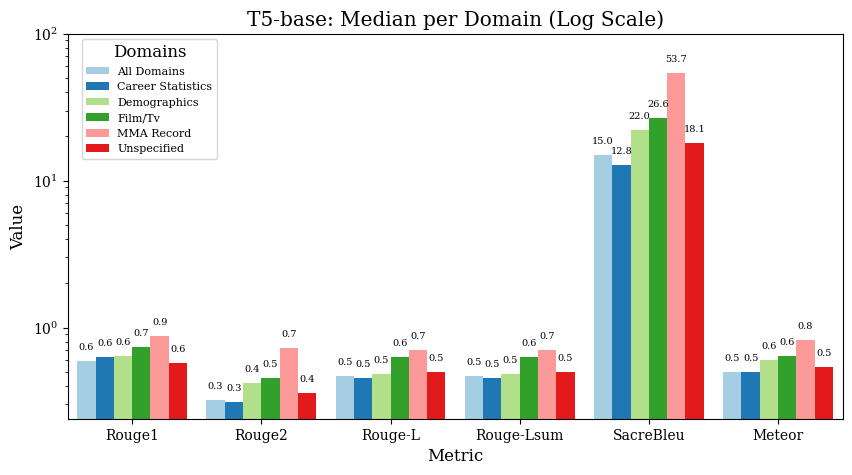

In [ ]:
import matplotlib as mpl

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(median_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=1,width=0.85)

plt.title("T5-base: Median per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)





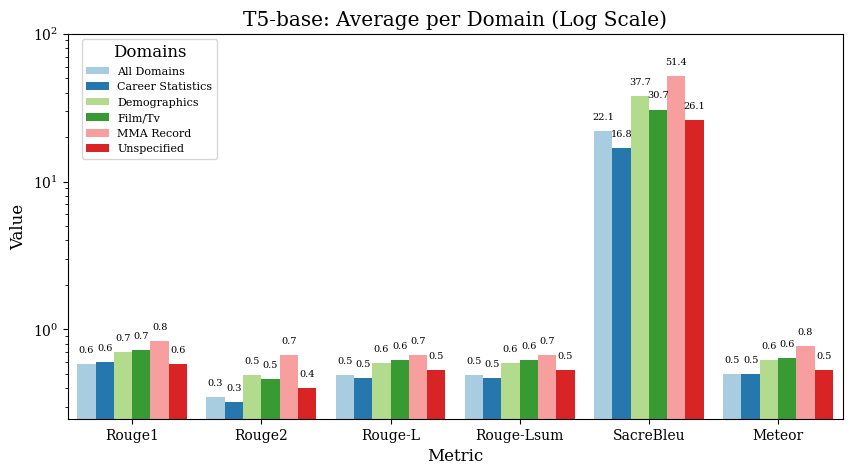

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(avg_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)

plt.title("T5-base: Average per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10



In [ ]:
df_T5_base['Domain'] = 'All'
df_FilmTv_T5_base['Domain'] = 'Film/Tv'
df_demographics_T5_base['Domain'] = 'Demographics'
df_blank_T5_base['Domain'] = 'Unspecified'
df_mma_T5_base['Domain'] = 'MMA Record'
df_cs_T5_base['Domain'] = 'Career Statistics'

combined_df = pd.concat([df_T5_base, df_FilmTv_T5_base,df_demographics_T5_base,df_blank_T5_base,df_mma_T5_base,df_cs_T5_base])
combined_df['Domain'] = pd.Categorical(combined_df['Domain'], ordered=True)
combined_df

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor  \
0    0.923077  0.833333  0.923077    0.923077  69.678128  0.975664   
1    0.857143  0.692308  0.785714    0.785714  47.087131  0.883229   
2    0.375000  0.000000  0.375000    0.375000   8.125166  0.274457   
3    0.312500  0.133333  0.187500    0.187500   6.359342  0.225603   
4    0.500000  0.400000  0.500000    0.500000  35.752972  0.519608   
..        ...       ...       ...         ...        ...       ...   
147  0.454545  0.333333  0.363636    0.363636  15.141037  0.311730   
148  0.555556  0.250000  0.555556    0.555556  13.224836  0.520833   
149  0.727273  0.400000  0.545455    0.545455  18.085428  0.595207   
150  0.714286  0.384615  0.428571    0.428571  31.007120  0.669367   
151  0.529412  0.125000  0.411765    0.411765   6.104394  0.298894   

                Domain  
0                  All  
1                  All  
2                  All  
3                  All  
4                  All  
..                 ...  
147  Career Statistics  
148  Career Statistics  
149  Career Statistics  
150  Career Statistics  
151  Career Statistics  

[9363 rows x 7 columns]

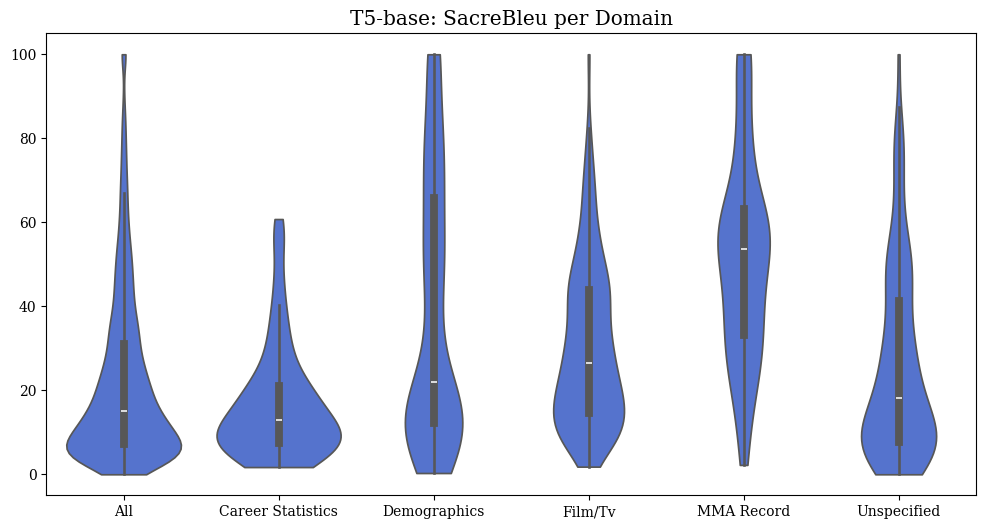

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="SacreBleu", data=combined_df, color="royalblue",cut=0)
plt.title("T5-base: SacreBleu per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

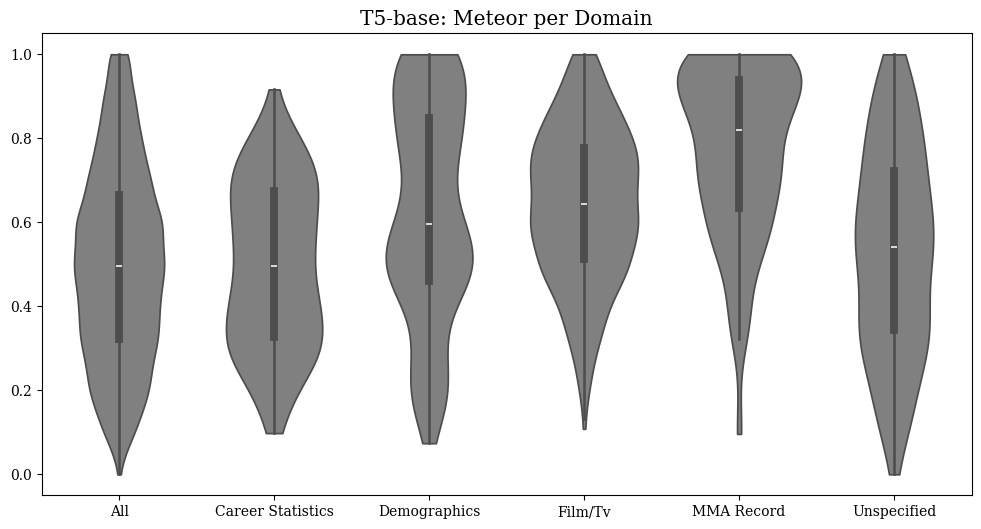

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="Meteor", data=combined_df, color="gray",cut=0)
plt.title("T5-base: Meteor per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

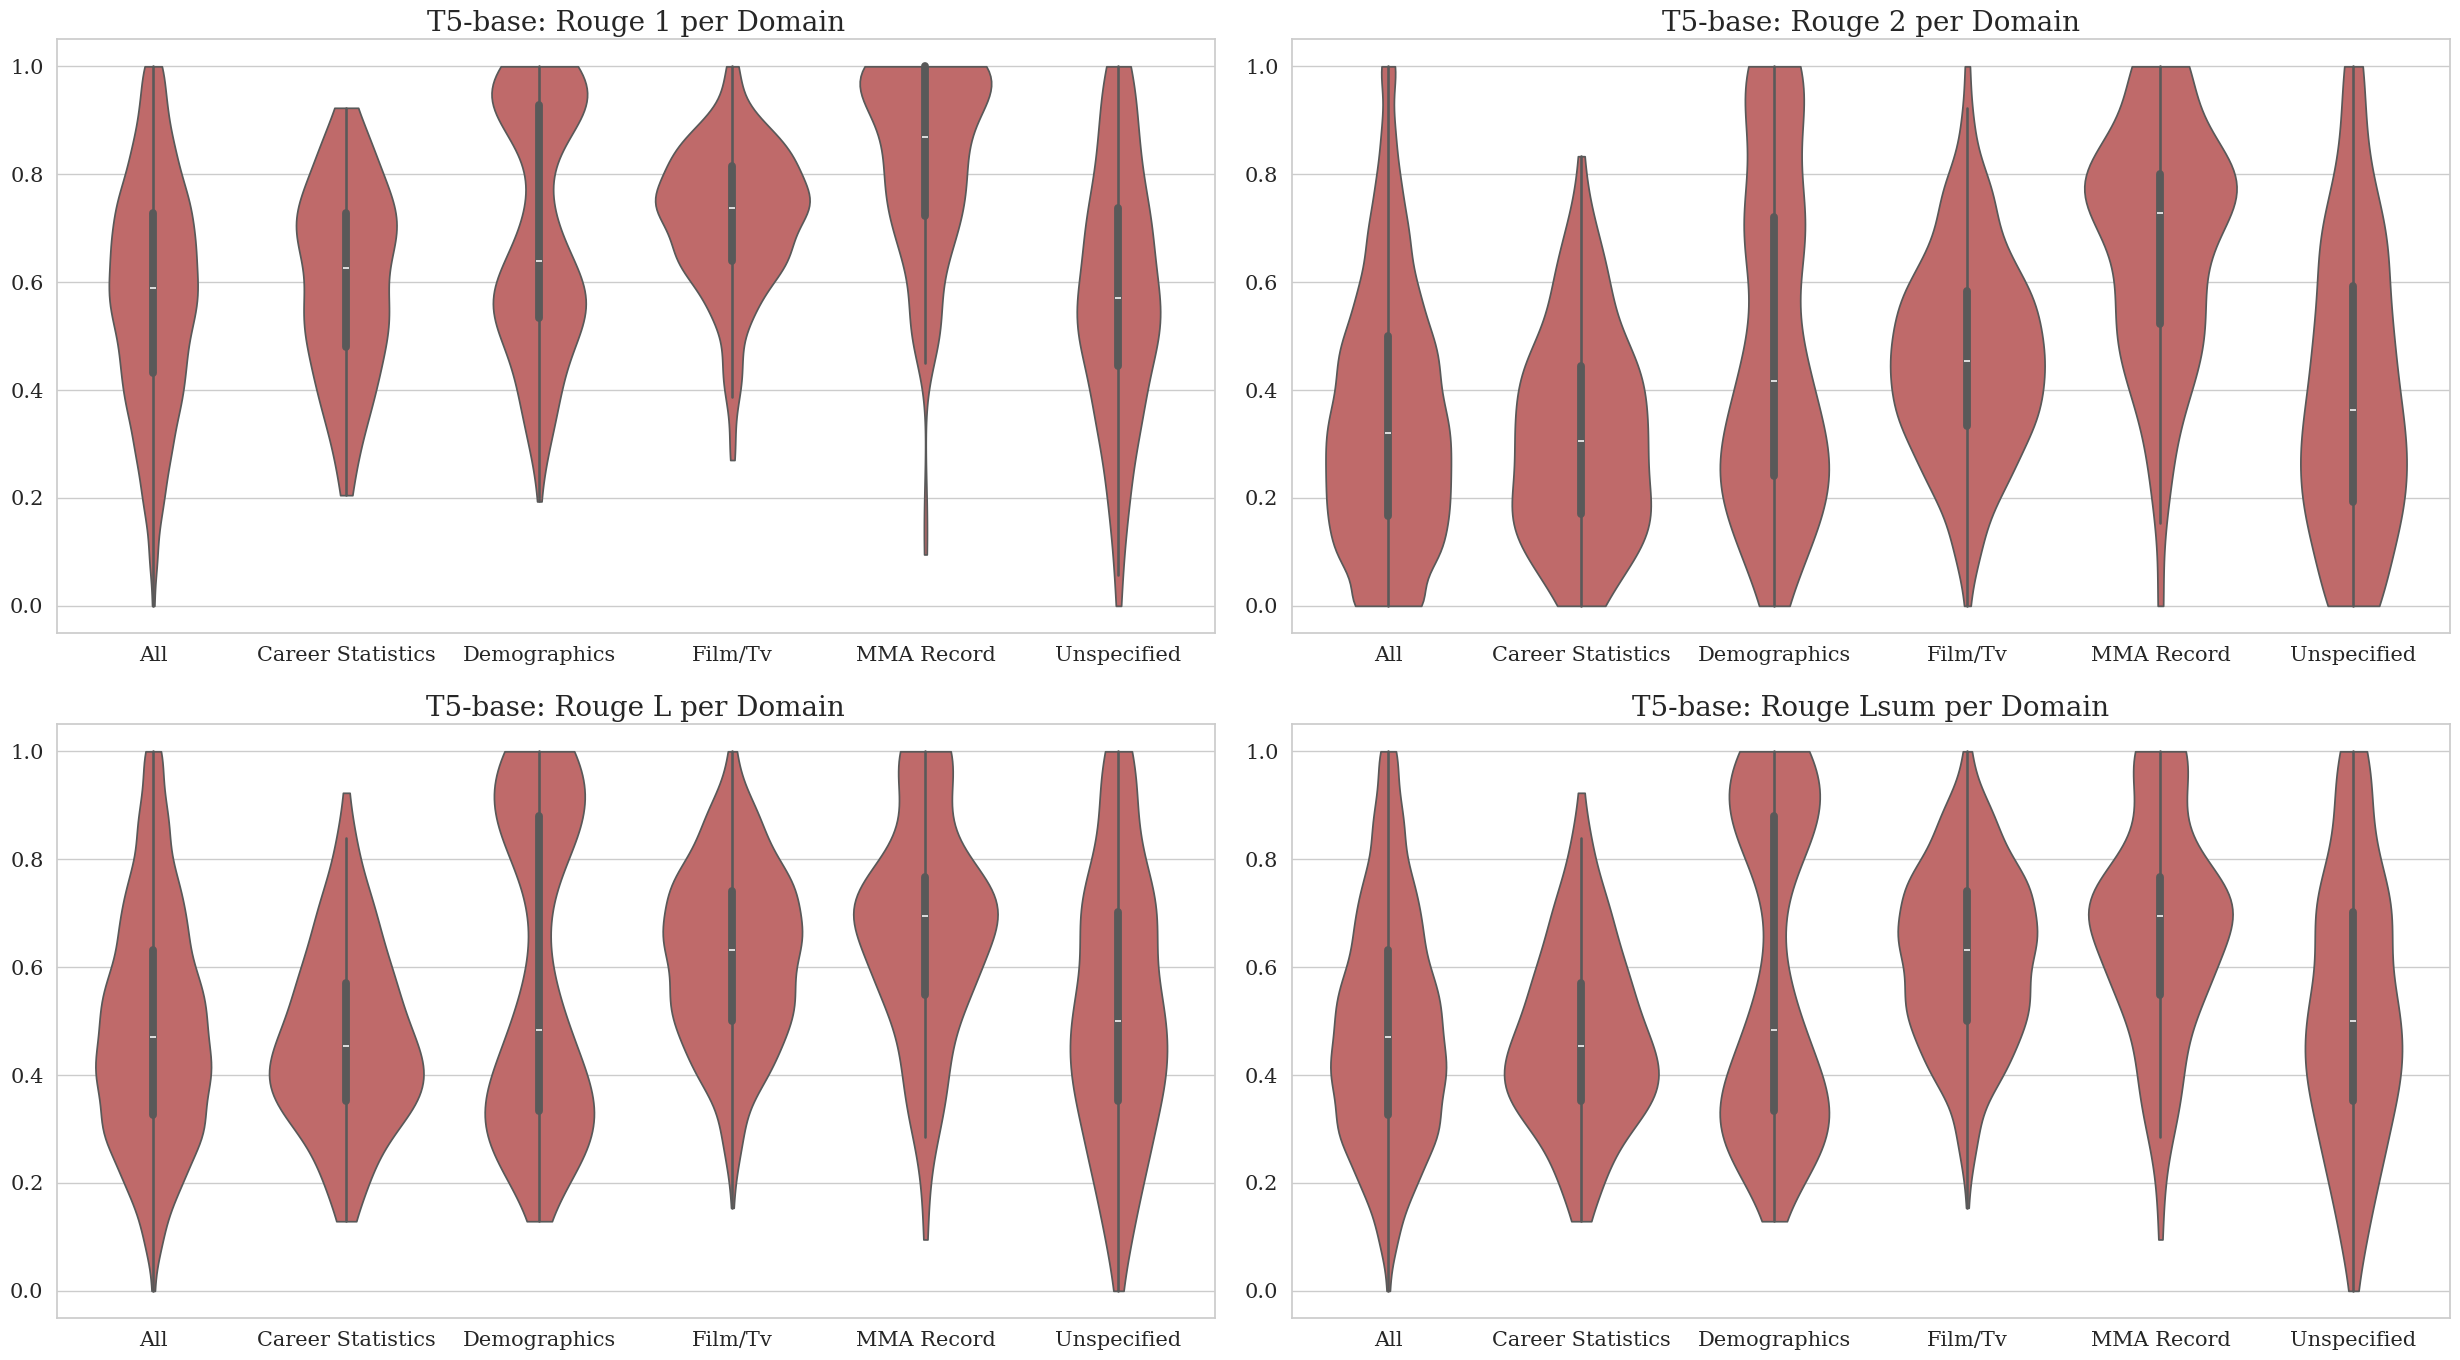

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Set the global style for the plots
sns.set(style="whitegrid")

# Set the font properties
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

# Create a trellis plot with two violinplots
plt.figure(figsize=(25, 14))

# Plot for Rouge1
plt.subplot(2, 2, 1)
sns.violinplot(x="Domain", y="Rouge1", data=combined_df, color="indianred",cut=0)
plt.title("T5-base: Rouge 1 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for Rouge2
plt.subplot(2, 2, 2)
sns.violinplot(x="Domain", y="Rouge2", data=combined_df, color="indianred",cut=0)
plt.title("T5-base: Rouge 2 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeL
plt.subplot(2, 2, 3)
sns.violinplot(x="Domain", y="Rouge-L", data=combined_df, color="indianred",cut=0)
plt.title("T5-base: Rouge L per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeLsum
plt.subplot(2, 2, 4)
sns.violinplot(x="Domain", y="Rouge-Lsum", data=combined_df, color="indianred",cut=0)
plt.title("T5-base: Rouge Lsum per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


##**BART-base**
---
[Hugging Face Page](https://huggingface.co/facebook/bart-base)

Downloading and importing all necessary packages.

In [ ]:
! pip install transformers -q
! pip install datasets  -q
! pip install sentencepiece -q
! pip install rouge_score -q
! pip install wandb -q

In [ ]:
import torch
import numpy as np
import datasets

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)

from tabulate import tabulate
import nltk
from datetime import datetime

### Model and tokenizer



In [ ]:
model_name ='facebook/bart-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# setting max sequence length for tokenization
encoder_max_length = 1024
decoder_max_length = 128

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Data Preprocessing



**Preparation**\
Add "summarize" infront of the text to denote the task and then turn everything into a HF object.

In [ ]:
df_train["Table to Text"] = "summarize: " + df_train["Table to Text"].astype(str)


In [ ]:
!pip install torch datasets -q
from datasets import Dataset
train = Dataset.from_pandas(df_train)
valid = Dataset.from_pandas(df_val)
test = Dataset.from_pandas(df_test)

**Preprocess and tokenize**

Let's now tokenize the data of each batch and replace padding tokens in the target sequences with -100. Tokens with a label of -100 are ignored during the computation of the loss.

In [ ]:
#source: https://colab.research.google.com/github/elsanns/xai-nlp-notebooks/blob/master/fine_tune_bart_summarization_two_langs.ipynb

def batch_tokenize_preprocess(batch, tokenizer, max_source_length, max_target_length):
    source, target = batch["Table to Text"], batch["Anotation"]
    source_tokenized = tokenizer(
        source, padding="max_length", truncation=True, max_length=max_source_length
    )
    target_tokenized = tokenizer(
        target, padding="max_length", truncation=True, max_length=max_target_length
    )

    batch = {k: v for k, v in source_tokenized.items()}
    # Ignore padding in the loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in target_tokenized["input_ids"]
    ]
    return batch


train_data = train.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=train.column_names,
)

validation_data = valid.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=valid.column_names,
)

Map:   0%|          | 0/23650 [00:00<?, ? examples/s]

Map:   0%|          | 0/12076 [00:00<?, ? examples/s]

In [ ]:
# Source: https://github.com/huggingface/transformers/blob/master/examples/seq2seq/run_summarization.py

nltk.download("punkt", quiet=True)

metric = datasets.load_metric("rouge")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results from ROUGE
    result = {key: value.mid.fmeasure for key, value in result.items()} #*100

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

<ipython-input-37-460208a3324d>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="facebook/bart-base")

###Hyperparameter-tuning

In [ ]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-5, 2e-6,2e-4]) ,
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4,8,16]),
    }

In [ ]:
def model_init(trial):
    return  AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="bart-base_on_ToTTo",
    evaluation_strategy="epoch",
    save_strategy= "epoch",
    learning_rate=2e-5,
    metric_for_best_model = 'eval_loss',
    weight_decay=0.01,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    auto_find_batch_size=True

)

In [ ]:
trainer = Seq2SeqTrainer(
    model=None,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator

)

In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
def my_objective(metrics):
    eval_loss = metrics["eval_loss"]
    return eval_loss

In [ ]:
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

best_trial = trainer.hyperparameter_search(
    direction="minimize",
    sampler=TPESampler(),
    pruner=HyperbandPruner(),
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=3,
    compute_objective=my_objective,
)

[I 2024-02-02 11:41:09,405] A new study created in memory with name: no-name-8b055089-3323-465d-89ed-9ee369906df3


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


wandb: Currently logged in as: depiethefreespirit (myteam1234567). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
[I 2

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
[I 2

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
[I 2024-02-02 15:49:23,970] Trial 2 finished with value: 1.6814801692962646 and parameters: {'learning_rate': 0.0002, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 1.5785309076309204.


In [ ]:
best_params=best_trial.hyperparameters

In [ ]:
import pickle
# Save to a pickle file
with open('best_params.pkl', 'wb') as pickle_file:
    pickle.dump(best_params, pickle_file)

### Training



Let's now define the training arguments and pass them to the trainer. We train the model for 4 epochs with a batch size of 8 per device. The learning rate is again 2e-5 the weight decay is 0.01 to prevent the model from getting more complex than it is required. We use a 16 bit floating point to save memory and time. Last but not least, the evaluation is performed at the completion of each epoch.

In [ ]:
best_params={'learning_rate': 2e-05, 'per_device_train_batch_size': 8}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="Finetuned_BART-base",
    num_train_epochs=4,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    weight_decay=0.01,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=50,
    save_total_limit=3,
    fp16=True,
)

#create a DataCollator that will take care of padding our inputs and labels.
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Moving on to training:

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=11828, training_loss=1.7771971811907978, metrics={'train_runtime': 5458.2371, 'train_samples_per_second': 17.332, 'train_steps_per_second': 2.167, 'total_flos': 5.7681068949504e+16, 'train_loss': 1.7771971811907978, 'epoch': 4.0})

In [ ]:
trainer.save_model("Finetuned_BART-base")

In [ ]:
#edit this!
loss={'Epoch':[1,2,3,4],"Training Loss":[1.791500	,1.659800,1.713300	,1.614800],'Validation Loss':[1.670169,1.591462,1.556910,1.548805]}
df_loss=pd.DataFrame(loss)
df_loss


Epoch  Training Loss  Validation Loss
0      1         1.7915         1.670169
1      2         1.6598         1.591462
2      3         1.7133         1.556910
3      4         1.6148         1.548805

There are no signs of overfitting or underfitting. Maybe there would be if we trained the model for more epochs as the training loss starts to increase.

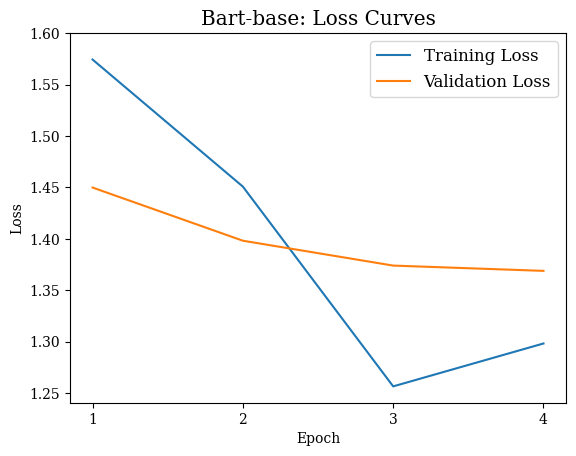

In [ ]:
#edit
df_loss['Training Loss'].plot(kind='line', label='Training Loss')
df_loss['Validation Loss'].plot(kind='line', label='Validation Loss')
plt.xticks(range(len(df_loss)), [1, 2, 3, 4])
plt.ylim(top=1.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bart-base: Loss Curves')
plt.legend()

###**Save Finetuned Model to HF**

In [ ]:
fine_tuned_model = trainer.model

fine_tuned_model.push_to_hub("BART-base-ToTTo")
tokenizer.push_to_hub("BART-base-ToTTo")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Depie/BART-base-ToTTo/commit/890bea4ea0708e78189b9f3a6b1127e2d8964177', commit_message='Upload tokenizer', commit_description='', oid='890bea4ea0708e78189b9f3a6b1127e2d8964177', pr_url=None, pr_revision=None, pr_num=None)

### Evaluation



In [ ]:
! pip install -q evaluate rouge_score sacrebleu meteor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import evaluate

rouge = evaluate.load("rouge",seed=42)
bleu =evaluate.load("sacrebleu",seed=42)
meteor=evaluate.load("meteor",seed=42)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Depie/BART-base-ToTTo",device=0)
model = AutoModelForSeq2SeqLM.from_pretrained("Depie/BART-base-ToTTo")
summarizer = pipeline("summarization", model=model,tokenizer=tokenizer,device=0)

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

####All

Let's now print the Anotations and the Generated Summaries of the first 3 tables of the test dataset.

In [ ]:
summaries = {}
for i, text in enumerate(df_test['Table to Text'].head(3)):
        text = "summarize: " + text
        summaries[i] = summarizer(text,min_length=5,max_length=30)
        print(f"Table {i}\nGenerated Summary: {summaries[i][0]['summary_text']}\nAnotation: {df_test['Anotation'].iloc[i]}\n")


Table 0
Generated Summary: Daniel Henry Chamberlain was the 76th Governor of South Carolina.
Anotation: Daniel Henry Chamberlain was the 76th Governor of South Carolina from 1874.

Table 1
Generated Summary: Alma Jodorowsky played Evelyn in the 2016 Kids in Love.
Anotation: Alma Jodorowsky had the role of Evelyn in 2016 film Kids in Love.

Table 2
Generated Summary: A. J. Hawk finished the 2006 season with 119 tackles, nine sacks, and three forced fumbles.
Anotation: In his rookie season, Hawk led with 119 total tackles.



**Experiment**

What if we are intrested in another piece of information? We will change the focal point in Table 1 (above) to make an experiment. If we are intrested only in the short films that Alma Jodorowsky participated, the pre-existing "Focus on:2016 Kids in Love Evelyn" part of the template changes to "Focus on: sort film". Let's see how the model does.

In [ ]:
df_test['Table to Text'].iloc[1]

'Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: 2016 Kids in Love Evelyn, Table Structure: 11 rows,

The generated output below provides information about the name of the film as well as the role of Alma Jodorowsky. Again we notice that the model is case-sensitive and produces different results regarding the way that the new input is given.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

inputs=["SHORT FILM","Short Film","Short film","short film"]

for input in inputs:
  text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
  print(f"{input}: {summarizer(text,min_length=3,max_length=50)[0]['summary_text']}")

SHORT FILM: Alma Jodorowsky starred as Alma in the short film SHORT FILM.
Short Film: Alma Jodorowsky made her short film debut in 2011 as Alma in the short film The Starry Sky Above Me.
Short film: Alma Jodorowsky appeared in a short film, "Aquake to Emptiness", in 2011.
short film: Alma Jodorowsky appeared in the short film "Alma" in 2011.


Let's take this a step further and add to the "focus on" part the word "year". As we can see the model understands that the user is asking information about the year of release and adds it to the response.

In [ ]:
input="short film, year"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=100)[0]['summary_text']

'Alma Jodorowsky appeared in a short film, Awake to Emptiness, in 2011.'

What is going to happen if the focus on part includes words that are not part of the table? Let's say we are intrested in finding out which was the first movie that Alma appeared. In this case we will add in the "focus on" part the bigram "first film" alng with the name of the actress.

We observe that the model accurately conveys the requested information.

In [ ]:
input="Alma Jodorowsky, first film"
text=f"Summarize: Table page title: Alma Jodorowsky, Table section title: Filmography, Table section text: , Table converted to text: Year is 2006, Title is Gaspard le Bandit, Role is Mathilde de Varade, Notes is Period TV film. Year is 2011, Title is Eyes Find Eyes, Role is Estelle, Notes is . Year is 2011, Title is Section de recherche, Role is Caroline, Notes is Police TV series (1 episode: No.5.3). Year is 2011, Title is Awake to Emptiness, Role is Alma, Notes is Short film. Year is 2012, Title is Sea, No Sex and Sun, Role is Diane, Notes is . Year is 2013, Title is Blue Is the Warmest Colour, Role is Béatrice, Notes is . Year is 2014, Title is La Vie devant elles fr, Role is Solana, Notes is TV series by Gabriel Aghion (6 episodes). Year is 2016, Title is Kids in Love, Role is Evelyn, Notes is Ealing Studios. Year is 2017, Title is The Starry Sky Above Me, Role is Justyna, Notes is . Year is TBA, Title is Smiley, Role is TBA, Notes is , Focus on: {input}, Table Structure: 11 rows, 4 columns"
summarizer(text,min_length=3,max_length=200)[0]['summary_text']

'Alma Jodorowsky made her film debut in 2006 with Gaspard le Bandit.'

**Getting all summaries**\
Let's now get the summaries for all tables of the test set. Since it requires much time I chose to split the dataset into 5 subsets.

In [ ]:
import numpy as np

# Split the DataFrame into 5 subsets
df_subsets = np.array_split(df_test,5)


In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch
import gc

tokenizer = AutoTokenizer.from_pretrained("Depie/BART-base-ToTTo",device=0)
summarizer = pipeline("summarization", model="Depie/BART-base-ToTTo",tokenizer=tokenizer,device=0)
model = AutoModelForSeq2SeqLM.from_pretrained("Depie/BART-base-ToTTo").to(device=0)

summaries_Bart = {}
for j in range(0,len(df_subsets)):
  with tqdm(total=len(df_subsets[j]), desc=f"Processing subset {j}") as pbar:
      for i, text in enumerate(df_subsets[j]['Table to Text']):
        if len(text)<=1024: #Max input length is 1024
          text = "summarize: " + text
          summaries_Bart[i] = summarizer(text,max_length=30,min_length=5)
          pbar.update(1)
          gc.collect()

        else: #If the input length is greater than 1024 do chuncking

          # Tokenize without truncation
          inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

          # Get batches of tokens corresponding to the exact model_max_length
          chunk_start = 0
          chunk_end = tokenizer.model_max_length
          inputs_batch_lst = []

          while chunk_start < len(inputs_no_trunc['input_ids'][0]):
              inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
              inputs_batch = torch.unsqueeze(inputs_batch, 0).to(device=0)
              inputs_batch_lst.append(inputs_batch)
              chunk_start += tokenizer.model_max_length
              chunk_end += tokenizer.model_max_length

          # Generate a summary on each batch
          summary_ids_lst = [model.generate(inputs.to(device=0), num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

          # Decode the output and join into one string with one paragraph per summary batch
          summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
          summaries_Bart[i] = '\n'.join(summary_batch_lst)
          pbar.update(1)
          gc.collect()


  # Save the dictionary as a pickle file
  with open(f'summaries_Bart_{j+1}.pkl', 'wb') as file:
    pickle.dump(summaries_Bart , file)

Processing subset 4: 100%|██████████| 1540/1540 [18:23<00:00,  1.39it/s]


Load the summaries and put them in a single dictionary.

In [ ]:
sum_paths=['/content/summaries_Bart_1.pkl' ,'/content/summaries_Bart_2.pkl','/content/summaries_Bart_3.pkl'
           ,'/content/summaries_Bart_4.pkl','/content/summaries_Bart_5.pkl']

import pickle
summaries={}
for path in range(len(sum_paths)):
  with open(sum_paths[path], 'rb') as file:
      summaries[path] = pickle.load(file)

In [ ]:
#adjusting the keys and putting everything into a dictionary
new_starting_key = 1540

summaries_Bart={}
for i in summaries.keys():
    summaries[i] = {key + new_starting_key * i: value for key, value in summaries[i].items()}
    summaries_Bart.update(summaries[i])


In [ ]:
for key, value in summaries_Bart.items():
    if isinstance(value, list):
        # If the value is a list, check if it contains a dictionary
        for item in value:
            if isinstance(item, dict):
                # If it's a dictionary, extract the 'summary_text' and update the value
                summary_text = item.get('summary_text', '')
                summaries_Bart[key] = summary_text

Next, we compute the f1 rouge score, the bleu score and meteor for each generated summary - anotation pair and then we calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_bleu={}
Bart_rouge={}
Bart_meteor={}

for s in tqdm(summaries_Bart.keys()):
  preds = [summaries_Bart[s]]
  labels = [df_test['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_rouge[s]=score_r
  Bart_bleu[s]=score_b
  Bart_meteor[s]=score_m

100%|██████████| 7700/7700 [18:12<00:00,  7.05it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_rouge.keys():
  sum_r1+=Bart_rouge[key]['rouge1']
  sum_r2+=Bart_rouge[key]['rouge2']
  sum_rL+=Bart_rouge[key]['rougeL']
  sum_rLsum+=Bart_rouge[key]['rougeLsum']
  sumbleu+=Bart_bleu[key]['score']
  sum_meteor+=Bart_meteor[key]['meteor']

  r1_list.append(Bart_rouge[key]['rouge1'])
  r2_list.append(Bart_rouge[key]['rouge2'])
  rL_list.append(Bart_rouge[key]['rougeL'])
  rLsum_list.append(Bart_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_bleu[key]['score'])
  meteor_list.append(Bart_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_rouge.keys())
avg_r2=sum_r2/len(Bart_rouge.keys())
avg_rL=sum_rL/len(Bart_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_rouge.keys())
avg_bleu=sumbleu/len(Bart_bleu.keys())
avg_meteor=sum_meteor/len(Bart_meteor.keys())

print(f"""---------Bart-base-All--------\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {min(r1_list)} | Max: {max(r1_list)}
Rouge-2 | Min: {min(r2_list)} | Max: {max(r2_list)}
Rouge-L | Min: {min(rL_list)} | Max: {max(rL_list)}
Rouge-Lsum | Min: {min(rLsum_list)} | Max: {max(rLsum_list)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---------Bart-base-All--------

        Average
Rouge-1: 0.56
Rouge-2: 0.35
Rouge-L: 0.47
Rouge-Lsum: 0.48
SacreBleu: 22.5
Meteor: 0.53

        Median
Rouge-1: 0.56
Rouge-2: 0.31
Rouge-L: 0.44
Rouge-Lsum: 0.46
SacreBleu: 14.57
Meteor: 0.53

    Standard Deviation
Rouge-1: 0.23
Rouge-2: 0.24
Rouge-L: 0.23
Rouge-Lsum: 0.23
SacreBleu: 22.03
Meteor: 0.22

  Minimum/Maximum
Rouge-1 | Min: 0.0 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.0 | Max: 1.0
Rouge-Lsum | Min: 0.0 | Max: 1.0
SacreBleu | Min: 0.03 | Max: 100.0
Meteor| Min: 0.03 | Max: 1.0




In [ ]:
#put all averages in a dictionary
Bart_All_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_All_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_All_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_All=[Bart_All_avg_all, Bart_All_median_all, Bart_All_sd_all]
for metric, metric_name in zip(metrics_Bart_All, ['Bart_All_avg_all', 'Bart_All_median_all', 'Bart_All_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

**Plots**\
Let's now create some violin plots to see the distribution of each score as well as to check for outliers.

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_All_bart=pd.DataFrame(Bart_metrics)
df_All_bart

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0     0.923077  0.916667  0.923077    0.923077  80.910671  0.983055
1     0.833333  0.545455  0.750000    0.750000  44.702465  0.777937
2     0.357143  0.076923  0.285714    0.285714   4.724933  0.374681
3     0.303030  0.129032  0.181818    0.181818   6.054507  0.195789
4     0.243243  0.166667  0.243243    0.216216  10.750002  0.392985
...        ...       ...       ...         ...        ...       ...
7695  0.636364  0.200000  0.454545    0.454545   6.917184  0.551255
7696  0.425532  0.177778  0.340426    0.340426   6.717703  0.400000
7697  0.711111  0.372093  0.577778    0.577778  31.652989  0.681331
7698  0.727273  0.600000  0.727273    0.727273  36.269829  0.649510
7699  0.377778  0.159091  0.266667    0.333333   4.294725  0.357346

[7700 rows x 6 columns]

In [ ]:
with open(f'df_All_Bart.pkl', 'wb') as file:
        pickle.dump(df_All_bart, file)

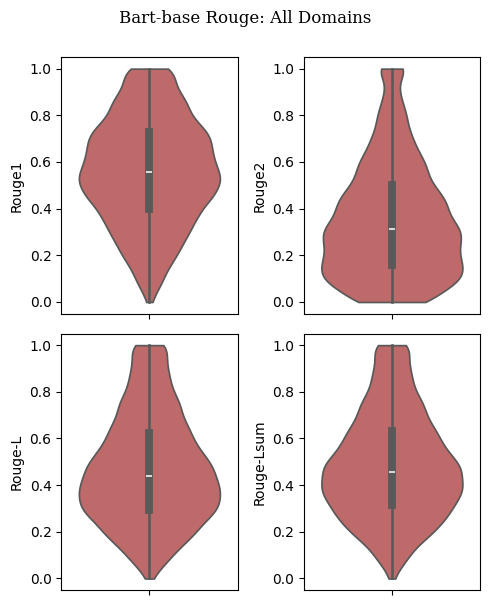

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
sns.violinplot(data=df_All_bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
sns.violinplot(data=df_All_bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
sns.violinplot(data=df_All_bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
sns.violinplot(data=df_All_bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Rouge: All Domains", fontdict=title_font, y=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

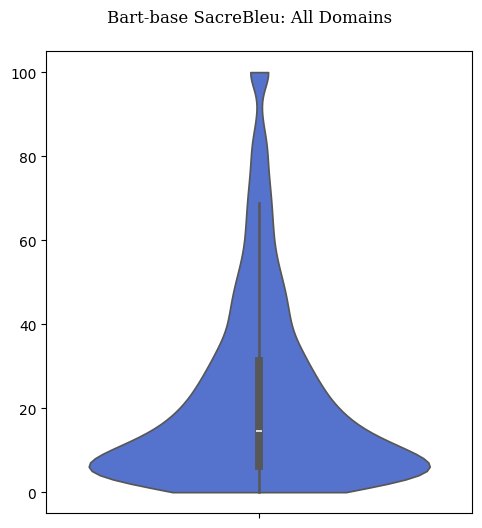

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5.5, 6))
ax=sns.violinplot(data=df_All_bart, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base SacreBleu: All Domains ", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

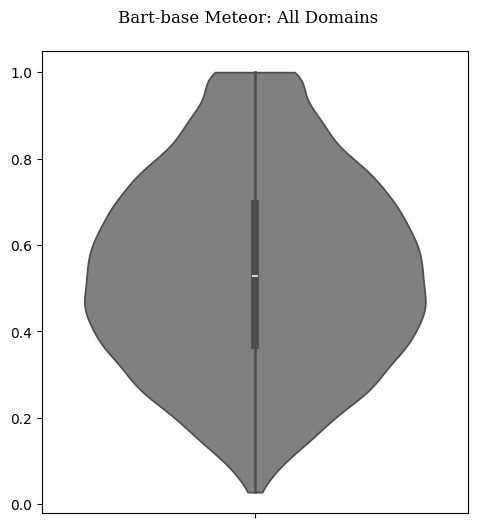

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5.5, 6))
ax=sns.violinplot(data=df_All_bart, y="Meteor", color="gray", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: All Domains", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Top 5 Domains
In this section, we will assess the model's performance on tables originating from the 5 most prevalent domains found in the dataset. A separate evaluation by category will take place.

In [ ]:
#Replacing "Film","Filmography" & "Television" with "Film/TV "
df_test['table_section_title'] = df_test['table_section_title'].replace(['Filmography','Film','Television'], 'Film/TV')

In [ ]:
df_test.table_section_title.value_counts().head(5)

Film/TV                      600
Demographics                 417
                             336
Mixed martial arts record    158
Career statistics            152
Name: table_section_title, dtype: int64

#####**Domain:** Film/Tv

In [ ]:
FilmTv = df_test[df_test['table_section_title'].isin(['Film/TV'])]
FilmTv

Table to Text  \
1     Table page title: Alma Jodorowsky, Table secti...   
6     Table page title: Julian Sands, Table section ...   
35    Table page title: Jennie Garth, Table section ...   
70    Table page title: Melissa George, Table sectio...   
94    Table page title: Marcia Strassman, Table sect...   
...                                                 ...   
7659  Table page title: Ruth Gemmell, Table section ...   
7660  Table page title: Keiynan Lonsdale, Table sect...   
7661  Table page title: Péter Scherer, Table section...   
7690  Table page title: Aidan McArdle, Table section...   
7691  Table page title: Karl Malden, Table section t...   

                                              Anotation table_section_title  
1     Alma Jodorowsky had the role of Evelyn in 2016...             Film/TV  
6     In 2012, Julian Sands played as Alistair Wesle...             Film/TV  
35    In 2008, Garth starred as Kelly Taylor in "902...             Film/TV  
70    Melissa George starred in Charmed and, in 2003...             Film/TV  
94    Marcia Strassman played Nancy Sterngood on the...             Film/TV  
...                                                 ...                 ...  
7659  In 1996, Gemmell appeared as Kerry Cox in the ...             Film/TV  
7660  Keiynan Lonsdale played Uriah Pedrad in The Di...             Film/TV  
7661  Péter Scherer appeared in Miklós Jancsó’s movi...             Film/TV  
7690  In 2004, Aidan McArdle played Slannen in the f...             Film/TV  
7691  Malden portrayed Leon Klinghoffer in the 1989 ...             Film/TV  

[600 rows x 3 columns]

In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from tqdm import tqdm
import torch
import gc

FilmTv_summaries_Bart = {}

for i, text in tqdm(enumerate(FilmTv['Table to Text']),total=len(FilmTv['Table to Text'])):
  if len(text)<=1024: #Max input length is 1024
    text = "summarize: " + text
    FilmTv_summaries_Bart[i] = summarizer(text,max_length=50,min_length=5)[0]['summary_text']

  else: #If the input length is greater than 1024 do chuncking

    # Tokenize without truncation
    inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

    # Get batches of tokens corresponding to the exact model_max_length
    chunk_start = 0
    chunk_end = tokenizer.model_max_length
    inputs_batch_lst = []

    while chunk_start < len(inputs_no_trunc['input_ids'][0]):
        inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
        inputs_batch = torch.unsqueeze(inputs_batch, 0)
        inputs_batch = inputs_batch.to("cuda:0")
        inputs_batch_lst.append(inputs_batch)
        chunk_start += tokenizer.model_max_length
        chunk_end += tokenizer.model_max_length

    # Generate a summary on each batch
    summary_ids_lst = [model.generate(inputs, num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

    # Decode the output and join into one string with one paragraph per summary batch
    summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
    summary = '\n'.join(summary_batch_lst)
    FilmTv_summaries_Bart[i] = summary[0]['summary_text'] if isinstance(summary, list) and len(summary) > 0 else summary





100%|██████████| 600/600 [02:32<00:00,  3.93it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_FilmTv_bleu={}
Bart_FilmTv_rouge={}
Bart_FilmTv_meteor={}

for s in tqdm(list(FilmTv_summaries_Bart.keys())):
  preds = [FilmTv_summaries_Bart[s]]
  labels = [FilmTv['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_FilmTv_rouge[s]=score_r
  Bart_FilmTv_bleu[s]=score_b
  Bart_FilmTv_meteor[s]=score_m

100%|██████████| 600/600 [01:25<00:00,  7.00it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_FilmTv_rouge.keys():
  sum_r1+=Bart_FilmTv_rouge[key]['rouge1']
  sum_r2+=Bart_FilmTv_rouge[key]['rouge2']
  sum_rL+=Bart_FilmTv_rouge[key]['rougeL']
  sum_rLsum+=Bart_FilmTv_rouge[key]['rougeLsum']
  sumbleu+=Bart_FilmTv_bleu[key]['score']
  sum_meteor+=Bart_FilmTv_meteor[key]['meteor']

  r1_list.append(Bart_FilmTv_rouge[key]['rouge1'])
  r2_list.append(Bart_FilmTv_rouge[key]['rouge2'])
  rL_list.append(Bart_FilmTv_rouge[key]['rougeL'])
  rLsum_list.append(Bart_FilmTv_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_FilmTv_bleu[key]['score'])
  meteor_list.append(Bart_FilmTv_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_FilmTv_rouge.keys())
avg_r2=sum_r2/len(Bart_FilmTv_rouge.keys())
avg_rL=sum_rL/len(Bart_FilmTv_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_FilmTv_rouge.keys())
avg_bleu=sumbleu/len(Bart_FilmTv_bleu.keys())
avg_meteor=sum_meteor/len(Bart_FilmTv_meteor.keys())

print(f"""---Bart-base-Film/Tv-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

In [ ]:
#put all averages in a dictionary
Bart_FilmTv_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_FilmTv_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_FilmTv_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_FilmTv=[Bart_FilmTv_avg_all, Bart_FilmTv_median_all, Bart_FilmTv_sd_all]
for metric, metric_name in zip(metrics_Bart_FilmTv, ['Bart_FilmTv_avg_all', 'Bart_FilmTv_median_all', 'Bart_FilmTv_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_FilmTv_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_FilmTv_Bart=pd.DataFrame(Bart_FilmTv_metrics)
df_FilmTv_Bart

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.782609  0.380952  0.695652    0.695652  25.519652  0.684307
1    0.814815  0.640000  0.814815    0.814815  46.196565  0.738292
2    0.777778  0.500000  0.777778    0.777778  21.648694  0.642843
3    0.571429  0.315789  0.476190    0.476190  15.165685  0.480806
4    0.529412  0.187500  0.352941    0.411765   6.773639  0.534516
..        ...       ...       ...         ...        ...       ...
595  0.606061  0.322581  0.484848    0.606061  14.153945  0.786713
596  0.956522  0.857143  0.869565    0.869565  73.111045  0.861341
597  0.647059  0.312500  0.529412    0.529412  12.013384  0.467446
598  0.761905  0.421053  0.666667    0.666667  36.676256  0.726744
599  0.903226  0.689655  0.838710    0.838710  61.337060  0.917147

[600 rows x 6 columns]

In [ ]:
with open(f'df_FilmTv_Bart.pkl', 'wb') as file:
        pickle.dump(df_FilmTv_Bart, file)

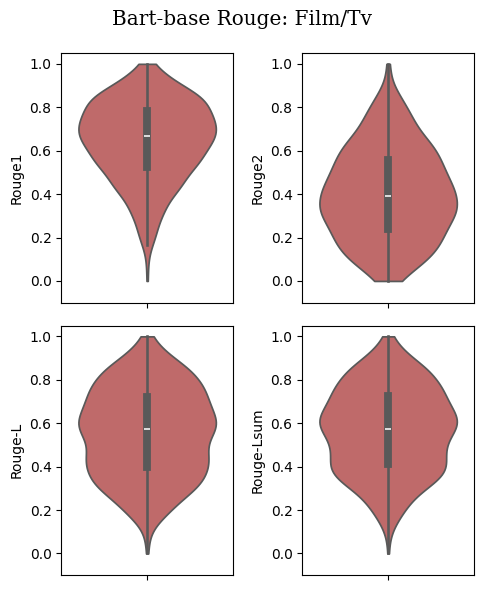

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_FilmTv_Bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_FilmTv_Bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_FilmTv_Bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_FilmTv_Bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("Bart-base Rouge: Film/Tv", y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

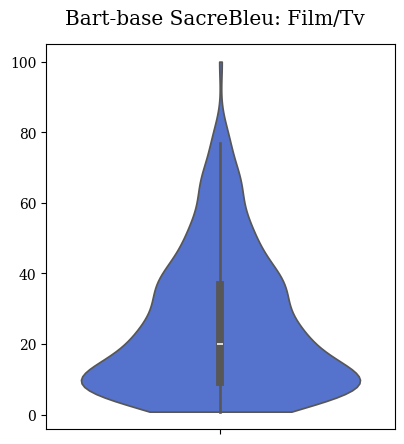

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_Bart, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("Bart-base SacreBleu: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

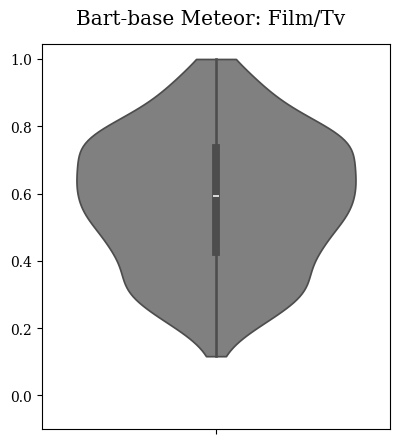

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_FilmTv_Bart, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: Film/Tv", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Demographics

In [ ]:
demographics = df_test[df_test['table_section_title'].isin(['Demographics'])]
demographics

Table to Text  \
26    Table page title: Arrow Point, Missouri, Table...   
42    Table page title: Calais, Table section title:...   
46    Table page title: Monument, Oregon, Table sect...   
52    Table page title: Seffner, Florida, Table sect...   
53    Table page title: Velda City, Missouri, Table ...   
...                                                 ...   
7673  Table page title: Cortland County, New York, T...   
7675  Table page title: Tarlac City, Table section t...   
7687  Table page title: Stinesville, Indiana, Table ...   
7688  Table page title: Wilson, St. Croix County, Wi...   
7695  Table page title: Hobart, Oklahoma, Table sect...   

                                              Anotation table_section_title  
26    As of the census of 2000, there were 133 peopl...        Demographics  
42    There was a massive growth in population of Ca...        Demographics  
46    As of the census of 2010, there were 128 peopl...        Demographics  
52    The population of Seffner was 7,579 at the 201...        Demographics  
53    As of the census of 2010, there were 1,420 peo...        Demographics  
...                                                 ...                 ...  
7673  As of the 2010 census, the population of Cortl...        Demographics  
7675  According to the 2015 census, Tarlac City has ...        Demographics  
7687  According to 2010 census, the population was 1...        Demographics  
7688  As of the census of 2010, there were 184 peopl...        Demographics  
7695       Hobart became the residence of 2,936 people.        Demographics  

[417 rows x 3 columns]

In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from tqdm import tqdm
import torch
import gc

demographics_summaries_Bart = {}

for i, text in tqdm(enumerate(demographics['Table to Text']),total=len(demographics['Table to Text'])):
  if len(text)<=1024: #Max input length is 1024
    text = "summarize: " + text
    demographics_summaries_Bart[i] = summarizer(text,max_length=50,min_length=5)[0]['summary_text']

  else: #If the input length is greater than 1024 do chuncking

    # Tokenize without truncation
    inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

    # Get batches of tokens corresponding to the exact model_max_length
    chunk_start = 0
    chunk_end = tokenizer.model_max_length
    inputs_batch_lst = []

    while chunk_start < len(inputs_no_trunc['input_ids'][0]):
        inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
        inputs_batch = torch.unsqueeze(inputs_batch, 0)
        inputs_batch = inputs_batch.to("cuda:0")
        inputs_batch_lst.append(inputs_batch)
        chunk_start += tokenizer.model_max_length
        chunk_end += tokenizer.model_max_length

    # Generate a summary on each batch
    summary_ids_lst = [model.generate(inputs, num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

    # Decode the output and join into one string with one paragraph per summary batch
    summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
    summary = '\n'.join(summary_batch_lst)
    demographics_summaries_Bart[i] = summary[0]['summary_text'] if isinstance(summary, list) and len(summary) > 0 else summary





100%|██████████| 417/417 [01:15<00:00,  5.55it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_demographics_bleu={}
Bart_demographics_rouge={}
Bart_demographics_meteor={}

for s in tqdm(demographics_summaries_Bart.keys()):
  preds = [demographics_summaries_Bart[s]]
  labels = [demographics['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_demographics_rouge[s]=score_r
  Bart_demographics_bleu[s]=score_b
  Bart_demographics_meteor[s]=score_m

100%|██████████| 417/417 [00:59<00:00,  6.98it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_demographics_rouge.keys():
  sum_r1+=Bart_demographics_rouge[key]['rouge1']
  sum_r2+=Bart_demographics_rouge[key]['rouge2']
  sum_rL+=Bart_demographics_rouge[key]['rougeL']
  sum_rLsum+=Bart_demographics_rouge[key]['rougeLsum']
  sumbleu+=Bart_demographics_bleu[key]['score']
  sum_meteor+=Bart_demographics_meteor[key]['meteor']

  r1_list.append(Bart_demographics_rouge[key]['rouge1'])
  r2_list.append(Bart_demographics_rouge[key]['rouge2'])
  rL_list.append(Bart_demographics_rouge[key]['rougeL'])
  rLsum_list.append(Bart_demographics_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_demographics_bleu[key]['score'])
  meteor_list.append(Bart_demographics_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_demographics_rouge.keys())
avg_r2=sum_r2/len(Bart_demographics_rouge.keys())
avg_rL=sum_rL/len(Bart_demographics_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_demographics_rouge.keys())
avg_bleu=sumbleu/len(Bart_demographics_bleu.keys())
avg_meteor=sum_meteor/len(Bart_demographics_meteor.keys())

print(f"""---Bart-base-Demographics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

---Bart-base-Demographics-Domain---

        Average
Rouge-1: 0.7
Rouge-2: 0.48
Rouge-L: 0.59
Rouge-Lsum: 0.59
SacreBleu: 37.75
Meteor: 0.62

        Median
Rouge-1: 0.64
Rouge-2: 0.4
Rouge-L: 0.5
Rouge-Lsum: 0.5
SacreBleu: 22.24
Meteor: 0.6

    Standard Deviation
Rouge-1: 0.23
Rouge-2: 0.32
Rouge-L: 0.29
Rouge-Lsum: 0.29
SacreBleu: 32.55
Meteor: 0.26

  Minimum/Maximum
Rouge-1 | Min: 0.12 | Max: 1.0
Rouge-2 | Min: 0.0 | Max: 1.0
Rouge-L | Min: 0.12 | Max: 1.0
Rouge-Lsum | Min: 0.12 | Max: 1.0
SacreBleu | Min: 0.03 | Max: 100.0
Meteor| Min: 0.03 | Max: 1.0




In [ ]:
#put all averages in a dictionary
Bart_dem_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_dem_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_dem_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_dem=[Bart_dem_avg_all, Bart_dem_median_all, Bart_dem_sd_all]
for metric, metric_name in zip(metrics_Bart_dem, ['Bart_dem_avg_all', 'Bart_dem_median_all', 'Bart_dem_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_demographics_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_demographics_Bart=pd.DataFrame(Bart_demographics_metrics)
df_demographics_Bart

Rouge1    Rouge2   Rouge-L  Rouge-Lsum   SacreBleu    Meteor
0    1.000000  1.000000  1.000000    1.000000  100.000000  0.999878
1    0.421053  0.055556  0.210526    0.210526    4.079316  0.275108
2    0.880000  0.521739  0.800000    0.800000   35.930411  0.763605
3    0.424242  0.064516  0.303030    0.303030    3.385164  0.215054
4    0.933333  0.714286  0.866667    0.866667   56.058085  0.783176
..        ...       ...       ...         ...         ...       ...
412  0.666667  0.480000  0.518519    0.518519   38.503229  0.587589
413  0.666667  0.272727  0.416667    0.416667    9.024831  0.471419
414  0.521739  0.190476  0.434783    0.434783   14.949752  0.450893
415  0.960000  0.695652  0.880000    0.880000   67.711113  0.902616
416  0.636364  0.200000  0.454545    0.454545    6.917184  0.551255

[417 rows x 6 columns]

In [ ]:
with open(f'df_demographics_Bart.pkl', 'wb') as file:
        pickle.dump(df_demographics_Bart, file)

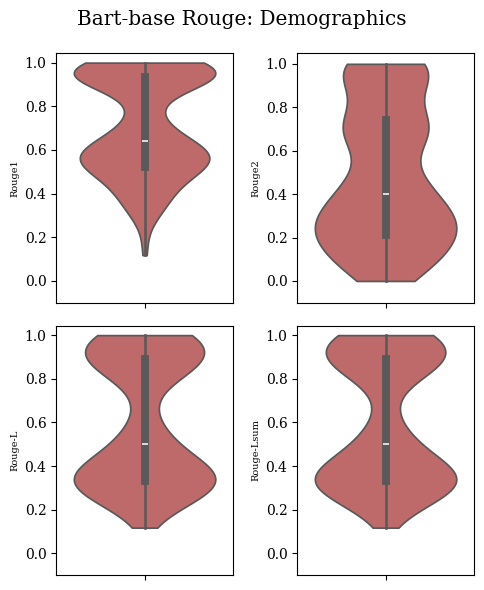

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_demographics_Bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_demographics_Bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_demographics_Bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_demographics_Bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("Bart-base Rouge: Demographics",  y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, '')

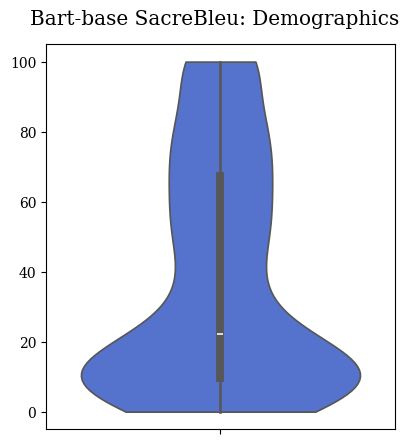

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_Bart, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("Bart-base SacreBleu: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

Text(0, 0.5, '')

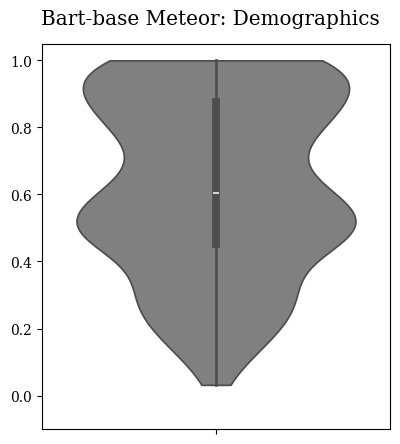

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_demographics_Bart, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: Demographics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Blank

In [ ]:
Blank = df_test[df_test['table_section_title'].isin([''])]
Blank

Table to Text  \
10    Table page title: List of Argentine films of 1...   
23    Table page title: SEAT 1200 Sport, Table secti...   
50    Table page title: List of Deputy Speakers of t...   
125   Table page title: List of dance companies, Tab...   
137   Table page title: List of Malayalam films of 1...   
...                                                 ...   
7515  Table page title: List of flag bearers for Spa...   
7585  Table page title: Philadelphia Phillies all-ti...   
7596  Table page title: List of Malayalam films of 1...   
7625  Table page title: List of Indian states and un...   
7628  Table page title: List of presidents of the Co...   

                                              Anotation table_section_title  
10          "Don Fulgencio" is a 1950 Argentinian film.                      
23    4-cylinder-inline engine through a four-speed ...                      
50    Tobias Billström served as First Deputy Speake...                      
125   The Totem Dance group is one of Ukraine's cont...                      
137   Anuraagakkodathi is a 1982 Malayalam film dire...                      
...                                                 ...                 ...  
7515  Gasol was Spain's flag bearer at the 2012 Summ...                      
7585  George McQuillan recorded a 1.79 earned run av...                      
7596  Chandrakantham is a 1974 Malayalam film, direc...                      
7625  Goa ranks with least poverty of 5.09% while al...                      
7628  John Edwin Pomfret was the twentieth president...                      

[336 rows x 3 columns]

In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from tqdm import tqdm
import torch
import gc

Blank_summaries_Bart = {}

for i, text in tqdm(enumerate(Blank['Table to Text']),total=len(Blank['Table to Text'])):
  if len(text)<=1024: #Max input length is 1024
    text = "summarize: " + text
    Blank_summaries_Bart[i] = summarizer(text,max_length=50,min_length=5)[0]['summary_text']

  else: #If the input length is greater than 1024 do chuncking

    # Tokenize without truncation
    inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

    # Get batches of tokens corresponding to the exact model_max_length
    chunk_start = 0
    chunk_end = tokenizer.model_max_length
    inputs_batch_lst = []

    while chunk_start < len(inputs_no_trunc['input_ids'][0]):
        inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
        inputs_batch = torch.unsqueeze(inputs_batch, 0)
        inputs_batch = inputs_batch.to("cuda:0")
        inputs_batch_lst.append(inputs_batch)
        chunk_start += tokenizer.model_max_length
        chunk_end += tokenizer.model_max_length

    # Generate a summary on each batch
    summary_ids_lst = [model.generate(inputs, num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

    # Decode the output and join into one string with one paragraph per summary batch
    summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
    summary = '\n'.join(summary_batch_lst)
    Blank_summaries_Bart[i] = summary[0]['summary_text'] if isinstance(summary, list) and len(summary) > 0 else summary





100%|██████████| 336/336 [05:31<00:00,  1.01it/s]


Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_Blank_bleu={}
Bart_Blank_rouge={}
Bart_Blank_meteor={}

for s in tqdm(Blank_summaries_Bart.keys()):
  preds = [Blank_summaries_Bart[s]]
  labels = [Blank['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_Blank_rouge[s]=score_r
  Bart_Blank_bleu[s]=score_b
  Bart_Blank_meteor[s]=score_m

100%|██████████| 336/336 [00:48<00:00,  6.91it/s]


In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_Blank_rouge.keys():
  sum_r1+=Bart_Blank_rouge[key]['rouge1']
  sum_r2+=Bart_Blank_rouge[key]['rouge2']
  sum_rL+=Bart_Blank_rouge[key]['rougeL']
  sum_rLsum+=Bart_Blank_rouge[key]['rougeLsum']
  sumbleu+=Bart_Blank_bleu[key]['score']
  sum_meteor+=Bart_Blank_meteor[key]['meteor']

  r1_list.append(Bart_Blank_rouge[key]['rouge1'])
  r2_list.append(Bart_Blank_rouge[key]['rouge2'])
  rL_list.append(Bart_Blank_rouge[key]['rougeL'])
  rLsum_list.append(Bart_Blank_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_Blank_bleu[key]['score'])
  meteor_list.append(Bart_Blank_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_Blank_rouge.keys())
avg_r2=sum_r2/len(Bart_Blank_rouge.keys())
avg_rL=sum_rL/len(Bart_Blank_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_Blank_rouge.keys())
avg_bleu=sumbleu/len(Bart_Blank_bleu.keys())
avg_meteor=sum_meteor/len(Bart_Blank_meteor.keys())

print(f"""---Bart-base-Blank-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

In [ ]:
#put all averages in a dictionary
Bart_blank_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_blank_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_blank_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_blank=[Bart_blank_avg_all, Bart_blank_median_all, Bart_blank_sd_all]
for metric, metric_name in zip(metrics_Bart_blank, ['Bart_blank_avg_all', 'Bart_blank_median_all', 'Bart_blank_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_blank_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_blank_Bart=pd.DataFrame(Bart_blank_metrics)
df_blank_Bart

Rouge1    Rouge2   Rouge-L  Rouge-Lsum  SacreBleu    Meteor
0    0.200000  0.083333  0.160000    0.200000   3.599085  0.320593
1    0.450000  0.263158  0.250000    0.250000  14.197733  0.356589
2    0.500000  0.444444  0.500000    0.500000  46.777665  0.549185
3    0.105820  0.053476  0.074074    0.095238   0.534482  0.234930
4    0.219178  0.197183  0.191781    0.219178   6.147781  0.506173
..        ...       ...       ...         ...        ...       ...
331  0.666667  0.357143  0.533333    0.600000  23.588448  0.789644
332  0.235294  0.102564  0.134454    0.184874   4.249664  0.392826
333  0.325581  0.292683  0.325581    0.325581   9.541186  0.458848
334  0.117647  0.000000  0.058824    0.058824   2.167132  0.119760
335  0.923077  0.833333  0.923077    0.923077  80.032032  0.999852

[336 rows x 6 columns]

In [ ]:
with open(f'df_Blank_Bart.pkl', 'wb') as file:
        pickle.dump(df_blank_Bart, file)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_blank_Bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_blank_Bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_blank_Bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_blank_Bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.suptitle("Bart-base Rouge: Unspecified", y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_Bart, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("Bart-base SacreBleu: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_blank_Bart, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: Unspecified", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: MMA Record

In [ ]:
MMA = df_test[df_test['table_section_title'].isin(['Mixed martial arts record'])]
MMA

Table to Text  \
61    Table page title: Liz Carmouche, Table section...   
65    Table page title: Sam Sicilia, Table section t...   
133   Table page title: Hakeem Dawodu, Table section...   
165   Table page title: Neiman Gracie, Table section...   
292   Table page title: John Howard (fighter), Table...   
...                                                 ...   
7379  Table page title: Alexa Conners, Table section...   
7415  Table page title: Brandon Girtz, Table section...   
7422  Table page title: Efrain Escudero, Table secti...   
7474  Table page title: Martin Kampmann, Table secti...   
7605  Table page title: Jake Butler, Table section t...   

                                              Anotation  \
61    On July 22, 2011, Carmouche faced Sarah Kaufma...   
65    Sicilia of the featherweight division, faced R...   
133   On December 18, 2015, Dawodu faced Marat Magom...   
165   Gracie faced Roger Carroll at Bellator 151 on ...   
292   Howard faced Thiago Alves on December 11, 2010...   
...                                                 ...   
7379  Conners faced Katharina Lehner on August 31, 2...   
7415  Girtz faced Derek Campos at Bellator 146 on No...   
7422  Efrain fought against Akhmet Aliev at Fight Ni...   
7474  Kampmann faced Jake Shields on October 23, 201...   
7605  Butler faced Sylvain Potard at ONE FC: Warrior...   

            table_section_title  
61    Mixed martial arts record  
65    Mixed martial arts record  
133   Mixed martial arts record  
165   Mixed martial arts record  
292   Mixed martial arts record  
...                         ...  
7379  Mixed martial arts record  
7415  Mixed martial arts record  
7422  Mixed martial arts record  
7474  Mixed martial arts record  
7605  Mixed martial arts record  

[158 rows x 3 columns]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

MMA_summaries_T5 = {}
for i, text in tqdm(enumerate(MMA['Table to Text']),total=len(MMA['Table to Text'])):
    text = "summarize: " + text
    MMA_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from tqdm import tqdm
import torch
import gc

MMA_summaries_Bart = {}

for i, text in tqdm(enumerate(MMA['Table to Text']),total=len(MMA['Table to Text'])):
  if len(text)<=1024: #Max input length is 1024
    text = "summarize: " + text
    MMA_summaries_Bart[i] = summarizer(text,max_length=50,min_length=5)[0]['summary_text']

  else: #If the input length is greater than 1024 do chuncking

    # Tokenize without truncation
    inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

    # Get batches of tokens corresponding to the exact model_max_length
    chunk_start = 0
    chunk_end = tokenizer.model_max_length
    inputs_batch_lst = []

    while chunk_start < len(inputs_no_trunc['input_ids'][0]):
        inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
        inputs_batch = torch.unsqueeze(inputs_batch, 0)
        inputs_batch = inputs_batch.to("cuda:0")
        inputs_batch_lst.append(inputs_batch)
        chunk_start += tokenizer.model_max_length
        chunk_end += tokenizer.model_max_length

    # Generate a summary on each batch
    summary_ids_lst = [model.generate(inputs, num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

    # Decode the output and join into one string with one paragraph per summary batch
    summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
    summary = '\n'.join(summary_batch_lst)
    MMA_summaries_Bart[i] = summary[0]['summary_text'] if isinstance(summary, list) and len(summary) > 0 else summary





Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_MMA_bleu={}
Bart_MMA_rouge={}
Bart_MMA_meteor={}

for s in tqdm(MMA_summaries_Bart.keys()):
  preds = [MMA_summaries_Bart[s]]
  labels = [MMA['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_MMA_rouge[s]=score_r
  Bart_MMA_bleu[s]=score_b
  Bart_MMA_meteor[s]=score_m

In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_MMA_rouge.keys():
  sum_r1+=Bart_MMA_rouge[key]['rouge1']
  sum_r2+=Bart_MMA_rouge[key]['rouge2']
  sum_rL+=Bart_MMA_rouge[key]['rougeL']
  sum_rLsum+=Bart_MMA_rouge[key]['rougeLsum']
  sumbleu+=Bart_MMA_bleu[key]['score']
  sum_meteor+=Bart_MMA_meteor[key]['meteor']

  r1_list.append(Bart_MMA_rouge[key]['rouge1'])
  r2_list.append(Bart_MMA_rouge[key]['rouge2'])
  rL_list.append(Bart_MMA_rouge[key]['rougeL'])
  rLsum_list.append(Bart_MMA_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_MMA_bleu[key]['score'])
  meteor_list.append(Bart_MMA_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_MMA_rouge.keys())
avg_r2=sum_r2/len(Bart_MMA_rouge.keys())
avg_rL=sum_rL/len(Bart_MMA_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_MMA_rouge.keys())
avg_bleu=sumbleu/len(Bart_MMA_bleu.keys())
avg_meteor=sum_meteor/len(Bart_MMA_meteor.keys())

print(f"""---Bart-base-MMA Record-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

In [ ]:
#put all averages in a dictionary
Bart_mma_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_mma_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_mma_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_mma=[Bart_mma_avg_all, Bart_mma_median_all, Bart_mma_sd_all]
for metric, metric_name in zip(metrics_Bart_mma, ['Bart_mma_avg_all', 'Bart_mma_median_all', 'Bart_mma_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

Plots

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_mma_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_mma_Bart=pd.DataFrame(Bart_mma_metrics)
df_mma_Bart

In [ ]:
with open(f'df_mma_Bart.pkl', 'wb') as file:
        pickle.dump(df_mma_Bart, file)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_mma_Bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_mma_Bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_mma_Bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_mma_Bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.suptitle("Bart-base Rouge: MMA Record", fontdict=title_font, y=0.98)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_Bart, y="SacreBleu", color="royalblue", cut=0)
ax.set_ylim(bottom=-0.1)

title_font = {'family': 'serif', 'color': 'black', 'size': 10}
plt.suptitle("Bart-base SacreBleu: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(4.5, 5))
ax=sns.violinplot(data=df_mma_Bart, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: MMA Record", fontdict=title_font, y=0.95)
ax.set_ylabel('')

#####Domain: Career Statistics

In [ ]:
cs = df_test[df_test['table_section_title'].isin(['Career statistics'])]
cs

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer

cs_summaries_T5 = {}
for i, text in tqdm(enumerate(cs['Table to Text']),total=len(cs['Table to Text'])):
    text = "summarize: " + text
    cs_summaries_T5[i] = summarizer(text,max_length=30,min_length=5)



In [ ]:
# Chuncking Code adapted from https://discuss.huggingface.co/t/summarization-on-long-documents/920/12?page=2

from tqdm import tqdm
import torch
import gc

cs_summaries_Bart = {}

for i, text in tqdm(enumerate(cs['Table to Text']),total=len(cs['Table to Text'])):
  if len(text)<=1024: #Max input length is 1024
    text = "summarize: " + text
    cs_summaries_Bart[i] = summarizer(text,max_length=50,min_length=5)[0]['summary_text']

  else: #If the input length is greater than 1024 do chuncking

    # Tokenize without truncation
    inputs_no_trunc = tokenizer(text, max_length=None, return_tensors='pt', truncation=False)

    # Get batches of tokens corresponding to the exact model_max_length
    chunk_start = 0
    chunk_end = tokenizer.model_max_length
    inputs_batch_lst = []

    while chunk_start < len(inputs_no_trunc['input_ids'][0]):
        inputs_batch = inputs_no_trunc['input_ids'][0][chunk_start:chunk_end]
        inputs_batch = torch.unsqueeze(inputs_batch, 0)
        inputs_batch = inputs_batch.to("cuda:0")
        inputs_batch_lst.append(inputs_batch)
        chunk_start += tokenizer.model_max_length
        chunk_end += tokenizer.model_max_length

    # Generate a summary on each batch
    summary_ids_lst = [model.generate(inputs, num_beams=5,min_length=5, max_length=30, early_stopping=True) for inputs in inputs_batch_lst]

    # Decode the output and join into one string with one paragraph per summary batch
    summary_batch_lst = [tokenizer.decode(g[0], skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_lst]
    summary = '\n'.join(summary_batch_lst)
    cs_summaries_Bart[i] = summary[0]['summary_text'] if isinstance(summary, list) and len(summary) > 0 else summary





Next, we compute the f1 rouge scores for each generated summary - anotation pair along with METEOR and SacreBleu and then calculate the mean, median, standard deviation and min/max of the subset.

In [ ]:
from tqdm import tqdm

Bart_cs_bleu={}
Bart_cs_rouge={}
Bart_cs_meteor={}

for s in tqdm(cs_summaries_Bart.keys()):
  preds = [cs_summaries_Bart[s]]
  labels = [cs['Anotation'].iloc[s]]
  #compute the scores
  score_r=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  score_b=bleu.compute(predictions=preds, references=labels)
  score_m=meteor.compute(predictions=preds, references=labels)
  #put them in a dict
  Bart_cs_rouge[s]=score_r
  Bart_cs_bleu[s]=score_b
  Bart_cs_meteor[s]=score_m

In [ ]:
import statistics as st

sum_r1,sum_r2,sum_rL,sum_rLsum,sumbleu,sum_meteor=0,0,0,0,0,0
r1_list,r2_list,rL_list,rLsum_list,bleu_list,meteor_list=list(),list(),list(),list(),list(),list()

for key in Bart_cs_rouge.keys():
  sum_r1+=Bart_cs_rouge[key]['rouge1']
  sum_r2+=Bart_cs_rouge[key]['rouge2']
  sum_rL+=Bart_cs_rouge[key]['rougeL']
  sum_rLsum+=Bart_cs_rouge[key]['rougeLsum']
  sumbleu+=Bart_cs_bleu[key]['score']
  sum_meteor+=Bart_cs_meteor[key]['meteor']

  r1_list.append(Bart_cs_rouge[key]['rouge1'])
  r2_list.append(Bart_cs_rouge[key]['rouge2'])
  rL_list.append(Bart_cs_rouge[key]['rougeL'])
  rLsum_list.append(Bart_cs_rouge[key]['rougeLsum'])
  bleu_list.append(Bart_cs_bleu[key]['score'])
  meteor_list.append(Bart_cs_meteor[key]['meteor'])

avg_r1=sum_r1/len(Bart_cs_rouge.keys())
avg_r2=sum_r2/len(Bart_cs_rouge.keys())
avg_rL=sum_rL/len(Bart_cs_rouge.keys())
avg_rLsum=sum_rLsum/len(Bart_cs_rouge.keys())
avg_bleu=sumbleu/len(Bart_cs_bleu.keys())
avg_meteor=sum_meteor/len(Bart_cs_meteor.keys())

print(f"""---Bart-base-Career Statistics-Domain---\n
        Average
Rouge-1: {round(avg_r1,2)}
Rouge-2: {round(avg_r2,2)}
Rouge-L: {round(avg_rL,2)}
Rouge-Lsum: {round(avg_rLsum,2)}
SacreBleu: {round(avg_bleu,2)}
Meteor: {round(avg_meteor,2)}

        Median
Rouge-1: {round(st.median(r1_list),2)}
Rouge-2: {round(st.median(r2_list),2)}
Rouge-L: {round(st.median(rL_list),2)}
Rouge-Lsum: {round(st.median(rLsum_list),2)}
SacreBleu: {round(st.median(bleu_list),2)}
Meteor: {round(st.median(meteor_list),2)}

    Standard Deviation
Rouge-1: {round(st.stdev(r1_list),2)}
Rouge-2: {round(st.stdev(r2_list),2)}
Rouge-L: {round(st.stdev(rL_list),2)}
Rouge-Lsum: {round(st.stdev(rLsum_list),2)}
SacreBleu: {round(st.stdev(bleu_list),2)}
Meteor: {round(st.stdev(meteor_list),2)}

  Minimum/Maximum
Rouge-1 | Min: {round(min(r1_list),2)} | Max: {round(max(r1_list),2)}
Rouge-2 | Min: {round(min(r2_list),2)} | Max: {round(max(r2_list),2)}
Rouge-L | Min: {round(min(rL_list),2)} | Max: {round(max(rL_list),2)}
Rouge-Lsum | Min: {round(min(rLsum_list),2)} | Max: {round(max(rLsum_list),2)}
SacreBleu | Min: {round(min(bleu_list),2)} | Max: {round(max(bleu_list),2)}
Meteor| Min: {round(min(meteor_list),2)} | Max: {round(max(meteor_list),2)}

""")

In [ ]:
#put all averages in a dictionary
Bart_cs_avg_all={'Rouge1':round(avg_r1,2),'Rouge2':round(avg_r2,2),'Rouge-L':round(avg_rL,2),'Rouge-Lsum':round(avg_rLsum,2),"SacreBleu":round(avg_bleu,2),"Meteor":round(avg_meteor,2)}
#put all median values in a dictionary
Bart_cs_median_all={'Rouge1':round(st.median(r1_list),2),'Rouge2':round(st.median(r2_list),2),'Rouge-L':round(st.median(rL_list),2),'Rouge-Lsum':round(st.median(rLsum_list),2),"SacreBleu":round(st.median(bleu_list),2),"Meteor":round(st.median(meteor_list),2)}
#put all standard deviation values in a dictionary
Bart_cs_sd_all={'Rouge1':round(st.stdev(r1_list),2),'Rouge2':round(st.stdev(r2_list),2),'Rouge-L':round(st.stdev(rL_list),2),'Rouge-Lsum':round(st.stdev(rLsum_list),2),"SacreBleu":round(st.stdev(bleu_list),2),"Meteor":round(st.stdev(meteor_list),2)}

In [ ]:
metrics_Bart_cs=[Bart_cs_avg_all, Bart_cs_median_all, Bart_cs_sd_all]
for metric, metric_name in zip(metrics_Bart_cs, ['Bart_cs_avg_all', 'Bart_cs_median_all', 'Bart_cs_sd_all']):
    with open(f'{metric_name}.pkl', 'wb') as file:
        pickle.dump(metric, file)

In [ ]:
import pandas as pd

#put all metrics in one dataframe
Bart_cs_metrics = {'Rouge1': r1_list, 'Rouge2': r2_list,'Rouge-L':rL_list,'Rouge-Lsum':rLsum_list,"SacreBleu":bleu_list,"Meteor":meteor_list}
df_cs_Bart=pd.DataFrame(Bart_cs_metrics)
df_cs_Bart

In [ ]:
with open(f'df_cs_Bart.pkl', 'wb') as file:
        pickle.dump(df_cs_Bart, file)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the figure size
plt.figure(figsize=(5, 6))

# Create violinplots for each set of data
ax1=sns.violinplot(data=df_cs_Bart, y="Rouge1", color="indianred", cut=0, ax=plt.subplot(221))
ax2=sns.violinplot(data=df_cs_Bart, y="Rouge2", color="indianred", cut=0, ax=plt.subplot(222))
ax3=sns.violinplot(data=df_cs_Bart, y="Rouge-L", color="indianred", cut=0, ax=plt.subplot(223))
ax4=sns.violinplot(data=df_cs_Bart, y="Rouge-Lsum", color="indianred", cut=0, ax=plt.subplot(224))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(bottom=-0.1, top=1)


plt.suptitle("Bart-base Rouge: Career Statistics", y=0.98)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5.5, 6))
ax=sns.violinplot(data=df_cs_Bart, y="SacreBleu", color="royalblue", cut=0)

title_font = {'family': 'serif', 'color': 'black', 'size': 8}
plt.suptitle("Bart-base SacreBleu: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5.5, 6))
ax=sns.violinplot(data=df_cs_Bart, y="Meteor", color="gray", cut=0)
ax.set_ylim(bottom=-0.1,top=1)
title_font = {'family': 'serif', 'color': 'black', 'size': 12}
plt.suptitle("Bart-base Meteor: Career Statistics", fontdict=title_font, y=0.95)
ax.set_ylabel('')

####Results - Plots Combo

In [ ]:
import pickle
files=['/content/Bart_All_avg_all.pkl','/content/Bart_All_median_all.pkl','/content/Bart_All_sd_all.pkl',
       '/content/Bart_FilmTv_avg_all.pkl','/content/Bart_FilmTv_median_all.pkl','/content/Bart_FilmTv_sd_all.pkl',
       '/content/Bart_blank_avg_all.pkl','/content/Bart_blank_median_all.pkl','/content/Bart_blank_sd_all.pkl',
       '/content/Bart_cs_avg_all.pkl','/content/Bart_cs_median_all.pkl','/content/Bart_cs_sd_all.pkl',
       '/content/Bart_dem_avg_all.pkl','/content/Bart_dem_median_all.pkl','/content/Bart_dem_sd_all.pkl',
       '/content/Bart_mma_avg_all.pkl','/content/Bart_mma_median_all.pkl','/content/Bart_mma_sd_all.pkl']

metrics_Bart={}
for i in range(len(files)):
  with open(files[i], 'rb') as file:
      metrics_Bart[i] = pickle.load(file)

In [ ]:
import pandas as pd
avg_all=metrics_Bart[0]
median_all=metrics_Bart[1]
sd_all=metrics_Bart[2]
avg_FilmTv=metrics_Bart[3]
median_FilmTv=metrics_Bart[4]
sd_FilmTv=metrics_Bart[5]
avg_blank=metrics_Bart[6]
median_blank=metrics_Bart[7]
sd_blank=metrics_Bart[8]
avg_cs=metrics_Bart[9]
median_cs=metrics_Bart[10]
sd_cs=metrics_Bart[11]
avg_dem=metrics_Bart[12]
median_dem=metrics_Bart[13]
sd_dem=metrics_Bart[14]
avg_mma=metrics_Bart[15]
median_mma=metrics_Bart[16]
sd_mma=metrics_Bart[17]

In [ ]:
print('-----------------------------------------Bart-base-Average-------------------------------------------')
avg_dataframe=pd.DataFrame(avg_all.keys(),index=range(len(avg_all.keys())),columns=['Metric'])
avg_dataframe['All Domains']=avg_all.values()
avg_dataframe['Career Statistics']=avg_cs.values()
avg_dataframe['Demographics']=avg_dem.values()
avg_dataframe['Film/Tv']=avg_FilmTv.values()
avg_dataframe['MMA Record']=avg_mma.values()
avg_dataframe['Unspecified']=avg_blank.values()
avg_dataframe

-----------------------------------------Bart-base-Average-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.56               0.55          0.78     0.69   
1      Rouge2         0.35               0.30          0.58     0.45   
2     Rouge-L         0.47               0.44          0.69     0.60   
3  Rouge-Lsum         0.48               0.46          0.69     0.61   
4   SacreBleu        22.50              16.78         47.65    29.49   
5      Meteor         0.53               0.51          0.69     0.64   

   MMA Record  Unspecified  
0        0.53         0.46  
1        0.38         0.30  
2        0.43         0.37  
3        0.44         0.41  
4       26.43        17.45  
5        0.59         0.53

In [ ]:
print('----------------------------------------Bart-base-Median-------------------------------------------')
median_dataframe=pd.DataFrame(median_all.keys(),index=range(len(median_all.keys())),columns=['Metric'])
median_dataframe['All Domains']=median_all.values()
median_dataframe['Career Statistics']=median_cs.values()
median_dataframe['Demographics']=median_dem.values()
median_dataframe['Film/Tv']=median_FilmTv.values()
median_dataframe['MMA Record']=median_mma.values()
median_dataframe['Unspecified']=median_blank.values()
median_dataframe

----------------------------------------Bart-base-Median-------------------------------------------


Metric  All Domains  Career Statistics  Demographics  Film/Tv  \
0      Rouge1         0.56               0.53          0.87     0.71   
1      Rouge2         0.31               0.26          0.67     0.44   
2     Rouge-L         0.44               0.40          0.80     0.59   
3  Rouge-Lsum         0.46               0.42          0.80     0.60   
4   SacreBleu        14.57              11.20         52.04    24.66   
5      Meteor         0.53               0.51          0.78     0.64   

   MMA Record  Unspecified  
0        0.48         0.46  
1        0.32         0.26  
2        0.37         0.33  
3        0.37         0.39  
4       17.85        11.50  
5        0.62         0.54

In [ ]:
print('-----------------------------------Bart-base-Standard Deviation------------------------------------')
sd_dataframe=pd.DataFrame(sd_all.values(),index=sd_all.keys(),columns=['All Domains'])
sd_dataframe['Career Statistics']=sd_cs.values()
sd_dataframe['Demographics']=sd_dem.values()
sd_dataframe['Film/Tv']=sd_FilmTv.values()
sd_dataframe['MMA Record']=sd_mma.values()
sd_dataframe['Unspecified']=sd_blank.values()
sd_dataframe

-----------------------------------Bart-base-Standard Deviation------------------------------------


All Domains  Career Statistics  Demographics  Film/Tv  MMA Record  \
Rouge1             0.23               0.19          0.20     0.17        0.26   
Rouge2             0.24               0.20          0.33     0.21        0.28   
Rouge-L            0.23               0.18          0.28     0.19        0.22   
Rouge-Lsum         0.23               0.18          0.28     0.18        0.22   
SacreBleu         22.03              15.71         33.55    20.66       26.43   
Meteor             0.22               0.19          0.26     0.18        0.26   

            Unspecified  
Rouge1             0.22  
Rouge2             0.21  
Rouge-L            0.22  
Rouge-Lsum         0.22  
SacreBleu         17.29  
Meteor             0.21

<ipython-input-15-a0beb0560f05>:13: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)


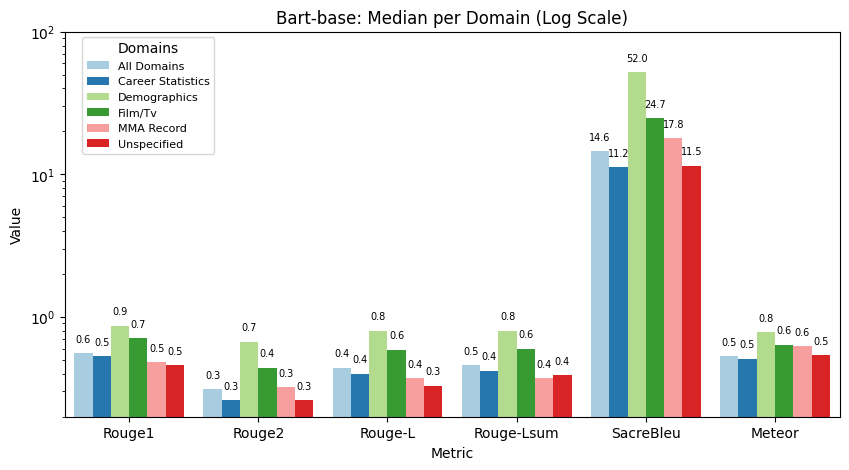

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Set the global style for the plots

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(median_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)

plt.title("Bart-base: Median per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10



<ipython-input-16-65806b7e4297>:10: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)


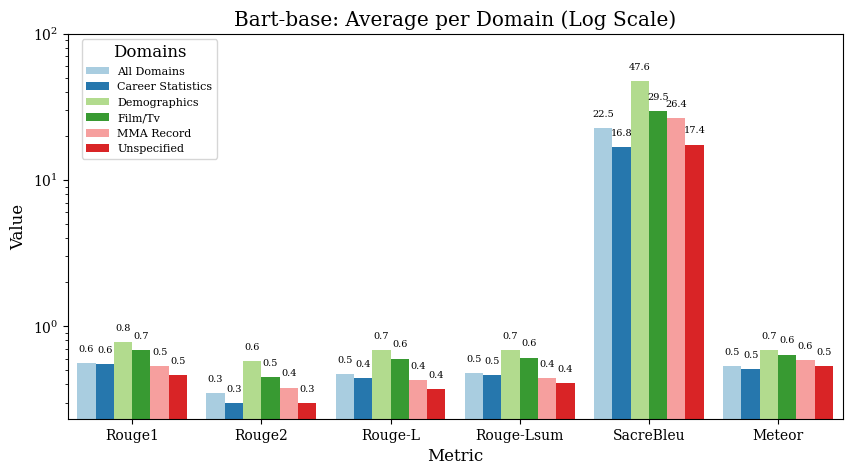

In [ ]:
import matplotlib as mpl

# Set the global style for the plots

plt.figure(figsize=(10, 5))
plt.yscale('log')

melted_df = pd.melt(avg_dataframe, id_vars='Metric', var_name='Domain', value_name='Value')

ax = sns.barplot(x='Metric', y='Value', hue='Domain', data=melted_df, palette=sns.color_palette("Paired"),saturation=0.9,width=0.85)

plt.title("Bart-base: Average per Domain (Log Scale)")
plt.legend(title='Domains', loc='best', bbox_to_anchor=(0.2, 1), prop={'size': 8})
plt.ylim(top=100)

# Add labels above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=7)

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10



In [ ]:
files=['/content/df_All_Bart.pkl','/content/df_Blank_Bart.pkl','/content/df_FilmTv_Bart.pkl',
       '/content/df_cs_Bart.pkl','/content/df_demographics_Bart.pkl','/content/df_mma_Bart.pkl']

dfs_Bart={}
for i in range(len(files)):
  with open(files[i], 'rb') as file:
      dfs_Bart[i] = pickle.load(file)

In [ ]:
dfs_Bart[0]['Domain'] = 'All'
dfs_Bart[2]['Domain'] = 'Film/Tv'
dfs_Bart[4]['Domain'] = 'Demographics'
dfs_Bart[1]['Domain'] = 'Unspecified'
dfs_Bart[5]['Domain'] = 'MMA Record'
dfs_Bart[3]['Domain'] = 'Career Statistics'

combined_df = pd.concat([dfs_Bart[0], dfs_Bart[2],dfs_Bart[4],dfs_Bart[1],dfs_Bart[5],dfs_Bart[3]])
combined_df['Domain'] = pd.Categorical(combined_df['Domain'], ordered=True)
combined_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="SacreBleu", data=combined_df, color="royalblue",cut=0)
plt.title("Bart-base: SacreBleu per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(12, 6))
sns.violinplot(x="Domain", y="Meteor", data=combined_df, color="gray",cut=0)
plt.title("Bart-base: Meteor per Domain")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Assuming combined_df is your DataFrame containing data

# Set the global style for the plots
sns.set(style="whitegrid")

# Set the font properties
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

# Create a trellis plot with two violinplots
plt.figure(figsize=(25, 14))

# Plot for Rouge1
plt.subplot(2, 2, 1)
sns.violinplot(x="Domain", y="Rouge1", data=combined_df, color="indianred",cut=0)
plt.title("Bart-base: Rouge 1 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for Rouge2
plt.subplot(2, 2, 2)
sns.violinplot(x="Domain", y="Rouge2", data=combined_df, color="indianred",cut=0)
plt.title("Bart-base: Rouge 2 per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeL
plt.subplot(2, 2, 3)
sns.violinplot(x="Domain", y="Rouge-L", data=combined_df, color="indianred",cut=0)
plt.title("Bart-base: Rouge L per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Plot for RougeLsum
plt.subplot(2, 2, 4)
sns.violinplot(x="Domain", y="Rouge-Lsum", data=combined_df, color="indianred",cut=0)
plt.title("Bart-base: Rouge Lsum per Domain",size=20)
plt.xlabel('')
plt.ylabel('')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#EDA of Summaries

In [ ]:
import pickle

#lists with the paths
sum_paths_bart=['/content/summaries_Bart_1.pkl' ,'/content/summaries_Bart_2.pkl','/content/summaries_Bart_3.pkl'
           ,'/content/summaries_Bart_4.pkl','/content/summaries_Bart_5.pkl']

sum_paths_T5_small=['/content/summaries_T5_1.pkl' ,'/content/summaries_T5_2.pkl','/content/summaries_T5_3.pkl'
           ,'/content/summaries_T5_4.pkl','/content/summaries_T5_5.pkl']

sum_paths_T5_base=['/content/summaries_T5_base1 (1).pkl' ,'/content/summaries_T5_base2 (1).pkl','/content/summaries_T5_base3 (1).pkl'
           ,'/content/summaries_T5_base4 (1).pkl','/content/summaries_T5_base5 (1).pkl']


bart,T5_small,T5_base={},{},{}

for path in range(len(sum_paths_bart)):
  with open(sum_paths_bart[path], 'rb') as file:
      bart[path] = pickle.load(file)

for path in range(len(sum_paths_T5_small)):
  with open(sum_paths_T5_small[path], 'rb') as file:
      T5_small[path] = pickle.load(file)

for path in range(len(sum_paths_T5_base)):
  with open(sum_paths_T5_base[path], 'rb') as file:
      T5_base[path] = pickle.load(file)

In [ ]:
#adjusting the keys and putting everything into a dictionary
new_starting_key = 1540

summaries_Bart={}
for i in bart.keys():
    bart[i] = {key + new_starting_key * i: value for key, value in bart[i].items()}
    summaries_Bart.update(bart[i])

summaries_T5_small={}
for i in T5_small.keys():
    T5_small[i] = {key + new_starting_key * i: value for key, value in T5_small[i].items()}
    summaries_T5_small.update(T5_small[i])


summaries_T5_base={}
for i in T5_base.keys():
    T5_base[i] = {key + new_starting_key * i: value for key, value in T5_base[i].items()}
    summaries_T5_base.update(T5_base[i])

In [ ]:
for key, value in summaries_Bart.items():
    if isinstance(value, list):
        # If the value is a list, check if it contains a dictionary
        for item in value:
            if isinstance(item, dict):
                # If it's a dictionary, extract the 'summary_text' and update the value
                summary_text = item.get('summary_text', '')
                summaries_Bart[key] = summary_text

for key, value in summaries_T5_small.items():
    if isinstance(value, list):
        # If the value is a list, check if it contains a dictionary
        for item in value:
            if isinstance(item, dict):
                # If it's a dictionary, extract the 'summary_text' and update the value
                summary_text = item.get('summary_text', '')
                summaries_T5_small[key] = summary_text

for key, value in summaries_T5_base.items():
    if isinstance(value, list):
        # If the value is a list, check if it contains a dictionary
        for item in value:
            if isinstance(item, dict):
                # If it's a dictionary, extract the 'summary_text' and update the value
                summary_text = item.get('summary_text', '')
                summaries_T5_base[key] = summary_text

In [ ]:
import pandas as pd
sum_df=pd.DataFrame(summaries_Bart.values(),columns=['Bart-base Summaries'])
sum_df['T5-small Summaries']=summaries_T5_small.values()
sum_df['T5-base Summaries']=summaries_T5_base.values()
sum_df['Annotation']=df_test.Anotation
sum_df

Bart-base Summaries  \
0     Daniel Henry Chamberlain was the 76th Governor...   
1     Alma Jodorowsky played Evelyn in the 2016 film...   
2     A. J. Hawk finished the 2006 season with 119 c...   
3     Peter II the Simple (Pêr II) (1501–1458) was K...   
4     John S. Watrous was the Speaker of the Minneso...   
...                                                 ...   
7695  As of the census of 2010, there were 2,936 peo...   
7696  At the 2006 CARIFTA Games, Yohan Blake won the...   
7697  Amber Kuo won the Best Actress award at the 45...   
7698  Fatih Mosque is a Religious Cultural Monument ...   
7699  Amlogic's AML8726-M3 was released in 2011.\nTh...   

                                     T5-small Summaries  \
0     Daniel Henry Chamberlain served as the Governo...   
1     In 2016, Jodorowsky played Evelyn in Kids in L...   
2     In 2006, A. J. Hawk scored 119 touchdowns in 1...   
3     Peter II the Simple (Pêr II) 14501457, Arthur ...   
4     Ralph J. Parker served as the Speaker of the M...   
...                                                 ...   
7695  As of the census of 1920, there were 2,936 peo...   
7696  Yohan Blake finished the 100 m with 10.11 CR (...   
7697  In 2010, Amber Kuo won the 45th Golden Bell Aw...   
7698  Fatih Mosque is a religious monument in Durrs ...   
7699      Amlogic has a 32-bit Ethernet speed of 32 nm.   

                                      T5-base Summaries  \
0     Daniel Henry Chamberlain was the 76th Governor...   
1     In 2016, Alma Jodorowsky played the role of Ev...   
2                           A. J. Hawk had 119 tackles.   
3     Peter II the Simple (Pêr II) was the ruler of ...   
4     John S. Watrous was the Speaker of the Minneso...   
...                                                 ...   
7695  As of the census of 2000, there were 2,936 peo...   
7696  Blake finished the 100 m in 10.11 c.r.c. (+1.2...   
7697  In 2010, Amber Kuo was nominated for Best Actr...   
7698  Fatih Mosque is one of the religious cultural ...   
7699  In 2012, Amlogic released the M801 and M802 Sm...   

                                             Annotation  
0     Daniel Henry Chamberlain was the 76th Governor...  
1     Alma Jodorowsky had the role of Evelyn in 2016...  
2     In his rookie season, Hawk led with 119 total ...  
3     At the very end of his life, Arthur III became...  
4     Ralph J. Parker was a Minnesota politician and...  
...                                                 ...  
7695       Hobart became the residence of 2,936 people.  
7696  Blake set the fastest time by a Jamaican junio...  
7697  Amber Kuo was nominated in 2010 for Best Actre...  
7698  The Fatih Mosque is a Cultural Monument of Alb...  
7699  Amlogic AML8726-M is a single core ARM Cortex ...  

[7700 rows x 4 columns]

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to each column and compute the average
average_words_per_column = sum_df.apply(lambda column: column.apply(count_words).mean())
median_words_per_column = sum_df.apply(lambda column: column.apply(count_words).median())
sd_words_per_column = sum_df.apply(lambda column: column.apply(count_words).std())
min_words_per_column = sum_df.apply(lambda column: column.apply(count_words).min())
max_words_per_column = sum_df.apply(lambda column: column.apply(count_words).max())

print("Number of words per Text: Average \n")
print(round(average_words_per_column).astype(int))
print("\nNumber of words per Text: Median\n")
print(round(median_words_per_column).astype(int))
print("\nNumber of words per Text: Standard Deviation \n")
print(round(sd_words_per_column).astype(int))
print("\nNumber of words per Text: Min \n")
print(round(min_words_per_column).astype(int))
print("\nNumber of words per Text: Max\n")
print(round(max_words_per_column).astype(int))

Number of words per Text: Average 

Bart-base Summaries    27
T5-small Summaries     13
T5-base Summaries      13
Annotation             15
dtype: int64

Number of words per Text: Median

Bart-base Summaries    16
T5-small Summaries     12
T5-base Summaries      13
Annotation             14
dtype: int64

Number of words per Text: Standard Deviation 

Bart-base Summaries    53
T5-small Summaries      3
T5-base Summaries       3
Annotation              6
dtype: int64

Number of words per Text: Min 

Bart-base Summaries    3
T5-small Summaries     4
T5-base Summaries      4
Annotation             3
dtype: int64

Number of words per Text: Max

Bart-base Summaries    2029
T5-small Summaries       27
T5-base Summaries        26
Annotation               52
dtype: int64


**Readability:**
Let's now assess how difficult the texts are to understand. For this purpose we will use the Flesch Reading Ease Score from the
[textstat library](https://pypi.org/project/textstat/). Since both the mean and median appear to be between 70 and 79 , the texts are fairly easy to comprehend.

In [ ]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00


In [ ]:
#!pip install textstat -q
from textstat import flesch_reading_ease
print("---------------Flesch Reading Ease Score-----------------")
print(f"Annotations:\nRounded Average: {round(sum_df['Annotation'].apply(lambda x : flesch_reading_ease(x)).mean())}\nRounded Median: {round(sum_df['Annotation'].apply(lambda x : flesch_reading_ease(x)).median())}\nRounded Standard Deviation: {round(sum_df['Annotation'].apply(lambda x : flesch_reading_ease(x)).std())} ")
print(f"\nT5-small Summaries:\nRounded Average: {round(sum_df['T5-small Summaries'].apply(lambda x : flesch_reading_ease(x)).mean())}\nRounded Median: {round(sum_df['T5-small Summaries'].apply(lambda x : flesch_reading_ease(x)).median())}\nRounded Standard Deviation: {round(sum_df['T5-small Summaries'].apply(lambda x : flesch_reading_ease(x)).std())} ")
print(f"\nT5-base Summaries:\nRounded Average: {round(sum_df['T5-base Summaries'].apply(lambda x : flesch_reading_ease(x)).mean())}\nRounded Median: {round(sum_df['T5-base Summaries'].apply(lambda x : flesch_reading_ease(x)).median())}\nRounded Standard Deviation: {round(sum_df['T5-base Summaries'].apply(lambda x : flesch_reading_ease(x)).std())} ")
print(f"\nBart-base Summaries:\nRounded Average: {round(sum_df['Bart-base Summaries'].apply(lambda x : flesch_reading_ease(x)).mean())}\nRounded Median: {round(sum_df['Bart-base Summaries'].apply(lambda x : flesch_reading_ease(x)).median())}\nRounded Standard Deviation: {round(sum_df['Bart-base Summaries'].apply(lambda x : flesch_reading_ease(x)).std())} ")


---------------Flesch Reading Ease Score-----------------
Annotations:
Rounded Average: 74
Rounded Median: 75
Rounded Standard Deviation: 18 

T5-small Summaries:
Rounded Average: 76
Rounded Median: 77
Rounded Standard Deviation: 17 

T5-base Summaries:
Rounded Average: 76
Rounded Median: 77
Rounded Standard Deviation: 17 

Bart-base Summaries:
Rounded Average: 75
Rounded Median: 76
Rounded Standard Deviation: 17 


In [ ]:
word_count=sum_df.apply(lambda column: column.apply(count_words))
word_count

Bart-base Summaries  T5-small Summaries  T5-base Summaries  Annotation
0                      14                  14                 14          12
1                      11                   9                 15          13
2                      17                  11                  6          10
3                      15                  14                 15          16
4                      58                  13                 16          16
...                   ...                 ...                ...         ...
7695                   13                  13                 13           7
7696                   27                  11                 10          16
7697                   23                  20                 22          22
7698                    9                   9                 11          12
7699                   56                  11                 17          23

[7700 rows x 4 columns]

(2.1657743958430147, 10000)

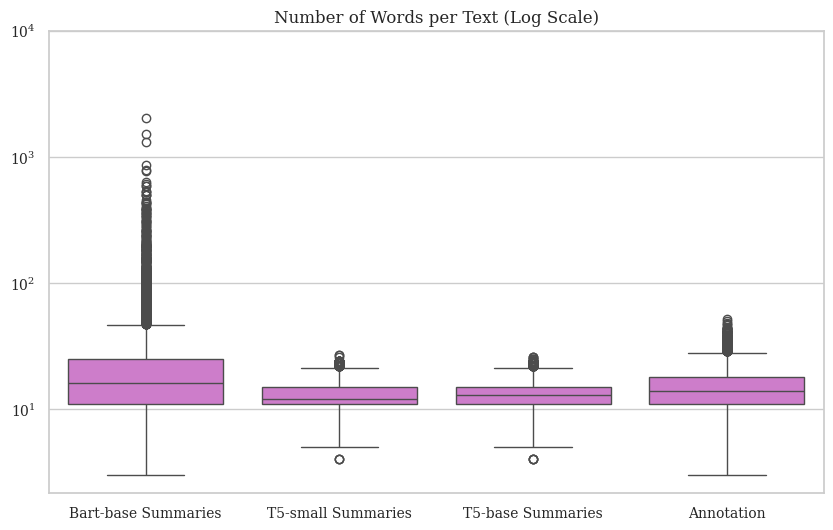

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(10, 6))
sns.boxplot(data=word_count,color='orchid')
plt.yscale('log')
plt.title('Number of Words per Text (Log Scale)')
plt.ylim(top=10000, bottom=0)

In [ ]:
!pip install nltk -q

In [ ]:
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources (stopwords and punkt tokenizer)
nltk.download('stopwords')
nltk.download('punkt')

def get_most_common_words(column, num_top_words=10):
    all_words = []

    for text in column:
        words = word_tokenize(str(text).lower())  # Convert to lowercase for case-insensitive counting
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
        all_words.extend(filtered_words)

    # Calculate word frequencies
    freq_dist = FreqDist(all_words)

    return freq_dist


result_freq_dist_T5_small = get_most_common_words(sum_df['T5-small Summaries'])
result_freq_dist_T5_base = get_most_common_words(sum_df['T5-base Summaries'])
result_freq_dist_Bart = get_most_common_words(sum_df['Bart-base Summaries'])
result_freq_dist_Annotation = get_most_common_words(sum_df['Annotation'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd

def create_top_20_df(name):
    df_name = f"freq_words_{name}"
    df_name = pd.DataFrame(get_most_common_words(sum_df[name]).items(), columns=['Word', f'Absolute Frequency {name}'])
    df_name = df_name.sort_values(by=f'Absolute Frequency {name}', ascending=False).set_index('Word')
    df_name = df_name.head(20)
    return df_name

freq_words_T5_base=create_top_20_df("T5-base Summaries")
freq_words_T5_small=create_top_20_df("T5-small Summaries")
freq_words_Bart_base=create_top_20_df("Bart-base Summaries")
freq_words_Annotation=create_top_20_df("Annotation")

In [ ]:
#find the top 20 most frequent words that are present in all dfs
common_words = set(freq_words_T5_base.index.intersection(freq_words_T5_small.index ))
common_words= set(common_words.intersection(freq_words_Bart_base.index))
common_words= set(common_words.intersection(freq_words_Annotation.index))
common_words


{'2010',
 'census',
 'cup',
 'film',
 'finished',
 'league',
 'people',
 'played',
 'scored',
 'season',
 'world'}

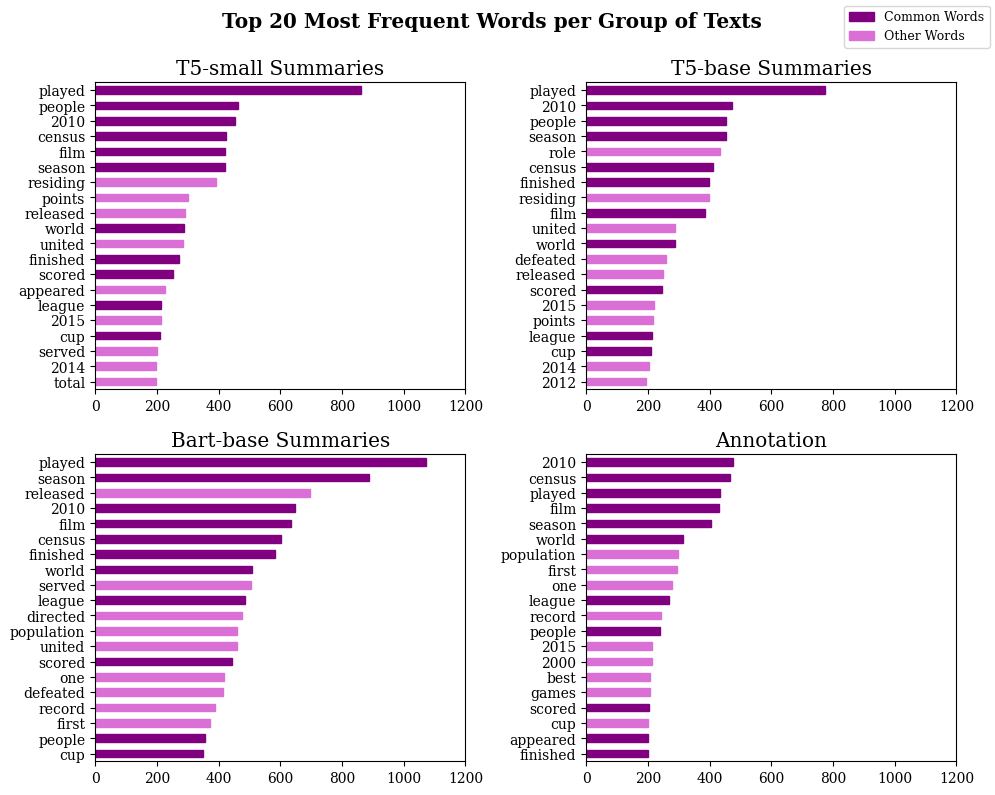

In [ ]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Subplot 1: T5-small
#color the bars of common words with a different color to stand out
colors = ['orchid' if word not in common_words else 'purple' for word in freq_words_T5_small.index]
sorted_colors=[colors[i] for i in reversed(range(len(colors)))]

bars1 = freq_words_T5_small.sort_values(by='Absolute Frequency T5-small Summaries').plot(kind='barh',legend=False,ax=axes[0, 0])

# Set the colors based on common_words
for bar, color in zip(bars1.patches, sorted_colors):
    bar.set_color(color)

axes[0, 0].set_title('T5-small Summaries')
axes[0, 0].set_xlim(right=1200)
axes[0, 0].set_ylabel("")
axes[0,0].grid(False)

# Subplot 2: T5-base
#color the bars of common words with a different color to stand out
colors = ['orchid' if word not in common_words else 'purple' for word in freq_words_T5_base.index]
sorted_colors=[colors[i] for i in reversed(range(len(colors)))]

bars2=freq_words_T5_base.sort_values(by='Absolute Frequency T5-base Summaries').plot(kind='barh', legend=False, ax=axes[0, 1])

# Set the colors based on common_words
for bar, color in zip(bars2.patches, sorted_colors):
    bar.set_color(color)

axes[0, 1].set_title('T5-base Summaries')
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlim(right=1200)
axes[0, 1].grid(False)

# Subplot 3: Bart-base
#color the bars of common words with a different color to stand out
colors = ['orchid' if word not in common_words else 'purple' for word in freq_words_Bart_base.index]
sorted_colors=[colors[i] for i in reversed(range(len(colors)))]

bars3=freq_words_Bart_base.sort_values(by='Absolute Frequency Bart-base Summaries').plot(kind='barh', legend=False, ax=axes[1, 0])

# Set the colors based on common_words
for bar, color in zip(bars3.patches, sorted_colors):
    bar.set_color(color)

axes[1, 0].set_title('Bart-base Summaries')
axes[1, 0].set_xlim(right=1200)
axes[1, 0].set_ylabel("")
axes[1,0].grid(False)

# Subplot 4: Annotation
#color the bars of common words with a different color to stand out
colors = ['orchid' if word not in common_words else 'purple' for word in freq_words_Annotation.index]
sorted_colors=[colors[i] for i in reversed(range(len(colors)))]

bars4=freq_words_Annotation.sort_values(by='Absolute Frequency Annotation').plot(kind='barh', legend=False, ax=axes[1, 1])

# Set the colors based on common_words
for bar, color in zip(bars4.patches, sorted_colors):
    bar.set_color(color)

axes[1, 1].set_title('Annotation')
axes[1, 1].set_xlim(right=1200)
axes[1, 1].set_ylabel("")
axes[1, 1].grid(False)

# Add the legend
legend_patch = mpatches.Patch(color='purple', label='Common Words')
legend_patch_other = mpatches.Patch(color='orchid', label='Other Words')
fig.legend(handles=[legend_patch, legend_patch_other], loc='upper right',fontsize=9)

fig.suptitle('Top 20 Most Frequent Words per Group of Texts', y=0.99, weight='bold')


# Adjust layout
plt.tight_layout()

plt.show()


#My models VS NARRATABLE

In [ ]:
narattable={'Rouge1': 0.56, 'Rouge2': 0.33, 'Rouge-L': 0.48, 'Rouge-Lsum': 0.48, 'SacreBleu': 20.87, 'Meteor': 0.49}

In [ ]:
import pickle
files=['/content/T5_All_avg_all.pkl','/content/T5_All_median_all.pkl','/content/T5_All_sd_all.pkl',
       '/content/T5_base_All_avg_all.pkl','/content/T5_base_All_median_all.pkl','/content/T5_base_All_sd_all.pkl',
       '/content/Bart_All_avg_all.pkl','/content/Bart_All_median_all.pkl','/content/Bart_All_sd_all.pkl']

metrics={}
for i in range(len(files)):
  with open(files[i], 'rb') as file:
      metrics[i] = pickle.load(file)

In [ ]:
T5_small_avg=metrics[0]
T5_small_median=metrics[1]
T5_small_sd=metrics[2]
T5_base_avg=metrics[3]
T5_base_median=metrics[4]
T5_base_sd=metrics[5]
Bart_base_avg=metrics[6]
Bart_base_median=metrics[7]
Bart_base_sd=metrics[8]

In [ ]:
import pandas as pd
print('------------All-Test-set-Median---------------')
median_dataframe=pd.DataFrame(T5_small_median.keys(),index=range(len(T5_small_median.keys())),columns=['Metric'])
median_dataframe['T5-small']=T5_small_median.values()
median_dataframe['T5-base']=T5_base_median.values()
median_dataframe['Bart-base']=Bart_base_median.values()
median_dataframe

------------All-Test-set-Median---------------


Metric  T5-small  T5-base  Bart-base
0      Rouge1      0.57     0.59       0.56
1      Rouge2      0.31     0.32       0.31
2     Rouge-L      0.45     0.47       0.44
3  Rouge-Lsum      0.45     0.47       0.46
4   SacreBleu     14.29    15.01      14.57
5      Meteor      0.48     0.50       0.53

In [ ]:
print('------------All-Test-set-Average---------------')
avg_dataframe=pd.DataFrame(T5_small_avg.keys(),index=range(len(T5_small_avg.keys())),columns=['Metric'])
avg_dataframe['T5-small']=T5_small_avg.values()
avg_dataframe['T5-base']=T5_base_avg.values()
avg_dataframe['Bart-base']=Bart_base_avg.values()
avg_dataframe

------------All-Test-set-Average---------------


Metric  T5-small  T5-base  Bart-base
0      Rouge1      0.57     0.58       0.56
1      Rouge2      0.34     0.35       0.35
2     Rouge-L      0.48     0.49       0.47
3  Rouge-Lsum      0.48     0.49       0.48
4   SacreBleu     21.00    22.05      22.50
5      Meteor      0.49     0.50       0.53

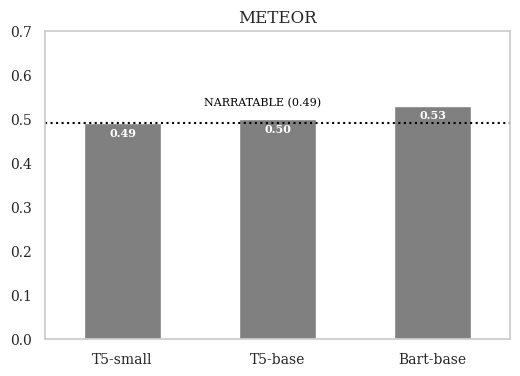

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
fig, ax = plt.subplots(figsize=(6, 4))

bars = avg_dataframe.T[5].tail(3).plot(kind='bar', color='gray', ax=ax)
plt.axhline(y=0.49, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
plt.text(0.9, 0.53, 'NARRATABLE (0.49)', color='black', fontsize=8, ha='center')

# Add labels inside the bars
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03,
            f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8,weight='bold')

ax.grid(False)
plt.xticks(rotation=0)
plt.ylim(top=0.7)
plt.title('METEOR')
plt.show()

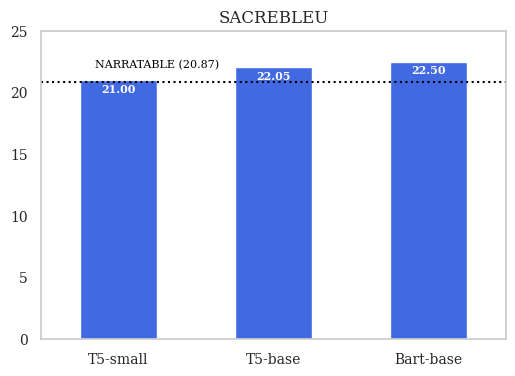

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
fig, ax = plt.subplots(figsize=(6, 4))

bars = avg_dataframe.T[4].tail(3).plot(kind='bar', color='royalblue', ax=ax)
plt.axhline(y=20.87, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
plt.text(0.25, 22, 'NARRATABLE (20.87)', color='black', fontsize=8, ha='center')

# Add labels inside the bars
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1,
            f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8,weight='bold')

ax.grid(False)
plt.xticks(rotation=0)
plt.ylim(top=25)
plt.title('SACREBLEU')
plt.show()

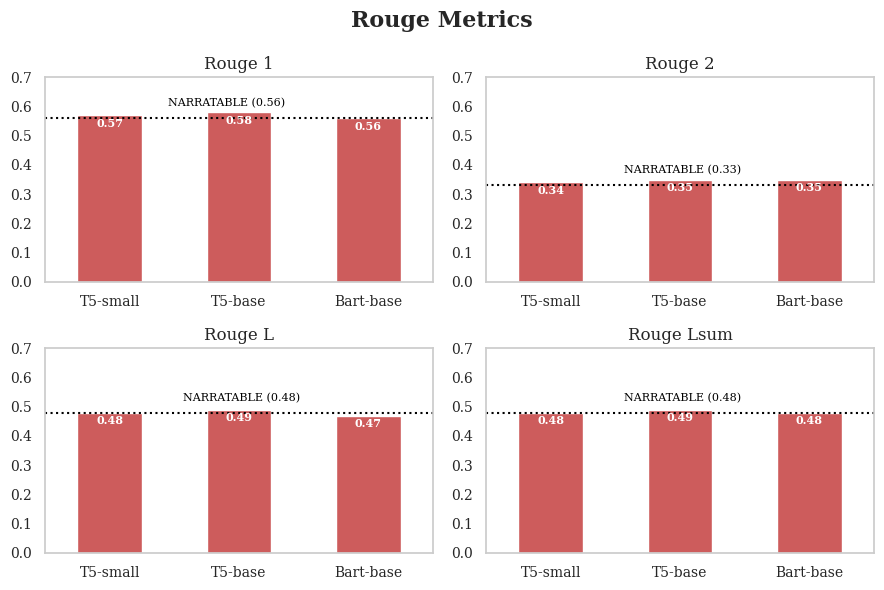

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Customizing Matplotlib settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Data for the first subplot (Rouge 1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))

# Subplot 1 (Rouge 1)
bars2 = avg_dataframe.T[0].tail(3).plot(kind='bar', color='indianred', ax=axes[0, 0])
axes[0, 0].axhline(y=0.56, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
axes[0, 0].text(0.9, 0.6, 'NARRATABLE (0.56)', color='black', fontsize=8, ha='center')

for bar in bars2.patches:
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.04,
                    f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8, weight='bold')

axes[0, 0].set_ylim(top=0.7)
axes[0, 0].set_title('Rouge 1')
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].grid(False)

# Data for the second subplot (Rouge 2)
bars1 = avg_dataframe.T[1].tail(3).plot(kind='bar', color='indianred', ax=axes[0, 1])
axes[0, 1].axhline(y=0.33, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
axes[0, 1].text(1.02, 0.37, 'NARRATABLE (0.33)', color='black', fontsize=8, ha='center')

for bar in bars1.patches:
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.04,
                    f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8, weight='bold')

axes[0, 1].set_ylim(top=0.7)
axes[0, 1].set_title('Rouge 2')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(False)

# Data for the third subplot (Rouge L)
bars3 = avg_dataframe.T[2].tail(3).plot(kind='bar', color='indianred', ax=axes[1, 0])
axes[1, 0].axhline(y=0.48, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
axes[1, 0].text(1.02, 0.52, 'NARRATABLE (0.48)', color='black', fontsize=8, ha='center')

for bar in bars3.patches:
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.04,
                    f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8, weight='bold')

axes[1, 0].set_ylim(top=0.7)
axes[1, 0].set_title('Rouge L')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(False)

# Data for the third subplot (Rouge Lsum)
bars4 = avg_dataframe.T[3].tail(3).plot(kind='bar', color='indianred', ax=axes[1, 1])
axes[1, 1].axhline(y=0.48, color='black', linestyle='dotted', label='NARRATABLE', xmax=1)
axes[1, 1].text(1.02, 0.52, 'NARRATABLE (0.48)', color='black', fontsize=8, ha='center')

for bar in bars4.patches:
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.04,
                    f'{bar.get_height():.2f}', color='white', ha='center', fontsize=8, weight='bold')

axes[1, 1].set_ylim(top=0.7)
axes[1, 1].set_title('Rouge Lsum')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(False)

fig.suptitle('Rouge Metrics', fontsize=16, y=0.98, weight='bold')
# Adjust layout
plt.tight_layout()
plt.show()



In [ ]:
print('-------All-Test-set-Standard-Deviation--------')
sd_dataframe=pd.DataFrame(T5_small_sd.keys(),index=range(len(T5_small_sd.keys())),columns=['Metric'])
sd_dataframe['T5-small']=T5_small_sd.values()
sd_dataframe['T5-base']=T5_base_sd.values()
sd_dataframe['Bart-base']=Bart_base_sd.values()
sd_dataframe

-------All-Test-set-Standard-Deviation--------


Metric  T5-small  T5-base  Bart-base
0      Rouge1      0.20     0.21       0.23
1      Rouge2      0.23     0.23       0.24
2     Rouge-L      0.21     0.21       0.23
3  Rouge-Lsum      0.21     0.21       0.23
4   SacreBleu     19.56    20.19      22.03
5      Meteor      0.22     0.23       0.22

#**LLama2-7b-chat**

**Load Data**

In [ ]:
#loading the train data
%%capture
!wget -O /content/processed_training_set_tables.pkl  https://www.dropbox.com/scl/fi/l6nuj0r37xvqa7bv0uof0/llama2_input_train.pkl?rlkey=dks39au0u6hacf8vml1538ssz&dl=0
!wget -O /content/llama_2_val.pkl  https://www.dropbox.com/scl/fi/9u0hfi6ho8zw15oq2zghx/llama2_input_val.pkl?rlkey=nm1s1gykmizaztxmmrn3gy4y5&dl=0
!wget -O /content/test.pkl  https://www.dropbox.com/scl/fi/kzxb0rys7l8lop87x26nn/T5_input_test.pkl?rlkey=sxfwm1p57ns846w46tbmnzc47&dl=0

In [ ]:
import pickle

file_paths = ['/content/processed_training_set_tables.pkl', '/content/llama_2_val.pkl','/content/test.pkl']

data={}
for i, file_path in enumerate(file_paths):
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        data[i] = loaded_data


In [ ]:
import pandas as pd
df_train=pd.DataFrame(data[0].values())
df_train = df_train.rename(columns={0: 'text'})
df_train

text
0      <s>[INST] Make a summary using the words and n...
1      <s>[INST] Make a summary using the words and n...
2      <s>[INST] Make a summary using the words and n...
3      <s>[INST] Make a summary using the words and n...
4      <s>[INST] Make a summary using the words and n...
...                                                  ...
12071  <s>[INST] Make a summary using the words and n...
12072  <s>[INST] Make a summary using the words and n...
12073  <s>[INST] Make a summary using the words and n...
12074  <s>[INST] Make a summary using the words and n...
12075  <s>[INST] Make a summary using the words and n...

[12076 rows x 1 columns]

In [ ]:
df_train['text'].iloc[9008]

"<s>[INST] Make a summary using the words and numbers between 'Focus on:' and 'Table Structure:'. Table page title: Mark Patton, Table section title: Film, Table section text: , Table converted to text: Year is 1982, Title is Come Back to the Five and Dime, Jimmy Dean, Jimmy Dean, Role is Joe Qualley, Notes is Feature film. Year is 1982, Title is Anna to the Infinite Power, Role is Rowan Hart, Notes is Feature film. Year is 1985, Title is A Nightmare on Elm Street 2: Freddys Revenge, Role is Jesse Walsh, Notes is Feature film. Year is 2003, Title is Freddy vs. Jason, Role is Jesse Walsh, Notes is Archive footage, special thanks. Year is 2010, Title is Never Sleep Again: The Elm Street Legacy, Role is Himself, Notes is Documentary. Year is 2016, Title is Family Possessions, Role is Tyson, Notes is Feature film. Year is 2017, Title is Amityville: Evil Never Dies, Role is James, Notes is Feature film, Focus on: 1985 A Nightmare on Elm Street 2: Freddys Revenge Jesse Walsh, Table Structure

In [ ]:
df_val=pd.DataFrame(data[1].values())
df_val = df_val.rename(columns={0: 'text'})
df_val

text
0      <s>[INST] Make a summary using the words and n...
1      <s>[INST] Make a summary using the words and n...
2      <s>[INST] Make a summary using the words and n...
3      <s>[INST] Make a summary using the words and n...
4      <s>[INST] Make a summary using the words and n...
...                                                  ...
12071  <s>[INST] Make a summary using the words and n...
12072  <s>[INST] Make a summary using the words and n...
12073  <s>[INST] Make a summary using the words and n...
12074  <s>[INST] Make a summary using the words and n...
12075  <s>[INST] Make a summary using the words and n...

[12076 rows x 1 columns]

In [ ]:
df_test=data[2]
df_test

Table to Text  \
0     Table page title: List of Governors of South C...   
1     Table page title: Alma Jodorowsky, Table secti...   
2     Table page title: A. J. Hawk, Table section ti...   
3     Table page title: List of rulers of Brittany, ...   
4     Table page title: List of Speakers of the Minn...   
...                                                 ...   
7695  Table page title: Hobart, Oklahoma, Table sect...   
7696  Table page title: Yohan Blake, Table section t...   
7697  Table page title: Amber Kuo, Table section tit...   
7698  Table page title: List of Religious Cultural M...   
7699  Table page title: Amlogic, Table section title...   

                                              Anotation  \
0     Daniel Henry Chamberlain was the 76th Governor...   
1     Alma Jodorowsky had the role of Evelyn in 2016...   
2     In his rookie season, Hawk led with 119 total ...   
3     At the very end of his life, Arthur III became...   
4     Ralph J. Parker was a Minnesota politician and...   
...                                                 ...   
7695       Hobart became the residence of 2,936 people.   
7696  Blake set the fastest time by a Jamaican junio...   
7697  Amber Kuo was nominated in 2010 for Best Actre...   
7698  The Fatih Mosque is a Cultural Monument of Alb...   
7699  Amlogic AML8726-M is a single core ARM Cortex ...   

                           table_section_title  
0     Governors under the Constitution of 1868  
1                                  Filmography  
2                            Career statistics  
3                            House of Montfort  
4                                        State  
...                                        ...  
7695                              Demographics  
7696                              Achievements  
7697                    Awards and nominations  
7698                             Durrës County  
7699                          Comparison table  

[7700 rows x 3 columns]

In [ ]:
df_test['Table to Text'].iloc[0]

'Table page title: List of Governors of South Carolina, Table section title: Governors under the Constitution of 1868, Table section text: Parties Democratic Republican, Table converted to text: Number is 74, Governor is -, Governor is Robert Kingston Scott, Took Office is July 6, 1868, Left Office is December 7, 1872, Lt. Governor is Lemuel Boozer Alonzo J. Ransier, Party is Republican, Notes is . Number is 75, Governor is -, Governor is Franklin J. Moses, Jr, Took Office is December 7, 1872, Left Office is December 1, 1874, Lt. Governor is Richard Howell Gleaves, Party is Republican, Notes is . Number is 76, Governor is -, Governor is Daniel Henry Chamberlain, Took Office is December 1, 1874, Left Office is December 14, 1876, Lt. Governor is Richard Howell Gleaves, Party is Republican, Notes is Claimed Governorship after 1876 election. Number is 77, Governor is -, Governor is Wade Hampton III, Took Office is December 14, 1876, Left Office is February 26, 1879, Lt. Governor is William

**Finetuning**

In [ ]:
%%capture
!pip install peft==0.4.0 bitsandbytes trl==0.4.7 accelerate==0.21.0 #==0.40.2

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)


Employing Parameter Efficient Fine-Tuning (PEFT) methods, with a specific focus on LoRa, does not introduce additional layers or require prompt fine-tuning, but instead modifies the values of parameters.

LoRA, which stands for “Low-Rank Adaptation”, distinguishes itself by training and storing the additional weight changes in a matrix while freezing all the pre-trained model weights. LoRA is not called an “adapter” because it does not add adapters. Instead, it is referred to as “adaptation” to describe the process of fine-tuning the domain data and tasks.

**THE ORIGINAL WEIGHTS OF THE PRETRAINED ARE FROZEN. We add some EXTRA weights and update them during finetuning.**

[source](https://medium.com/@shelikohan/low-rank-adapter-lora-explained-0d3677395639)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    'meta-llama/Llama-2-7b-chat-hf',
    quantization_config=bnb_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf', trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16, #alpha scaling
    lora_dropout=0.1,
    r=64, #number of attention heads
    bias="none",
    task_type="CAUSAL_LM",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir='Llama-2-7b-chat-ToTTo',
    num_train_epochs= 3,
    evaluation_strategy="epoch",
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 8,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-5,
    weight_decay=0.001, #legularization: penalize large weights
    fp16=True,
    bf16=False, #set to True if A100
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03, #start with a low lr and gradually increase
    save_strategy="epoch",
    group_by_length=True,
    lr_scheduler_type="cosine",
    seed=42,
    load_best_model_at_end=True
)

In [ ]:
from transformers import TrainerCallback
class PeftSavingCallback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):
        checkpoint_path = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
        kwargs["model"].save_pretrained(checkpoint_path)

        if "pytorch_model.bin" in os.listdir(checkpoint_path):
            os.remove(os.path.join(checkpoint_path, "pytorch_model.bin"))

In [ ]:
def preprocess_logits_for_metrics(logits, labels):
            if isinstance(logits, tuple):
                logits = logits[0]
            return logits.argmax(dim=-1)

In [ ]:
! pip install -q evaluate rouge_score sacrebleu meteor

In [ ]:
import numpy as np
import evaluate
from nltk.translate import bleu_score
from nltk.translate import meteor
from datasets import load_metric

rouge = evaluate.load("rouge",seed=42)
bleu =evaluate.load("sacrebleu",seed=42)
meteor=load_metric("meteor",seed=42)

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode the tokenized predictions back to text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace any -100 values in labels with the tokenizer's pad_token_id.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode the tokenized labels back to text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute the ROUGE metric using stemming
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculate BLEU score
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)

    # Calculate METEOR score
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

    # Calculate the length of each prediction
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]

    # Compute the mean length of the predictions and add it to the result dictionary under the key "gen_len".
    gen_len = np.mean(prediction_lens)

    # Round each value in the result dictionaries to 4 decimal places
    result = {
        "rouge_1": round(rouge_result['rouge1'],4),
        "rouge_2": round(rouge_result['rouge2'],4),
        "rouge_L": round(rouge_result['rougeL'],4),
        "rouge_Lsum": round(rouge_result['rougeLsum'],4),
        "SacreBleu": round(bleu_result['score'],4),
        "meteor": round(meteor_result['meteor'],4),
        "gen_len": round(gen_len, 4),
    }

    return result


<ipython-input-17-b00c4a64a2d6>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  meteor=load_metric("meteor",seed=42)
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt 

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_dict(df_train)
eval_dataset =  Dataset.from_dict(df_val)

torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=328,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/23650 [00:00<?, ? examples/s]

Map:   0%|          | 0/12076 [00:00<?, ? examples/s]

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

1793

In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1107, training_loss=0.9273317960758088, metrics={'train_runtime': 24498.287, 'train_samples_per_second': 2.896, 'train_steps_per_second': 0.045, 'total_flos': 8.602940485208801e+17, 'train_loss': 0.9273317960758088, 'epoch': 2.99})

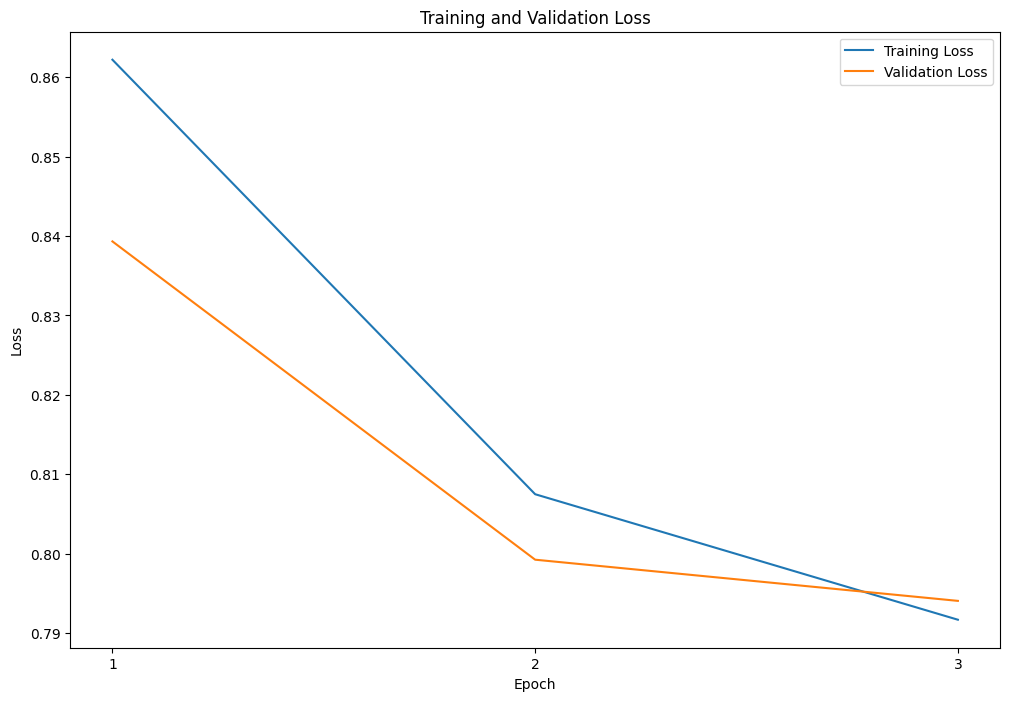

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss from the training history
train_loss = [0.862200, 0.807500, 0.791700 ]
eval_loss = [0.839326,0.799257,0.794073]

# Plot the learning curves
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xticks([0,1,2],[1,2,3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#source: https://colab.research.google.com/github/elsanns/xai-nlp-notebooks/blob/master/fine_tune_bart_summarization_two_langs.ipynb

def batch_tokenize_preprocess(batch, tokenizer, max_source_length, max_target_length):
    source, target = batch["Table to Text"], batch["Anotation"]
    source_tokenized = tokenizer(
        source, padding="max_length", truncation=True, max_length=max_source_length
    )
    target_tokenized = tokenizer(
        target, padding="max_length", truncation=True, max_length=max_target_length
    )

    batch = {k: v for k, v in source_tokenized.items()}
    # Ignore padding in the loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in target_tokenized["input_ids"]
    ]
    return batch


test =  Dataset.from_dict(df_test[0:200])
test_data = test.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, 2000, 50
    ),
    batched=True,
    remove_columns=test.column_names,
)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
trainer.predict(test_data)[2]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.82 GiB. GPU 0 has a total capacty of 15.77 GiB of which 1.45 GiB is free. Process 55455 has 14.07 GiB memory in use. Of the allocated memory 8.10 GiB is allocated by PyTorch, and 5.59 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

**Saving the Lora adapter and merged model to HF**

In [ ]:
trainer.save_model("llama2-chat-7b-ToTTo-3epochs")

In [ ]:
fine_tuned_model = trainer.model

fine_tuned_model.push_to_hub("llama2-chat-7b-ToTTo-3epochs")
tokenizer.push_to_hub("llama2-chat-7b-ToTTo-3epochs")

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Depie/llama2-chat-7b-ToTTo-3epochs/commit/f18eaf3372487cb0de944f036ec5d24ca3add3b0', commit_message='Upload tokenizer', commit_description='', oid='f18eaf3372487cb0de944f036ec5d24ca3add3b0', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!pip install peft==0.4.0 install sentencepiece accelerate bitsandbytes -q


In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer

model_name = "meta-llama/Llama-2-7b-chat-hf"

m = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=False,
    torch_dtype=torch.bfloat16,
    device_map={"": 0}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
torch.cuda.empty_cache()

adapters_name = "Depie/llama2-chat-7b-ToTTo-3epochs"
m = PeftModel.from_pretrained(m, adapters_name)
m = m.merge_and_unload()

adapter_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

In [ ]:
m.save_pretrained("Llama-2-7b-chat-ToTTo-3epochs-merged")

In [ ]:
m.push_to_hub("Depie/Llama-2-7b-chat-ToTTo-3epochs-merged")

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Depie/Llama-2-7b-chat-ToTTo-3epochs-merged/commit/8e2bc584bc9c3459bb498b9ed8c7313a26cc5d78', commit_message='Upload LlamaForCausalLM', commit_description='', oid='8e2bc584bc9c3459bb498b9ed8c7313a26cc5d78', pr_url=None, pr_revision=None, pr_num=None)

**Load the Fine-tuned PEFT/LoRA Model**



In [ ]:
%%capture
!pip install peft==0.4.0 bitsandbytes trl==0.4.7 accelerate==0.21.0 sentencepiece

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer

In [ ]:
model = AutoModelForCausalLM.from_pretrained("Depie/Llama-2-7b-chat-ToTTo_merged", load_in_4bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')
tokenizer.bos_token_id = 1 #begining of sentence token
stop_token_ids = [0]

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

75

**Evaluation**

Let's now print the generated summaries and the anotation for the first 3tables of the test set:




In [ ]:
from transformers import pipeline

#creating a list that contains the prompts for the first 4 tables of the test data
prompts = [f"<s>[INST] Inluding only the words and numbers between 'Focus on:' and 'Table Structure:' summarize in one sentence: {df_test['Table to Text'].iloc[0]} [/INST]",
           f"<s>[INST] Inluding only the words and numbers between 'Focus on:' and 'Table Structure:' summarize in one sentence: {df_test['Table to Text'].iloc[1]} [/INST]",
           f"<s>[INST] Inluding only the words and numbers between 'Focus on:' and 'Table Structure:' summarize in one sentence: {df_test['Table to Text'].iloc[2]} [/INST]",
           f"<s>[INST] Inluding only the words and numbers between 'Focus on:' and 'Table Structure:' summarize in one sentence: {df_test['Table to Text'].iloc[3]} [/INST]"]

#set seed to get the same results
torch.manual_seed(42)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer,return_full_text=False, top_p=0.95)

torch.cuda.empty_cache()

In [ ]:
summaries={}
for p in range(len(prompts)):
  # Tokenize the input prompt to get input_ids
  input_ids = tokenizer(prompts[p], return_tensors="pt")["input_ids"]
  input_length = input_ids.shape[1]
  #generate the summaries
  generated_output = generator(prompts[p], num_beams=2, max_length=input_length+100, top_k=5, num_return_sequences=1)
  generated_text = generated_output[0]["generated_text"]
  summaries[p]=generated_text
  print(f"Table {p}\nGenerated Summary: {summaries[p]}\nAnotation: {df_test['Anotation'].iloc[p]}\n")


Table 0
Generated Summary:   Daniel Henry Chamberlain was the 76th Governor of South Carolina.
Anotation: Daniel Henry Chamberlain was the 76th Governor of South Carolina from 1874.

Table 1
Generated Summary:  Sure! Here is the summary of the text in one sentence: In 2016, Alma Jodorowsky played Evelyn in the film Kids in Love. 
Anotation: Alma Jodorowsky had the role of Evelyn in 2016 film Kids in Love.

Table 2
Generated Summary:   In 2006, A.J. Hawk played in 16 games, combined tackles were 119, assisted tackles were 37, sacks were 3.5, forced fumbles were 1, fumble recoveries were 2, interceptions were 2, passes defensed were 8, and longest interception return was 25. 

In 2007, A.J.
Anotation: In his rookie season, Hawk led with 119 total tackles.

Table 3
Generated Summary:   Peter II the Simple (Pêr II) ruled from 1450 to 1457, succeeded by Arthur III the Justicier (Arzhur III) who ruled from 1457 to 1458.
Anotation: At the very end of his life, Arthur III became duke of Britta

In [ ]:
! pip install -q evaluate rouge_score sacrebleu meteor

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
import evaluate

rouge = evaluate.load("rouge",seed=42)
bleu =evaluate.load("sacrebleu",seed=42)
meteor=evaluate.load("meteor",seed=42)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
for s in summaries.keys():
  preds = [summaries[s]]
  labels = [df_test['Anotation'].iloc[s]]
  rouge_s=rouge.compute(predictions=preds, references=labels, use_stemmer=True)
  sacrebleu=bleu.compute(predictions=preds, references=labels)
  meteor_s=meteor.compute(predictions=preds, references=labels)
  rouge_1_score = round(rouge_s['rouge1'], 4)
  rouge_2_score = round(rouge_s['rouge2'], 4)
  rouge_L = round(rouge_s['rougeL'], 4)
  rouge_Lsum = round(rouge_s['rougeLsum'], 4)
  bleu_s=round(sacrebleu['score'],4)
  met=round(meteor_s['meteor'],4)
  print(f"For Table {s}:\nRouge 1: {rouge_1_score}\nRouge 2: {rouge_2_score}\nRougeL: {rouge_L}\nRougeLsum: {rouge_Lsum}\nSacreBleu: {bleu_s}\nMeteor: {met}\n")

For Table 0:
Rouge 1: 0.9091
Rouge 2: 0.9
RougeL: 0.9091
RougeLsum: 0.9091
SacreBleu: 76.2626
Meteor: 0.8568

For Table 1:
Rouge 1: 0.6111
Rouge 2: 0.3529
RougeL: 0.4444
RougeLsum: 0.4444
SacreBleu: 17.8957
Meteor: 0.7353

For Table 2:
Rouge 1: 0.1429
Rouge 2: 0.0
RougeL: 0.1429
RougeLsum: 0.1429
SacreBleu: 0.9461
Meteor: 0.1829

For Table 3:
Rouge 1: 0.2857
Rouge 2: 0.1
RougeL: 0.1429
RougeLsum: 0.1429
SacreBleu: 3.9017
Meteor: 0.2634



In [ ]:
from tqdm import tqdm

prompts=dict()
for i in tqdm(range(len(df_test['Table to Text']))):
  prompts[i]=f"<s>[INST] Summarize: {df_test['Table to Text'].iloc[i]} [/INST]"


100%|██████████| 7700/7700 [00:00<00:00, 95582.67it/s]


In [ ]:
def split_dict(original_dict, num_parts):
    avg_length = len(original_dict) // num_parts
    remainder = len(original_dict) % num_parts

    sub_dicts = []
    index = 0

    for i in range(num_parts):
        sub_dict_length = avg_length + 1 if i < remainder else avg_length
        sub_dict = {k: original_dict[k] for k in range(index, index + sub_dict_length)}
        sub_dicts.append(sub_dict)
        index += sub_dict_length

    return sub_dicts

#a list that contains the prompts dict broken down
#to 385 smaller dicts maintaining the original keys
batches = split_dict(prompts, 385) #batches of 20

In [ ]:
 torch.cuda.empty_cache()
 gc.collect()

0

In [ ]:
from transformers import pipeline
import gc
import pickle

generator = pipeline("text-generation", model=model, tokenizer=tokenizer,return_full_text=False, top_p=0.95)

summaries={}
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
  torch.cuda.empty_cache()
  for batch in tqdm(batches[1].keys()):
    torch.cuda.empty_cache()
    # Tokenize the input prompt to get input_ids
    input_ids = tokenizer(prompts[batch], return_tensors="pt",max_length=5000,truncation=True)["input_ids"]
    input_length = input_ids.shape[1]
    print(f" {input_length}" )
    #generate the summaries
    generated_output = generator(prompts[batch], max_length=input_length+25, top_k=5, num_return_sequences=1)
    generated_text = generated_output[0]["generated_text"]
    summaries[batch]=generated_text

In [ ]:
from transformers import pipeline
import gc
import pickle

generator = pipeline("text-generation", model=model, tokenizer=tokenizer,return_full_text=False, top_p=0.95)

gc.collect()
with torch.no_grad():
  for batch in range(1,len(batches)):
    torch.cuda.empty_cache()
    summaries={}
    for p in tqdm(batches[batch].keys()):
      torch.cuda.empty_cache()
      # Tokenize the input prompt to get input_ids
      input_ids = tokenizer(prompts[p], return_tensors="pt",max_length=5000,truncation=True)["input_ids"]
      input_length = input_ids.shape[1]
      print(f" {input_length}" )
      #generate the summaries
      generated_output = generator(prompts[p], max_length=input_length+60, top_k=5, num_return_sequences=1)
      generated_text = generated_output[0]["generated_text"]
      summaries[p]=generated_text

    # Save the dictionary as a pickle file
    with open(f'summaries_Llama2_batch_{batch}.pkl', 'wb') as file:
      pickle.dump(summaries , file)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 5525, but `max_length` is set to 5030. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


 5000


  0%|          | 0/4 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.64 GiB. GPU 0 has a total capacty of 14.75 GiB of which 3.01 GiB is free. Process 103189 has 11.74 GiB memory in use. Of the allocated memory 9.82 GiB is allocated by PyTorch, and 1.79 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
with open('/content/summaries_Llama2_batch_0.pkl', 'rb') as file:
    batch0 = pickle.load(file)

In [ ]:
gc.collect()
torch.cuda.empty_cache()